In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#!pip3 install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb


In [2]:
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
#df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')
#df_final_train.columns
# df_final_train = read_hdf('storage_sample_stage_final.h5', 'train_df',mode='r')
# df_final_test = read_hdf('storage_sample_stage_final.h5', 'test_df',mode='r')
# df_final_train.columns
df_final_train.head()

source  destination  connected  jaccard_followers  jaccard_followees  \
0       1       690569          1                  0           0.090909   
1      18      1003537          1                  0           0.058824   
2      25       992602          1                  0           0.242424   
3      61      1408376          1                  0           0.315789   
4      62       402932          1                  0           0.000000   

   cosine_followers  cosine_followees  num_followers_s  num_followers_d  \
0          0.039817          0.251976                3               29   
1          0.092450          0.149071               13                3   
2          0.138866          0.440386               21               11   
3          0.151523          0.514496                8                7   
4          0.149071          0.000000                5                3   

   num_followees_s  ...   page_rank_s   page_rank_d    katz_s    katz_d  \
0                3  ...  2.979445e-07  3.726469e-06  0.000722  0.000819   
1               15  ...  1.111717e-06  3.046637e-07  0.000759  0.000721   
2               30  ...  1.249942e-06  6.286333e-07  0.000790  0.000753   
3               17  ...  6.565506e-07  4.826817e-07  0.000740  0.000736   
4                3  ...  4.097580e-07  8.216330e-07  0.000729  0.000721   

         hubs_s        hubs_d  authorities_s  authorities_d  \
0  8.549207e-18  1.690629e-16   3.812413e-18   3.942273e-16   
1  1.583866e-17  9.329002e-20   6.343111e-18   1.297053e-19   
2  1.054783e-13  6.601673e-14   6.990593e-15   3.079403e-15   
3  2.768741e-19  2.050358e-19   6.563911e-21   6.826043e-21   
4  3.984634e-18 -0.000000e+00   1.731093e-16   2.732624e-19   

   prefer_Attach_followers  prefer_Attach_followees  
0                       87                       63  
1                       39                       45  
2                      231                      330  
3                       56                      136  
4                       15                        0  

[5 rows x 33 columns]

In [3]:
y_train = df_final_train.connected

In [4]:
df_final_train.drop(['source', 'destination','connected'],axis=1,inplace=True)

## Neural Network

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
%%time
X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=2000

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display



        


feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    model = Sequential()

    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=len(X_train),  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



Epoch 1/2000
1/1 - 1s - loss: 31.4380 - f1_m: 0.0552 - recall_m: 0.0303 - 769ms/epoch - 769ms/step
Epoch 2/2000
1/1 - 0s - loss: 193.0804 - f1_m: 0.6647 - recall_m: 1.0000 - 242ms/epoch - 242ms/step
Epoch 3/2000
1/1 - 0s - loss: 41.5564 - f1_m: 0.0027 - recall_m: 0.0014 - 228ms/epoch - 228ms/step
Epoch 4/2000
1/1 - 0s - loss: 264.1724 - f1_m: 0.6647 - recall_m: 1.0000 - 236ms/epoch - 236ms/step
Epoch 5/2000
1/1 - 0s - loss: 2.2909 - f1_m: 0.6677 - recall_m: 0.8238 - 245ms/epoch - 245ms/step
Epoch 6/2000
1/1 - 0s - loss: 3.8523 - f1_m: 0.6647 - recall_m: 0.9998 - 226ms/epoch - 226ms/step
Epoch 7/2000
1/1 - 0s - loss: 2.3271 - f1_m: 0.6658 - recall_m: 0.9989 - 233ms/epoch - 233ms/step
Epoch 8/2000
1/1 - 0s - loss: 1.5975 - f1_m: 0.6679 - recall_m: 0.9979 - 243ms/epoch - 243ms/step
Epoch 9/2000
1/1 - 0s - loss: 1.2128 - f1_m: 0.6724 - recall_m: 0.9965 - 223ms/epoch - 223ms/step
Epoch 10/2000
1/1 - 0s - loss: 1.0109 - f1_m: 0.6806 - recall_m: 0.9928 - 224ms/epoch - 224ms/step
Epoch 11/2000

Epoch 84/2000
1/1 - 0s - loss: 0.5011 - f1_m: 0.8043 - recall_m: 0.7802 - 227ms/epoch - 227ms/step
Epoch 85/2000
1/1 - 0s - loss: 0.5002 - f1_m: 0.8044 - recall_m: 0.7801 - 220ms/epoch - 220ms/step
Epoch 86/2000
1/1 - 0s - loss: 0.4994 - f1_m: 0.8045 - recall_m: 0.7802 - 235ms/epoch - 235ms/step
Epoch 87/2000
1/1 - 0s - loss: 0.4985 - f1_m: 0.8045 - recall_m: 0.7803 - 228ms/epoch - 228ms/step
Epoch 88/2000
1/1 - 0s - loss: 0.4976 - f1_m: 0.8047 - recall_m: 0.7805 - 220ms/epoch - 220ms/step
Epoch 89/2000
1/1 - 0s - loss: 0.4967 - f1_m: 0.8048 - recall_m: 0.7807 - 218ms/epoch - 218ms/step
Epoch 90/2000
1/1 - 0s - loss: 0.4958 - f1_m: 0.8049 - recall_m: 0.7807 - 213ms/epoch - 213ms/step
Epoch 91/2000
1/1 - 0s - loss: 0.4949 - f1_m: 0.8051 - recall_m: 0.7810 - 224ms/epoch - 224ms/step
Epoch 92/2000
1/1 - 0s - loss: 0.4940 - f1_m: 0.8053 - recall_m: 0.7814 - 240ms/epoch - 240ms/step
Epoch 93/2000
1/1 - 0s - loss: 0.4930 - f1_m: 0.8055 - recall_m: 0.7815 - 227ms/epoch - 227ms/step
Epoch 94/2

1/1 - 0s - loss: 0.4390 - f1_m: 0.8138 - recall_m: 0.7812 - 241ms/epoch - 241ms/step
Epoch 167/2000
1/1 - 0s - loss: 0.4384 - f1_m: 0.8138 - recall_m: 0.7809 - 245ms/epoch - 245ms/step
Epoch 168/2000
1/1 - 0s - loss: 0.4377 - f1_m: 0.8141 - recall_m: 0.7816 - 234ms/epoch - 234ms/step
Epoch 169/2000
1/1 - 0s - loss: 0.4371 - f1_m: 0.8141 - recall_m: 0.7812 - 227ms/epoch - 227ms/step
Epoch 170/2000
1/1 - 0s - loss: 0.4365 - f1_m: 0.8143 - recall_m: 0.7816 - 233ms/epoch - 233ms/step
Epoch 171/2000
1/1 - 0s - loss: 0.4359 - f1_m: 0.8143 - recall_m: 0.7814 - 259ms/epoch - 259ms/step
Epoch 172/2000
1/1 - 0s - loss: 0.4353 - f1_m: 0.8146 - recall_m: 0.7820 - 250ms/epoch - 250ms/step
Epoch 173/2000
1/1 - 0s - loss: 0.4347 - f1_m: 0.8145 - recall_m: 0.7815 - 243ms/epoch - 243ms/step
Epoch 174/2000
1/1 - 0s - loss: 0.4341 - f1_m: 0.8149 - recall_m: 0.7824 - 233ms/epoch - 233ms/step
Epoch 175/2000
1/1 - 0s - loss: 0.4335 - f1_m: 0.8149 - recall_m: 0.7821 - 236ms/epoch - 236ms/step
Epoch 176/2000


1/1 - 0s - loss: 0.4039 - f1_m: 0.8217 - recall_m: 0.7783 - 243ms/epoch - 243ms/step
Epoch 249/2000
1/1 - 0s - loss: 0.4072 - f1_m: 0.8244 - recall_m: 0.8016 - 242ms/epoch - 242ms/step
Epoch 250/2000
1/1 - 0s - loss: 0.4033 - f1_m: 0.8216 - recall_m: 0.7767 - 238ms/epoch - 238ms/step
Epoch 251/2000
1/1 - 0s - loss: 0.4065 - f1_m: 0.8249 - recall_m: 0.8026 - 230ms/epoch - 230ms/step
Epoch 252/2000
1/1 - 0s - loss: 0.4031 - f1_m: 0.8215 - recall_m: 0.7748 - 240ms/epoch - 240ms/step
Epoch 253/2000
1/1 - 0s - loss: 0.4102 - f1_m: 0.8253 - recall_m: 0.8070 - 224ms/epoch - 224ms/step
Epoch 254/2000
1/1 - 0s - loss: 0.4016 - f1_m: 0.8215 - recall_m: 0.7756 - 237ms/epoch - 237ms/step
Epoch 255/2000
1/1 - 0s - loss: 0.4034 - f1_m: 0.8252 - recall_m: 0.8010 - 244ms/epoch - 244ms/step
Epoch 256/2000
1/1 - 0s - loss: 0.4046 - f1_m: 0.8208 - recall_m: 0.7718 - 245ms/epoch - 245ms/step
Epoch 257/2000
1/1 - 0s - loss: 0.4772 - f1_m: 0.8233 - recall_m: 0.8350 - 236ms/epoch - 236ms/step
Epoch 258/2000


1/1 - 0s - loss: 0.3792 - f1_m: 0.8302 - recall_m: 0.7877 - 269ms/epoch - 269ms/step
Epoch 331/2000
1/1 - 0s - loss: 0.3777 - f1_m: 0.8324 - recall_m: 0.7976 - 259ms/epoch - 259ms/step
Epoch 332/2000
1/1 - 0s - loss: 0.3772 - f1_m: 0.8315 - recall_m: 0.7879 - 254ms/epoch - 254ms/step
Epoch 333/2000
1/1 - 0s - loss: 0.3783 - f1_m: 0.8335 - recall_m: 0.8052 - 259ms/epoch - 259ms/step
Epoch 334/2000
1/1 - 0s - loss: 0.3823 - f1_m: 0.8293 - recall_m: 0.7760 - 255ms/epoch - 255ms/step
Epoch 335/2000
1/1 - 0s - loss: 0.5060 - f1_m: 0.8320 - recall_m: 0.8609 - 257ms/epoch - 257ms/step
Epoch 336/2000
1/1 - 0s - loss: 0.4319 - f1_m: 0.8320 - recall_m: 0.8328 - 257ms/epoch - 257ms/step
Epoch 337/2000
1/1 - 0s - loss: 0.3893 - f1_m: 0.8285 - recall_m: 0.7954 - 256ms/epoch - 256ms/step
Epoch 338/2000
1/1 - 0s - loss: 0.3889 - f1_m: 0.8331 - recall_m: 0.8096 - 257ms/epoch - 257ms/step
Epoch 339/2000
1/1 - 0s - loss: 0.3832 - f1_m: 0.8304 - recall_m: 0.7841 - 251ms/epoch - 251ms/step
Epoch 340/2000


1/1 - 0s - loss: 0.3725 - f1_m: 0.8373 - recall_m: 0.8072 - 255ms/epoch - 255ms/step
Epoch 413/2000
1/1 - 0s - loss: 0.3752 - f1_m: 0.8394 - recall_m: 0.8265 - 261ms/epoch - 261ms/step
Epoch 414/2000
1/1 - 0s - loss: 0.3783 - f1_m: 0.8350 - recall_m: 0.7931 - 252ms/epoch - 252ms/step
Epoch 415/2000
1/1 - 0s - loss: 0.4453 - f1_m: 0.8359 - recall_m: 0.8646 - 252ms/epoch - 252ms/step
Epoch 416/2000
1/1 - 0s - loss: 0.3992 - f1_m: 0.8372 - recall_m: 0.8452 - 256ms/epoch - 256ms/step
Epoch 417/2000
1/1 - 0s - loss: 0.3804 - f1_m: 0.8379 - recall_m: 0.8272 - 249ms/epoch - 249ms/step
Epoch 418/2000
1/1 - 0s - loss: 0.3760 - f1_m: 0.8388 - recall_m: 0.8188 - 257ms/epoch - 257ms/step
Epoch 419/2000
1/1 - 0s - loss: 0.3737 - f1_m: 0.8388 - recall_m: 0.8165 - 254ms/epoch - 254ms/step
Epoch 420/2000
1/1 - 0s - loss: 0.3721 - f1_m: 0.8389 - recall_m: 0.8126 - 255ms/epoch - 255ms/step
Epoch 421/2000
1/1 - 0s - loss: 0.3708 - f1_m: 0.8392 - recall_m: 0.8128 - 254ms/epoch - 254ms/step
Epoch 422/2000


1/1 - 0s - loss: 0.3538 - f1_m: 0.8486 - recall_m: 0.8173 - 252ms/epoch - 252ms/step
Epoch 495/2000
1/1 - 0s - loss: 0.3530 - f1_m: 0.8501 - recall_m: 0.8332 - 251ms/epoch - 251ms/step
Epoch 496/2000
1/1 - 0s - loss: 0.3516 - f1_m: 0.8478 - recall_m: 0.8092 - 243ms/epoch - 243ms/step
Epoch 497/2000
1/1 - 0s - loss: 0.3556 - f1_m: 0.8514 - recall_m: 0.8391 - 241ms/epoch - 241ms/step
Epoch 498/2000
1/1 - 0s - loss: 0.3545 - f1_m: 0.8461 - recall_m: 0.7978 - 260ms/epoch - 260ms/step
Epoch 499/2000
1/1 - 0s - loss: 0.3740 - f1_m: 0.8529 - recall_m: 0.8579 - 249ms/epoch - 249ms/step
Epoch 500/2000
1/1 - 0s - loss: 0.3502 - f1_m: 0.8494 - recall_m: 0.8099 - 244ms/epoch - 244ms/step
Epoch 501/2000
1/1 - 0s - loss: 0.3538 - f1_m: 0.8519 - recall_m: 0.8385 - 251ms/epoch - 251ms/step
Epoch 502/2000
1/1 - 0s - loss: 0.3540 - f1_m: 0.8463 - recall_m: 0.7964 - 235ms/epoch - 235ms/step
Epoch 503/2000
1/1 - 0s - loss: 0.3819 - f1_m: 0.8530 - recall_m: 0.8658 - 242ms/epoch - 242ms/step
Epoch 504/2000


1/1 - 0s - loss: 0.3439 - f1_m: 0.8558 - recall_m: 0.8102 - 257ms/epoch - 257ms/step
Epoch 577/2000
1/1 - 0s - loss: 0.3700 - f1_m: 0.8587 - recall_m: 0.8781 - 257ms/epoch - 257ms/step
Epoch 578/2000
1/1 - 0s - loss: 0.3404 - f1_m: 0.8589 - recall_m: 0.8225 - 256ms/epoch - 256ms/step
Epoch 579/2000
1/1 - 0s - loss: 0.3459 - f1_m: 0.8615 - recall_m: 0.8643 - 243ms/epoch - 243ms/step
Epoch 580/2000
1/1 - 0s - loss: 0.3428 - f1_m: 0.8560 - recall_m: 0.8097 - 246ms/epoch - 246ms/step
Epoch 581/2000
1/1 - 0s - loss: 0.3701 - f1_m: 0.8591 - recall_m: 0.8799 - 244ms/epoch - 244ms/step
Epoch 582/2000
1/1 - 0s - loss: 0.3398 - f1_m: 0.8599 - recall_m: 0.8236 - 233ms/epoch - 233ms/step
Epoch 583/2000
1/1 - 0s - loss: 0.3457 - f1_m: 0.8617 - recall_m: 0.8651 - 253ms/epoch - 253ms/step
Epoch 584/2000
1/1 - 0s - loss: 0.3426 - f1_m: 0.8560 - recall_m: 0.8090 - 247ms/epoch - 247ms/step
Epoch 585/2000
1/1 - 0s - loss: 0.3778 - f1_m: 0.8580 - recall_m: 0.8854 - 233ms/epoch - 233ms/step
Epoch 586/2000


1/1 - 0s - loss: 0.4107 - f1_m: 0.8317 - recall_m: 0.9098 - 248ms/epoch - 248ms/step
Epoch 659/2000
1/1 - 0s - loss: 0.4095 - f1_m: 0.8317 - recall_m: 0.9081 - 261ms/epoch - 261ms/step
Epoch 660/2000
1/1 - 0s - loss: 0.4083 - f1_m: 0.8320 - recall_m: 0.9069 - 245ms/epoch - 245ms/step
Epoch 661/2000
1/1 - 0s - loss: 0.4072 - f1_m: 0.8323 - recall_m: 0.9055 - 234ms/epoch - 234ms/step
Epoch 662/2000
1/1 - 0s - loss: 0.4061 - f1_m: 0.8326 - recall_m: 0.9041 - 236ms/epoch - 236ms/step
Epoch 663/2000
1/1 - 0s - loss: 0.4050 - f1_m: 0.8328 - recall_m: 0.9024 - 226ms/epoch - 226ms/step
Epoch 664/2000
1/1 - 0s - loss: 0.4040 - f1_m: 0.8328 - recall_m: 0.9012 - 226ms/epoch - 226ms/step
Epoch 665/2000
1/1 - 0s - loss: 0.4030 - f1_m: 0.8333 - recall_m: 0.9002 - 223ms/epoch - 223ms/step
Epoch 666/2000
1/1 - 0s - loss: 0.4020 - f1_m: 0.8327 - recall_m: 0.8974 - 229ms/epoch - 229ms/step
Epoch 667/2000
1/1 - 0s - loss: 0.4010 - f1_m: 0.8328 - recall_m: 0.8960 - 262ms/epoch - 262ms/step
Epoch 668/2000


1/1 - 0s - loss: 0.3584 - f1_m: 0.8441 - recall_m: 0.8546 - 255ms/epoch - 255ms/step
Epoch 741/2000
1/1 - 0s - loss: 0.3580 - f1_m: 0.8442 - recall_m: 0.8543 - 252ms/epoch - 252ms/step
Epoch 742/2000
1/1 - 0s - loss: 0.3576 - f1_m: 0.8445 - recall_m: 0.8545 - 247ms/epoch - 247ms/step
Epoch 743/2000
1/1 - 0s - loss: 0.3572 - f1_m: 0.8446 - recall_m: 0.8544 - 234ms/epoch - 234ms/step
Epoch 744/2000
1/1 - 0s - loss: 0.3569 - f1_m: 0.8451 - recall_m: 0.8546 - 255ms/epoch - 255ms/step
Epoch 745/2000
1/1 - 0s - loss: 0.3565 - f1_m: 0.8451 - recall_m: 0.8541 - 245ms/epoch - 245ms/step
Epoch 746/2000
1/1 - 0s - loss: 0.3561 - f1_m: 0.8451 - recall_m: 0.8540 - 236ms/epoch - 236ms/step
Epoch 747/2000
1/1 - 0s - loss: 0.3558 - f1_m: 0.8454 - recall_m: 0.8539 - 238ms/epoch - 238ms/step
Epoch 748/2000
1/1 - 0s - loss: 0.3554 - f1_m: 0.8457 - recall_m: 0.8541 - 251ms/epoch - 251ms/step
Epoch 749/2000
1/1 - 0s - loss: 0.3551 - f1_m: 0.8459 - recall_m: 0.8537 - 227ms/epoch - 227ms/step
Epoch 750/2000


1/1 - 0s - loss: 0.3479 - f1_m: 0.8597 - recall_m: 0.8753 - 241ms/epoch - 241ms/step
Epoch 823/2000
1/1 - 0s - loss: 0.3386 - f1_m: 0.8581 - recall_m: 0.8359 - 239ms/epoch - 239ms/step
Epoch 824/2000
1/1 - 0s - loss: 0.3473 - f1_m: 0.8602 - recall_m: 0.8765 - 237ms/epoch - 237ms/step
Epoch 825/2000
1/1 - 0s - loss: 0.3382 - f1_m: 0.8584 - recall_m: 0.8362 - 239ms/epoch - 239ms/step
Epoch 826/2000
1/1 - 0s - loss: 0.3465 - f1_m: 0.8604 - recall_m: 0.8767 - 220ms/epoch - 220ms/step
Epoch 827/2000
1/1 - 0s - loss: 0.3378 - f1_m: 0.8589 - recall_m: 0.8365 - 227ms/epoch - 227ms/step
Epoch 828/2000
1/1 - 0s - loss: 0.3465 - f1_m: 0.8610 - recall_m: 0.8778 - 241ms/epoch - 241ms/step
Epoch 829/2000
1/1 - 0s - loss: 0.3374 - f1_m: 0.8591 - recall_m: 0.8368 - 233ms/epoch - 233ms/step
Epoch 830/2000
1/1 - 0s - loss: 0.3459 - f1_m: 0.8610 - recall_m: 0.8780 - 230ms/epoch - 230ms/step
Epoch 831/2000
1/1 - 0s - loss: 0.3370 - f1_m: 0.8594 - recall_m: 0.8372 - 258ms/epoch - 258ms/step
Epoch 832/2000


1/1 - 0s - loss: 0.3340 - f1_m: 0.8695 - recall_m: 0.8915 - 254ms/epoch - 254ms/step
Epoch 905/2000
1/1 - 0s - loss: 0.3256 - f1_m: 0.8661 - recall_m: 0.8383 - 244ms/epoch - 244ms/step
Epoch 906/2000
1/1 - 0s - loss: 0.3322 - f1_m: 0.8699 - recall_m: 0.8911 - 241ms/epoch - 241ms/step
Epoch 907/2000
1/1 - 0s - loss: 0.3243 - f1_m: 0.8666 - recall_m: 0.8396 - 237ms/epoch - 237ms/step
Epoch 908/2000
1/1 - 0s - loss: 0.3297 - f1_m: 0.8703 - recall_m: 0.8899 - 224ms/epoch - 224ms/step
Epoch 909/2000
1/1 - 0s - loss: 0.3238 - f1_m: 0.8665 - recall_m: 0.8385 - 225ms/epoch - 225ms/step
Epoch 910/2000
1/1 - 0s - loss: 0.3316 - f1_m: 0.8701 - recall_m: 0.8913 - 256ms/epoch - 256ms/step
Epoch 911/2000
1/1 - 0s - loss: 0.3254 - f1_m: 0.8659 - recall_m: 0.8356 - 237ms/epoch - 237ms/step
Epoch 912/2000
1/1 - 0s - loss: 0.3359 - f1_m: 0.8700 - recall_m: 0.8946 - 222ms/epoch - 222ms/step
Epoch 913/2000
1/1 - 0s - loss: 0.3258 - f1_m: 0.8660 - recall_m: 0.8364 - 222ms/epoch - 222ms/step
Epoch 914/2000


1/1 - 0s - loss: 0.2959 - f1_m: 0.8783 - recall_m: 0.8624 - 328ms/epoch - 328ms/step
Epoch 987/2000
1/1 - 0s - loss: 0.2953 - f1_m: 0.8797 - recall_m: 0.8710 - 330ms/epoch - 330ms/step
Epoch 988/2000
1/1 - 0s - loss: 0.3036 - f1_m: 0.8710 - recall_m: 0.8335 - 333ms/epoch - 333ms/step
Epoch 989/2000
1/1 - 0s - loss: 0.3920 - f1_m: 0.8683 - recall_m: 0.9128 - 317ms/epoch - 317ms/step
Epoch 990/2000
1/1 - 0s - loss: 0.3986 - f1_m: 0.8144 - recall_m: 0.7229 - 283ms/epoch - 283ms/step
Epoch 991/2000
1/1 - 0s - loss: 0.7527 - f1_m: 0.8359 - recall_m: 0.9501 - 246ms/epoch - 246ms/step
Epoch 992/2000
1/1 - 0s - loss: 0.5138 - f1_m: 0.8461 - recall_m: 0.9395 - 235ms/epoch - 235ms/step
Epoch 993/2000
1/1 - 0s - loss: 0.3858 - f1_m: 0.8558 - recall_m: 0.9257 - 314ms/epoch - 314ms/step
Epoch 994/2000
1/1 - 0s - loss: 0.3589 - f1_m: 0.8615 - recall_m: 0.9152 - 324ms/epoch - 324ms/step
Epoch 995/2000
1/1 - 0s - loss: 0.3519 - f1_m: 0.8646 - recall_m: 0.9082 - 341ms/epoch - 341ms/step
Epoch 996/2000


Epoch 1068/2000
1/1 - 0s - loss: 0.3017 - f1_m: 0.8817 - recall_m: 0.8891 - 225ms/epoch - 225ms/step
Epoch 1069/2000
1/1 - 0s - loss: 0.2991 - f1_m: 0.8823 - recall_m: 0.8860 - 239ms/epoch - 239ms/step
Epoch 1070/2000
1/1 - 0s - loss: 0.2968 - f1_m: 0.8826 - recall_m: 0.8823 - 239ms/epoch - 239ms/step
Epoch 1071/2000
1/1 - 0s - loss: 0.2947 - f1_m: 0.8827 - recall_m: 0.8798 - 241ms/epoch - 241ms/step
Epoch 1072/2000
1/1 - 0s - loss: 0.2926 - f1_m: 0.8834 - recall_m: 0.8766 - 226ms/epoch - 226ms/step
Epoch 1073/2000
1/1 - 0s - loss: 0.2907 - f1_m: 0.8837 - recall_m: 0.8755 - 240ms/epoch - 240ms/step
Epoch 1074/2000
1/1 - 0s - loss: 0.2889 - f1_m: 0.8841 - recall_m: 0.8720 - 240ms/epoch - 240ms/step
Epoch 1075/2000
1/1 - 0s - loss: 0.2874 - f1_m: 0.8843 - recall_m: 0.8740 - 246ms/epoch - 246ms/step
Epoch 1076/2000
1/1 - 0s - loss: 0.2865 - f1_m: 0.8832 - recall_m: 0.8645 - 246ms/epoch - 246ms/step
Epoch 1077/2000
1/1 - 0s - loss: 0.2902 - f1_m: 0.8853 - recall_m: 0.8868 - 256ms/epoch - 2

1/1 - 0s - loss: 0.3139 - f1_m: 0.8731 - recall_m: 0.8936 - 261ms/epoch - 261ms/step
Epoch 1150/2000
1/1 - 0s - loss: 0.3133 - f1_m: 0.8735 - recall_m: 0.8903 - 253ms/epoch - 253ms/step
Epoch 1151/2000
1/1 - 0s - loss: 0.3130 - f1_m: 0.8734 - recall_m: 0.8946 - 259ms/epoch - 259ms/step
Epoch 1152/2000
1/1 - 0s - loss: 0.3132 - f1_m: 0.8738 - recall_m: 0.8864 - 271ms/epoch - 271ms/step
Epoch 1153/2000
1/1 - 0s - loss: 0.3162 - f1_m: 0.8729 - recall_m: 0.8980 - 266ms/epoch - 266ms/step
Epoch 1154/2000
1/1 - 0s - loss: 0.3175 - f1_m: 0.8739 - recall_m: 0.8785 - 274ms/epoch - 274ms/step
Epoch 1155/2000
1/1 - 0s - loss: 0.3295 - f1_m: 0.8719 - recall_m: 0.9051 - 253ms/epoch - 253ms/step
Epoch 1156/2000
1/1 - 0s - loss: 0.3190 - f1_m: 0.8738 - recall_m: 0.8732 - 252ms/epoch - 252ms/step
Epoch 1157/2000
1/1 - 0s - loss: 0.3307 - f1_m: 0.8721 - recall_m: 0.9050 - 272ms/epoch - 272ms/step
Epoch 1158/2000
1/1 - 0s - loss: 0.3169 - f1_m: 0.8739 - recall_m: 0.8723 - 259ms/epoch - 259ms/step
Epoch 

Epoch 1231/2000
1/1 - 0s - loss: 0.3050 - f1_m: 0.8819 - recall_m: 0.9147 - 256ms/epoch - 256ms/step
Epoch 1232/2000
1/1 - 0s - loss: 0.3032 - f1_m: 0.8792 - recall_m: 0.8616 - 254ms/epoch - 254ms/step
Epoch 1233/2000
1/1 - 0s - loss: 0.3049 - f1_m: 0.8820 - recall_m: 0.9150 - 257ms/epoch - 257ms/step
Epoch 1234/2000
1/1 - 0s - loss: 0.3037 - f1_m: 0.8790 - recall_m: 0.8601 - 257ms/epoch - 257ms/step
Epoch 1235/2000
1/1 - 0s - loss: 0.3057 - f1_m: 0.8816 - recall_m: 0.9157 - 259ms/epoch - 259ms/step
Epoch 1236/2000
1/1 - 0s - loss: 0.3042 - f1_m: 0.8786 - recall_m: 0.8586 - 266ms/epoch - 266ms/step
Epoch 1237/2000
1/1 - 0s - loss: 0.3058 - f1_m: 0.8815 - recall_m: 0.9162 - 264ms/epoch - 264ms/step
Epoch 1238/2000
1/1 - 0s - loss: 0.3038 - f1_m: 0.8790 - recall_m: 0.8589 - 261ms/epoch - 261ms/step
Epoch 1239/2000
1/1 - 0s - loss: 0.3049 - f1_m: 0.8817 - recall_m: 0.9162 - 255ms/epoch - 255ms/step
Epoch 1240/2000
1/1 - 0s - loss: 0.3027 - f1_m: 0.8795 - recall_m: 0.8599 - 253ms/epoch - 2

1/1 - 0s - loss: 0.2821 - f1_m: 0.8910 - recall_m: 0.8923 - 260ms/epoch - 260ms/step
Epoch 1313/2000
1/1 - 0s - loss: 0.2798 - f1_m: 0.8906 - recall_m: 0.9087 - 248ms/epoch - 248ms/step
Epoch 1314/2000
1/1 - 0s - loss: 0.2783 - f1_m: 0.8921 - recall_m: 0.8906 - 248ms/epoch - 248ms/step
Epoch 1315/2000
1/1 - 0s - loss: 0.2776 - f1_m: 0.8911 - recall_m: 0.9079 - 236ms/epoch - 236ms/step
Epoch 1316/2000
1/1 - 0s - loss: 0.2782 - f1_m: 0.8916 - recall_m: 0.8812 - 238ms/epoch - 238ms/step
Epoch 1317/2000
1/1 - 0s - loss: 0.2826 - f1_m: 0.8890 - recall_m: 0.9144 - 246ms/epoch - 246ms/step
Epoch 1318/2000
1/1 - 0s - loss: 0.2970 - f1_m: 0.8784 - recall_m: 0.8413 - 309ms/epoch - 309ms/step
Epoch 1319/2000
1/1 - 0s - loss: 0.3380 - f1_m: 0.8783 - recall_m: 0.9328 - 241ms/epoch - 241ms/step
Epoch 1320/2000
1/1 - 0s - loss: 0.3450 - f1_m: 0.8469 - recall_m: 0.7802 - 276ms/epoch - 276ms/step
Epoch 1321/2000
1/1 - 0s - loss: 0.3142 - f1_m: 0.8795 - recall_m: 0.9353 - 250ms/epoch - 250ms/step
Epoch 

Epoch 1394/2000
1/1 - 0s - loss: 0.3110 - f1_m: 0.8838 - recall_m: 0.9331 - 244ms/epoch - 244ms/step
Epoch 1395/2000
1/1 - 0s - loss: 0.3262 - f1_m: 0.8634 - recall_m: 0.8115 - 240ms/epoch - 240ms/step
Epoch 1396/2000
1/1 - 0s - loss: 0.2910 - f1_m: 0.8858 - recall_m: 0.9319 - 248ms/epoch - 248ms/step
Epoch 1397/2000
1/1 - 0s - loss: 0.2918 - f1_m: 0.8884 - recall_m: 0.8726 - 253ms/epoch - 253ms/step
Epoch 1398/2000
1/1 - 0s - loss: 0.2805 - f1_m: 0.8897 - recall_m: 0.9257 - 228ms/epoch - 228ms/step
Epoch 1399/2000
1/1 - 0s - loss: 0.2829 - f1_m: 0.8911 - recall_m: 0.8775 - 238ms/epoch - 238ms/step
Epoch 1400/2000
1/1 - 0s - loss: 0.2842 - f1_m: 0.8893 - recall_m: 0.9260 - 247ms/epoch - 247ms/step
Epoch 1401/2000
1/1 - 0s - loss: 0.2930 - f1_m: 0.8836 - recall_m: 0.8556 - 247ms/epoch - 247ms/step
Epoch 1402/2000
1/1 - 0s - loss: 0.2931 - f1_m: 0.8871 - recall_m: 0.9299 - 237ms/epoch - 237ms/step
Epoch 1403/2000
1/1 - 0s - loss: 0.3015 - f1_m: 0.8776 - recall_m: 0.8422 - 235ms/epoch - 2

1/1 - 0s - loss: 0.2653 - f1_m: 0.8979 - recall_m: 0.9093 - 251ms/epoch - 251ms/step
Epoch 1476/2000
1/1 - 0s - loss: 0.2634 - f1_m: 0.8984 - recall_m: 0.9090 - 259ms/epoch - 259ms/step
Epoch 1477/2000
1/1 - 0s - loss: 0.2617 - f1_m: 0.8993 - recall_m: 0.9066 - 240ms/epoch - 240ms/step
Epoch 1478/2000
1/1 - 0s - loss: 0.2601 - f1_m: 0.8999 - recall_m: 0.9075 - 225ms/epoch - 225ms/step
Epoch 1479/2000
1/1 - 0s - loss: 0.2587 - f1_m: 0.9003 - recall_m: 0.9045 - 247ms/epoch - 247ms/step
Epoch 1480/2000
1/1 - 0s - loss: 0.2573 - f1_m: 0.9008 - recall_m: 0.9068 - 244ms/epoch - 244ms/step
Epoch 1481/2000
1/1 - 0s - loss: 0.2562 - f1_m: 0.9011 - recall_m: 0.9006 - 241ms/epoch - 241ms/step
Epoch 1482/2000
1/1 - 0s - loss: 0.2558 - f1_m: 0.9010 - recall_m: 0.9105 - 248ms/epoch - 248ms/step
Epoch 1483/2000
1/1 - 0s - loss: 0.2595 - f1_m: 0.8986 - recall_m: 0.8814 - 230ms/epoch - 230ms/step
Epoch 1484/2000
1/1 - 0s - loss: 0.2890 - f1_m: 0.8917 - recall_m: 0.9301 - 254ms/epoch - 254ms/step
Epoch 

Epoch 1557/2000
1/1 - 0s - loss: 0.2858 - f1_m: 0.8916 - recall_m: 0.9407 - 251ms/epoch - 251ms/step
Epoch 1558/2000
1/1 - 0s - loss: 0.2792 - f1_m: 0.8870 - recall_m: 0.8573 - 242ms/epoch - 242ms/step
Epoch 1559/2000
1/1 - 0s - loss: 0.2720 - f1_m: 0.8961 - recall_m: 0.9355 - 246ms/epoch - 246ms/step
Epoch 1560/2000
1/1 - 0s - loss: 0.2683 - f1_m: 0.8940 - recall_m: 0.8746 - 257ms/epoch - 257ms/step
Epoch 1561/2000
1/1 - 0s - loss: 0.2664 - f1_m: 0.8978 - recall_m: 0.9308 - 246ms/epoch - 246ms/step
Epoch 1562/2000
1/1 - 0s - loss: 0.2665 - f1_m: 0.8938 - recall_m: 0.8722 - 263ms/epoch - 263ms/step
Epoch 1563/2000
1/1 - 0s - loss: 0.2697 - f1_m: 0.8973 - recall_m: 0.9342 - 256ms/epoch - 256ms/step
Epoch 1564/2000
1/1 - 0s - loss: 0.2759 - f1_m: 0.8862 - recall_m: 0.8520 - 245ms/epoch - 245ms/step
Epoch 1565/2000
1/1 - 0s - loss: 0.2874 - f1_m: 0.8917 - recall_m: 0.9405 - 245ms/epoch - 245ms/step
Epoch 1566/2000
1/1 - 0s - loss: 0.2973 - f1_m: 0.8724 - recall_m: 0.8222 - 232ms/epoch - 2

1/1 - 0s - loss: 0.2957 - f1_m: 0.8884 - recall_m: 0.9516 - 231ms/epoch - 231ms/step
Epoch 1639/2000
1/1 - 0s - loss: 0.2935 - f1_m: 0.8881 - recall_m: 0.8710 - 235ms/epoch - 235ms/step
Epoch 1640/2000
1/1 - 0s - loss: 0.2606 - f1_m: 0.9018 - recall_m: 0.9298 - 237ms/epoch - 237ms/step
Epoch 1641/2000
1/1 - 0s - loss: 0.2534 - f1_m: 0.9025 - recall_m: 0.9301 - 227ms/epoch - 227ms/step
Epoch 1642/2000
1/1 - 0s - loss: 0.2517 - f1_m: 0.9036 - recall_m: 0.9127 - 235ms/epoch - 235ms/step
Epoch 1643/2000
1/1 - 0s - loss: 0.2558 - f1_m: 0.9007 - recall_m: 0.9299 - 277ms/epoch - 277ms/step
Epoch 1644/2000
1/1 - 0s - loss: 0.2762 - f1_m: 0.8926 - recall_m: 0.8688 - 244ms/epoch - 244ms/step
Epoch 1645/2000
1/1 - 0s - loss: 0.2828 - f1_m: 0.8949 - recall_m: 0.9432 - 235ms/epoch - 235ms/step
Epoch 1646/2000
1/1 - 0s - loss: 0.3158 - f1_m: 0.8685 - recall_m: 0.8179 - 223ms/epoch - 223ms/step
Epoch 1647/2000
1/1 - 0s - loss: 0.2612 - f1_m: 0.8980 - recall_m: 0.9405 - 243ms/epoch - 243ms/step
Epoch 

Epoch 1720/2000
1/1 - 0s - loss: 0.2843 - f1_m: 0.8832 - recall_m: 0.8428 - 249ms/epoch - 249ms/step
Epoch 1721/2000
1/1 - 0s - loss: 0.2637 - f1_m: 0.8979 - recall_m: 0.9471 - 236ms/epoch - 236ms/step
Epoch 1722/2000
1/1 - 0s - loss: 0.2717 - f1_m: 0.8922 - recall_m: 0.8654 - 251ms/epoch - 251ms/step
Epoch 1723/2000
1/1 - 0s - loss: 0.2541 - f1_m: 0.9015 - recall_m: 0.9427 - 239ms/epoch - 239ms/step
Epoch 1724/2000
1/1 - 0s - loss: 0.2570 - f1_m: 0.9003 - recall_m: 0.8852 - 228ms/epoch - 228ms/step
Epoch 1725/2000
1/1 - 0s - loss: 0.2536 - f1_m: 0.9023 - recall_m: 0.9417 - 224ms/epoch - 224ms/step
Epoch 1726/2000
1/1 - 0s - loss: 0.2726 - f1_m: 0.8891 - recall_m: 0.8543 - 237ms/epoch - 237ms/step
Epoch 1727/2000
1/1 - 0s - loss: 0.2719 - f1_m: 0.8963 - recall_m: 0.9482 - 243ms/epoch - 243ms/step
Epoch 1728/2000
1/1 - 0s - loss: 0.3066 - f1_m: 0.8698 - recall_m: 0.8142 - 238ms/epoch - 238ms/step
Epoch 1729/2000
1/1 - 0s - loss: 0.2771 - f1_m: 0.8926 - recall_m: 0.9521 - 247ms/epoch - 2

1/1 - 0s - loss: 0.2524 - f1_m: 0.9036 - recall_m: 0.9439 - 252ms/epoch - 252ms/step
Epoch 1802/2000
1/1 - 0s - loss: 0.2823 - f1_m: 0.8846 - recall_m: 0.8438 - 249ms/epoch - 249ms/step
Epoch 1803/2000
1/1 - 0s - loss: 0.2631 - f1_m: 0.8996 - recall_m: 0.9511 - 239ms/epoch - 239ms/step
Epoch 1804/2000
1/1 - 0s - loss: 0.2842 - f1_m: 0.8844 - recall_m: 0.8460 - 249ms/epoch - 249ms/step
Epoch 1805/2000
1/1 - 0s - loss: 0.2487 - f1_m: 0.9044 - recall_m: 0.9457 - 271ms/epoch - 271ms/step
Epoch 1806/2000
1/1 - 0s - loss: 0.2480 - f1_m: 0.9061 - recall_m: 0.9013 - 270ms/epoch - 270ms/step
Epoch 1807/2000
1/1 - 0s - loss: 0.2459 - f1_m: 0.9053 - recall_m: 0.9423 - 249ms/epoch - 249ms/step
Epoch 1808/2000
1/1 - 0s - loss: 0.2666 - f1_m: 0.8942 - recall_m: 0.8647 - 226ms/epoch - 226ms/step
Epoch 1809/2000
1/1 - 0s - loss: 0.2645 - f1_m: 0.8998 - recall_m: 0.9508 - 230ms/epoch - 230ms/step
Epoch 1810/2000
1/1 - 0s - loss: 0.2986 - f1_m: 0.8761 - recall_m: 0.8252 - 224ms/epoch - 224ms/step
Epoch 

Epoch 1883/2000
1/1 - 0s - loss: 0.3094 - f1_m: 0.8673 - recall_m: 0.8027 - 250ms/epoch - 250ms/step
Epoch 1884/2000
1/1 - 0s - loss: 0.2852 - f1_m: 0.8919 - recall_m: 0.9610 - 245ms/epoch - 245ms/step
Epoch 1885/2000
1/1 - 0s - loss: 0.2965 - f1_m: 0.8783 - recall_m: 0.8312 - 223ms/epoch - 223ms/step
Epoch 1886/2000
1/1 - 0s - loss: 0.2477 - f1_m: 0.9065 - recall_m: 0.9402 - 246ms/epoch - 246ms/step
Epoch 1887/2000
1/1 - 0s - loss: 0.2373 - f1_m: 0.9104 - recall_m: 0.9323 - 255ms/epoch - 255ms/step
Epoch 1888/2000
1/1 - 0s - loss: 0.2319 - f1_m: 0.9113 - recall_m: 0.9334 - 242ms/epoch - 242ms/step
Epoch 1889/2000
1/1 - 0s - loss: 0.2287 - f1_m: 0.9125 - recall_m: 0.9278 - 236ms/epoch - 236ms/step
Epoch 1890/2000
1/1 - 0s - loss: 0.2265 - f1_m: 0.9128 - recall_m: 0.9306 - 233ms/epoch - 233ms/step
Epoch 1891/2000
1/1 - 0s - loss: 0.2253 - f1_m: 0.9138 - recall_m: 0.9195 - 224ms/epoch - 224ms/step
Epoch 1892/2000
1/1 - 0s - loss: 0.2278 - f1_m: 0.9125 - recall_m: 0.9366 - 246ms/epoch - 2

1/1 - 0s - loss: 0.3428 - f1_m: 0.8465 - recall_m: 0.7612 - 229ms/epoch - 229ms/step
Epoch 1965/2000
1/1 - 0s - loss: 0.3009 - f1_m: 0.8869 - recall_m: 0.9664 - 225ms/epoch - 225ms/step
Epoch 1966/2000
1/1 - 0s - loss: 0.2948 - f1_m: 0.8816 - recall_m: 0.8391 - 261ms/epoch - 261ms/step
Epoch 1967/2000
1/1 - 0s - loss: 0.2491 - f1_m: 0.9068 - recall_m: 0.9299 - 232ms/epoch - 232ms/step
Epoch 1968/2000
1/1 - 0s - loss: 0.2362 - f1_m: 0.9100 - recall_m: 0.9355 - 217ms/epoch - 217ms/step
Epoch 1969/2000
1/1 - 0s - loss: 0.2285 - f1_m: 0.9118 - recall_m: 0.9371 - 227ms/epoch - 227ms/step
Epoch 1970/2000
1/1 - 0s - loss: 0.2244 - f1_m: 0.9134 - recall_m: 0.9311 - 230ms/epoch - 230ms/step
Epoch 1971/2000
1/1 - 0s - loss: 0.2221 - f1_m: 0.9139 - recall_m: 0.9336 - 233ms/epoch - 233ms/step
Epoch 1972/2000
1/1 - 0s - loss: 0.2210 - f1_m: 0.9144 - recall_m: 0.9223 - 237ms/epoch - 237ms/step
Epoch 1973/2000
1/1 - 0s - loss: 0.2246 - f1_m: 0.9133 - recall_m: 0.9400 - 248ms/epoch - 248ms/step
Epoch 

Epoch 45/2000
1/1 - 0s - loss: 0.5688 - f1_m: 0.7776 - recall_m: 0.8536 - 234ms/epoch - 234ms/step
Epoch 46/2000
1/1 - 0s - loss: 0.5679 - f1_m: 0.7799 - recall_m: 0.8520 - 246ms/epoch - 246ms/step
Epoch 47/2000
1/1 - 0s - loss: 0.5670 - f1_m: 0.7828 - recall_m: 0.8507 - 251ms/epoch - 251ms/step
Epoch 48/2000
1/1 - 0s - loss: 0.5662 - f1_m: 0.7842 - recall_m: 0.8491 - 242ms/epoch - 242ms/step
Epoch 49/2000
1/1 - 0s - loss: 0.5653 - f1_m: 0.7865 - recall_m: 0.8469 - 227ms/epoch - 227ms/step
Epoch 50/2000
1/1 - 0s - loss: 0.5645 - f1_m: 0.7882 - recall_m: 0.8459 - 239ms/epoch - 239ms/step
Epoch 51/2000
1/1 - 0s - loss: 0.5637 - f1_m: 0.7892 - recall_m: 0.8440 - 237ms/epoch - 237ms/step
Epoch 52/2000
1/1 - 0s - loss: 0.5630 - f1_m: 0.7906 - recall_m: 0.8423 - 224ms/epoch - 224ms/step
Epoch 53/2000
1/1 - 0s - loss: 0.5622 - f1_m: 0.7923 - recall_m: 0.8409 - 226ms/epoch - 226ms/step
Epoch 54/2000
1/1 - 0s - loss: 0.5615 - f1_m: 0.7937 - recall_m: 0.8393 - 258ms/epoch - 258ms/step
Epoch 55/2

Epoch 128/2000
1/1 - 0s - loss: 0.5227 - f1_m: 0.7986 - recall_m: 0.7818 - 255ms/epoch - 255ms/step
Epoch 129/2000
1/1 - 0s - loss: 0.5223 - f1_m: 0.7986 - recall_m: 0.7816 - 236ms/epoch - 236ms/step
Epoch 130/2000
1/1 - 0s - loss: 0.5218 - f1_m: 0.7985 - recall_m: 0.7813 - 242ms/epoch - 242ms/step
Epoch 131/2000
1/1 - 0s - loss: 0.5213 - f1_m: 0.7986 - recall_m: 0.7811 - 234ms/epoch - 234ms/step
Epoch 132/2000
1/1 - 0s - loss: 0.5209 - f1_m: 0.7985 - recall_m: 0.7807 - 240ms/epoch - 240ms/step
Epoch 133/2000
1/1 - 0s - loss: 0.5204 - f1_m: 0.7984 - recall_m: 0.7803 - 252ms/epoch - 252ms/step
Epoch 134/2000
1/1 - 0s - loss: 0.5199 - f1_m: 0.7985 - recall_m: 0.7802 - 231ms/epoch - 231ms/step
Epoch 135/2000
1/1 - 0s - loss: 0.5195 - f1_m: 0.7986 - recall_m: 0.7798 - 237ms/epoch - 237ms/step
Epoch 136/2000
1/1 - 0s - loss: 0.5190 - f1_m: 0.7986 - recall_m: 0.7796 - 230ms/epoch - 230ms/step
Epoch 137/2000
1/1 - 0s - loss: 0.5185 - f1_m: 0.7986 - recall_m: 0.7794 - 241ms/epoch - 241ms/step


Epoch 210/2000
1/1 - 0s - loss: 0.4844 - f1_m: 0.7999 - recall_m: 0.7685 - 228ms/epoch - 228ms/step
Epoch 211/2000
1/1 - 0s - loss: 0.4839 - f1_m: 0.8000 - recall_m: 0.7685 - 239ms/epoch - 239ms/step
Epoch 212/2000
1/1 - 0s - loss: 0.4834 - f1_m: 0.8001 - recall_m: 0.7685 - 245ms/epoch - 245ms/step
Epoch 213/2000
1/1 - 0s - loss: 0.4829 - f1_m: 0.8002 - recall_m: 0.7685 - 224ms/epoch - 224ms/step
Epoch 214/2000
1/1 - 0s - loss: 0.4824 - f1_m: 0.8003 - recall_m: 0.7685 - 241ms/epoch - 241ms/step
Epoch 215/2000
1/1 - 0s - loss: 0.4820 - f1_m: 0.8003 - recall_m: 0.7684 - 229ms/epoch - 229ms/step
Epoch 216/2000
1/1 - 0s - loss: 0.4815 - f1_m: 0.8004 - recall_m: 0.7684 - 238ms/epoch - 238ms/step
Epoch 217/2000
1/1 - 0s - loss: 0.4810 - f1_m: 0.8004 - recall_m: 0.7683 - 242ms/epoch - 242ms/step
Epoch 218/2000
1/1 - 0s - loss: 0.4805 - f1_m: 0.8005 - recall_m: 0.7683 - 240ms/epoch - 240ms/step
Epoch 219/2000
1/1 - 0s - loss: 0.4800 - f1_m: 0.8005 - recall_m: 0.7681 - 237ms/epoch - 237ms/step


Epoch 292/2000
1/1 - 0s - loss: 0.4454 - f1_m: 0.8009 - recall_m: 0.7614 - 247ms/epoch - 247ms/step
Epoch 293/2000
1/1 - 0s - loss: 0.4461 - f1_m: 0.8025 - recall_m: 0.7671 - 228ms/epoch - 228ms/step
Epoch 294/2000
1/1 - 0s - loss: 0.4445 - f1_m: 0.8007 - recall_m: 0.7604 - 237ms/epoch - 237ms/step
Epoch 295/2000
1/1 - 0s - loss: 0.4441 - f1_m: 0.8011 - recall_m: 0.7615 - 239ms/epoch - 239ms/step
Epoch 296/2000
1/1 - 0s - loss: 0.4436 - f1_m: 0.8010 - recall_m: 0.7612 - 239ms/epoch - 239ms/step
Epoch 297/2000
1/1 - 0s - loss: 0.4432 - f1_m: 0.8011 - recall_m: 0.7614 - 229ms/epoch - 229ms/step
Epoch 298/2000
1/1 - 0s - loss: 0.4427 - f1_m: 0.8011 - recall_m: 0.7613 - 250ms/epoch - 250ms/step
Epoch 299/2000
1/1 - 0s - loss: 0.4423 - f1_m: 0.8012 - recall_m: 0.7616 - 261ms/epoch - 261ms/step
Epoch 300/2000
1/1 - 0s - loss: 0.4418 - f1_m: 0.8012 - recall_m: 0.7615 - 228ms/epoch - 228ms/step
Epoch 301/2000
1/1 - 0s - loss: 0.4416 - f1_m: 0.8019 - recall_m: 0.7636 - 221ms/epoch - 221ms/step


Epoch 374/2000
1/1 - 0s - loss: 0.4140 - f1_m: 0.8054 - recall_m: 0.7639 - 242ms/epoch - 242ms/step
Epoch 375/2000
1/1 - 0s - loss: 0.4137 - f1_m: 0.8055 - recall_m: 0.7641 - 219ms/epoch - 219ms/step
Epoch 376/2000
1/1 - 0s - loss: 0.4133 - f1_m: 0.8057 - recall_m: 0.7643 - 244ms/epoch - 244ms/step
Epoch 377/2000
1/1 - 0s - loss: 0.4130 - f1_m: 0.8060 - recall_m: 0.7653 - 231ms/epoch - 231ms/step
Epoch 378/2000
1/1 - 0s - loss: 0.4129 - f1_m: 0.8057 - recall_m: 0.7636 - 247ms/epoch - 247ms/step
Epoch 379/2000
1/1 - 0s - loss: 0.4167 - f1_m: 0.8084 - recall_m: 0.7743 - 237ms/epoch - 237ms/step
Epoch 380/2000
1/1 - 0s - loss: 0.4124 - f1_m: 0.8051 - recall_m: 0.7608 - 244ms/epoch - 244ms/step
Epoch 381/2000
1/1 - 0s - loss: 0.4121 - f1_m: 0.8064 - recall_m: 0.7663 - 231ms/epoch - 231ms/step
Epoch 382/2000
1/1 - 0s - loss: 0.4116 - f1_m: 0.8058 - recall_m: 0.7625 - 238ms/epoch - 238ms/step
Epoch 383/2000
1/1 - 0s - loss: 0.4113 - f1_m: 0.8067 - recall_m: 0.7662 - 240ms/epoch - 240ms/step


Epoch 456/2000
1/1 - 0s - loss: 0.3922 - f1_m: 0.8143 - recall_m: 0.7738 - 230ms/epoch - 230ms/step
Epoch 457/2000
1/1 - 0s - loss: 0.3920 - f1_m: 0.8154 - recall_m: 0.7778 - 221ms/epoch - 221ms/step
Epoch 458/2000
1/1 - 0s - loss: 0.3919 - f1_m: 0.8146 - recall_m: 0.7737 - 235ms/epoch - 235ms/step
Epoch 459/2000
1/1 - 0s - loss: 0.3960 - f1_m: 0.8167 - recall_m: 0.7854 - 232ms/epoch - 232ms/step
Epoch 460/2000
1/1 - 0s - loss: 0.3939 - f1_m: 0.8131 - recall_m: 0.7679 - 244ms/epoch - 244ms/step
Epoch 461/2000
1/1 - 0s - loss: 0.4600 - f1_m: 0.8209 - recall_m: 0.8104 - 236ms/epoch - 236ms/step
Epoch 462/2000
1/1 - 0s - loss: 0.4094 - f1_m: 0.8154 - recall_m: 0.7842 - 247ms/epoch - 247ms/step
Epoch 463/2000
1/1 - 0s - loss: 0.3999 - f1_m: 0.8093 - recall_m: 0.7614 - 246ms/epoch - 246ms/step
Epoch 464/2000
1/1 - 0s - loss: 0.4156 - f1_m: 0.8178 - recall_m: 0.7961 - 236ms/epoch - 236ms/step
Epoch 465/2000
1/1 - 0s - loss: 0.4001 - f1_m: 0.8133 - recall_m: 0.7744 - 247ms/epoch - 247ms/step


Epoch 538/2000
1/1 - 0s - loss: 0.3787 - f1_m: 0.8251 - recall_m: 0.7944 - 228ms/epoch - 228ms/step
Epoch 539/2000
1/1 - 0s - loss: 0.3771 - f1_m: 0.8233 - recall_m: 0.7817 - 235ms/epoch - 235ms/step
Epoch 540/2000
1/1 - 0s - loss: 0.3785 - f1_m: 0.8273 - recall_m: 0.8005 - 246ms/epoch - 246ms/step
Epoch 541/2000
1/1 - 0s - loss: 0.3775 - f1_m: 0.8239 - recall_m: 0.7813 - 245ms/epoch - 245ms/step
Epoch 542/2000
1/1 - 0s - loss: 0.3818 - f1_m: 0.8284 - recall_m: 0.8059 - 229ms/epoch - 229ms/step
Epoch 543/2000
1/1 - 0s - loss: 0.3780 - f1_m: 0.8239 - recall_m: 0.7803 - 255ms/epoch - 255ms/step
Epoch 544/2000
1/1 - 0s - loss: 0.3857 - f1_m: 0.8290 - recall_m: 0.8097 - 257ms/epoch - 257ms/step
Epoch 545/2000
1/1 - 0s - loss: 0.3772 - f1_m: 0.8242 - recall_m: 0.7808 - 244ms/epoch - 244ms/step
Epoch 546/2000
1/1 - 0s - loss: 0.3836 - f1_m: 0.8291 - recall_m: 0.8087 - 224ms/epoch - 224ms/step
Epoch 547/2000
1/1 - 0s - loss: 0.3770 - f1_m: 0.8245 - recall_m: 0.7811 - 236ms/epoch - 236ms/step


Epoch 620/2000
1/1 - 0s - loss: 0.4080 - f1_m: 0.8315 - recall_m: 0.8197 - 244ms/epoch - 244ms/step
Epoch 621/2000
1/1 - 0s - loss: 0.4738 - f1_m: 0.8360 - recall_m: 0.8512 - 237ms/epoch - 237ms/step
Epoch 622/2000
1/1 - 0s - loss: 0.4191 - f1_m: 0.8306 - recall_m: 0.8211 - 215ms/epoch - 215ms/step
Epoch 623/2000
1/1 - 0s - loss: 0.3938 - f1_m: 0.8300 - recall_m: 0.8100 - 243ms/epoch - 243ms/step
Epoch 624/2000
1/1 - 0s - loss: 0.3889 - f1_m: 0.8288 - recall_m: 0.7985 - 221ms/epoch - 221ms/step
Epoch 625/2000
1/1 - 0s - loss: 0.3898 - f1_m: 0.8289 - recall_m: 0.8053 - 227ms/epoch - 227ms/step
Epoch 626/2000
1/1 - 0s - loss: 0.3834 - f1_m: 0.8265 - recall_m: 0.7894 - 243ms/epoch - 243ms/step
Epoch 627/2000
1/1 - 0s - loss: 0.3812 - f1_m: 0.8267 - recall_m: 0.7936 - 238ms/epoch - 238ms/step
Epoch 628/2000
1/1 - 0s - loss: 0.3794 - f1_m: 0.8261 - recall_m: 0.7877 - 225ms/epoch - 225ms/step
Epoch 629/2000
1/1 - 0s - loss: 0.3781 - f1_m: 0.8263 - recall_m: 0.7906 - 254ms/epoch - 254ms/step


Epoch 702/2000
1/1 - 0s - loss: 0.3710 - f1_m: 0.8406 - recall_m: 0.8278 - 228ms/epoch - 228ms/step
Epoch 703/2000
1/1 - 0s - loss: 0.3615 - f1_m: 0.8386 - recall_m: 0.7963 - 237ms/epoch - 237ms/step
Epoch 704/2000
1/1 - 0s - loss: 0.3743 - f1_m: 0.8414 - recall_m: 0.8313 - 239ms/epoch - 239ms/step
Epoch 705/2000
1/1 - 0s - loss: 0.3603 - f1_m: 0.8390 - recall_m: 0.7978 - 253ms/epoch - 253ms/step
Epoch 706/2000
1/1 - 0s - loss: 0.3704 - f1_m: 0.8414 - recall_m: 0.8295 - 247ms/epoch - 247ms/step
Epoch 707/2000
1/1 - 0s - loss: 0.3613 - f1_m: 0.8392 - recall_m: 0.7967 - 241ms/epoch - 241ms/step
Epoch 708/2000
1/1 - 0s - loss: 0.3781 - f1_m: 0.8423 - recall_m: 0.8351 - 230ms/epoch - 230ms/step
Epoch 709/2000
1/1 - 0s - loss: 0.3585 - f1_m: 0.8396 - recall_m: 0.7998 - 215ms/epoch - 215ms/step
Epoch 710/2000
1/1 - 0s - loss: 0.3649 - f1_m: 0.8415 - recall_m: 0.8270 - 227ms/epoch - 227ms/step
Epoch 711/2000
1/1 - 0s - loss: 0.3619 - f1_m: 0.8401 - recall_m: 0.7969 - 241ms/epoch - 241ms/step


Epoch 784/2000
1/1 - 0s - loss: 0.3722 - f1_m: 0.8463 - recall_m: 0.8464 - 226ms/epoch - 226ms/step
Epoch 785/2000
1/1 - 0s - loss: 0.3645 - f1_m: 0.8363 - recall_m: 0.8016 - 248ms/epoch - 248ms/step
Epoch 786/2000
1/1 - 0s - loss: 0.3722 - f1_m: 0.8471 - recall_m: 0.8483 - 227ms/epoch - 227ms/step
Epoch 787/2000
1/1 - 0s - loss: 0.3639 - f1_m: 0.8367 - recall_m: 0.8016 - 235ms/epoch - 235ms/step
Epoch 788/2000
1/1 - 0s - loss: 0.3719 - f1_m: 0.8478 - recall_m: 0.8493 - 248ms/epoch - 248ms/step
Epoch 789/2000
1/1 - 0s - loss: 0.3633 - f1_m: 0.8370 - recall_m: 0.8019 - 237ms/epoch - 237ms/step
Epoch 790/2000
1/1 - 0s - loss: 0.3724 - f1_m: 0.8482 - recall_m: 0.8507 - 242ms/epoch - 242ms/step
Epoch 791/2000
1/1 - 0s - loss: 0.3625 - f1_m: 0.8371 - recall_m: 0.8020 - 244ms/epoch - 244ms/step
Epoch 792/2000
1/1 - 0s - loss: 0.3700 - f1_m: 0.8483 - recall_m: 0.8495 - 227ms/epoch - 227ms/step
Epoch 793/2000
1/1 - 0s - loss: 0.3622 - f1_m: 0.8376 - recall_m: 0.8019 - 231ms/epoch - 231ms/step


Epoch 866/2000
1/1 - 0s - loss: 0.3481 - f1_m: 0.8501 - recall_m: 0.8095 - 233ms/epoch - 233ms/step
Epoch 867/2000
1/1 - 0s - loss: 0.3621 - f1_m: 0.8571 - recall_m: 0.8685 - 235ms/epoch - 235ms/step
Epoch 868/2000
1/1 - 0s - loss: 0.3455 - f1_m: 0.8513 - recall_m: 0.8131 - 255ms/epoch - 255ms/step
Epoch 869/2000
1/1 - 0s - loss: 0.3562 - f1_m: 0.8574 - recall_m: 0.8655 - 226ms/epoch - 226ms/step
Epoch 870/2000
1/1 - 0s - loss: 0.3469 - f1_m: 0.8502 - recall_m: 0.8083 - 237ms/epoch - 237ms/step
Epoch 871/2000
1/1 - 0s - loss: 0.3684 - f1_m: 0.8570 - recall_m: 0.8736 - 247ms/epoch - 247ms/step
Epoch 872/2000
1/1 - 0s - loss: 0.3424 - f1_m: 0.8532 - recall_m: 0.8207 - 242ms/epoch - 242ms/step
Epoch 873/2000
1/1 - 0s - loss: 0.3487 - f1_m: 0.8579 - recall_m: 0.8611 - 236ms/epoch - 236ms/step
Epoch 874/2000
1/1 - 0s - loss: 0.3464 - f1_m: 0.8499 - recall_m: 0.8074 - 242ms/epoch - 242ms/step
Epoch 875/2000
1/1 - 0s - loss: 0.3761 - f1_m: 0.8563 - recall_m: 0.8788 - 246ms/epoch - 246ms/step


Epoch 948/2000
1/1 - 0s - loss: 0.3374 - f1_m: 0.8569 - recall_m: 0.8424 - 232ms/epoch - 232ms/step
Epoch 949/2000
1/1 - 0s - loss: 0.3362 - f1_m: 0.8575 - recall_m: 0.8390 - 256ms/epoch - 256ms/step
Epoch 950/2000
1/1 - 0s - loss: 0.3351 - f1_m: 0.8579 - recall_m: 0.8412 - 224ms/epoch - 224ms/step
Epoch 951/2000
1/1 - 0s - loss: 0.3341 - f1_m: 0.8582 - recall_m: 0.8369 - 250ms/epoch - 250ms/step
Epoch 952/2000
1/1 - 0s - loss: 0.3332 - f1_m: 0.8585 - recall_m: 0.8413 - 237ms/epoch - 237ms/step
Epoch 953/2000
1/1 - 0s - loss: 0.3325 - f1_m: 0.8580 - recall_m: 0.8325 - 233ms/epoch - 233ms/step
Epoch 954/2000
1/1 - 0s - loss: 0.3329 - f1_m: 0.8589 - recall_m: 0.8469 - 232ms/epoch - 232ms/step
Epoch 955/2000
1/1 - 0s - loss: 0.3364 - f1_m: 0.8558 - recall_m: 0.8179 - 248ms/epoch - 248ms/step
Epoch 956/2000
1/1 - 0s - loss: 0.3670 - f1_m: 0.8586 - recall_m: 0.8770 - 240ms/epoch - 240ms/step
Epoch 957/2000
1/1 - 0s - loss: 0.3356 - f1_m: 0.8563 - recall_m: 0.8201 - 238ms/epoch - 238ms/step


Epoch 1030/2000
1/1 - 0s - loss: 0.3274 - f1_m: 0.8610 - recall_m: 0.8275 - 235ms/epoch - 235ms/step
Epoch 1031/2000
1/1 - 0s - loss: 0.3418 - f1_m: 0.8642 - recall_m: 0.8841 - 244ms/epoch - 244ms/step
Epoch 1032/2000
1/1 - 0s - loss: 0.3269 - f1_m: 0.8614 - recall_m: 0.8288 - 262ms/epoch - 262ms/step
Epoch 1033/2000
1/1 - 0s - loss: 0.3417 - f1_m: 0.8643 - recall_m: 0.8838 - 237ms/epoch - 237ms/step
Epoch 1034/2000
1/1 - 0s - loss: 0.3273 - f1_m: 0.8607 - recall_m: 0.8265 - 223ms/epoch - 223ms/step
Epoch 1035/2000
1/1 - 0s - loss: 0.3424 - f1_m: 0.8643 - recall_m: 0.8850 - 236ms/epoch - 236ms/step
Epoch 1036/2000
1/1 - 0s - loss: 0.3259 - f1_m: 0.8618 - recall_m: 0.8308 - 244ms/epoch - 244ms/step
Epoch 1037/2000
1/1 - 0s - loss: 0.3358 - f1_m: 0.8650 - recall_m: 0.8813 - 263ms/epoch - 263ms/step
Epoch 1038/2000
1/1 - 0s - loss: 0.3265 - f1_m: 0.8614 - recall_m: 0.8281 - 249ms/epoch - 249ms/step
Epoch 1039/2000
1/1 - 0s - loss: 0.3427 - f1_m: 0.8649 - recall_m: 0.8869 - 233ms/epoch - 2

1/1 - 0s - loss: 0.3385 - f1_m: 0.8682 - recall_m: 0.8945 - 281ms/epoch - 281ms/step
Epoch 1112/2000
1/1 - 0s - loss: 0.3182 - f1_m: 0.8649 - recall_m: 0.8344 - 267ms/epoch - 267ms/step
Epoch 1113/2000
1/1 - 0s - loss: 0.3323 - f1_m: 0.8689 - recall_m: 0.8916 - 306ms/epoch - 306ms/step
Epoch 1114/2000
1/1 - 0s - loss: 0.3185 - f1_m: 0.8649 - recall_m: 0.8334 - 275ms/epoch - 275ms/step
Epoch 1115/2000
1/1 - 0s - loss: 0.3407 - f1_m: 0.8677 - recall_m: 0.8955 - 285ms/epoch - 285ms/step
Epoch 1116/2000
1/1 - 0s - loss: 0.3174 - f1_m: 0.8651 - recall_m: 0.8351 - 276ms/epoch - 276ms/step
Epoch 1117/2000
1/1 - 0s - loss: 0.3292 - f1_m: 0.8693 - recall_m: 0.8902 - 256ms/epoch - 256ms/step
Epoch 1118/2000
1/1 - 0s - loss: 0.3183 - f1_m: 0.8648 - recall_m: 0.8326 - 251ms/epoch - 251ms/step
Epoch 1119/2000
1/1 - 0s - loss: 0.3408 - f1_m: 0.8677 - recall_m: 0.8960 - 257ms/epoch - 257ms/step
Epoch 1120/2000
1/1 - 0s - loss: 0.3170 - f1_m: 0.8654 - recall_m: 0.8360 - 264ms/epoch - 264ms/step
Epoch 

Epoch 1193/2000
1/1 - 0s - loss: 0.3245 - f1_m: 0.8708 - recall_m: 0.8953 - 262ms/epoch - 262ms/step
Epoch 1194/2000
1/1 - 0s - loss: 0.3131 - f1_m: 0.8669 - recall_m: 0.8345 - 260ms/epoch - 260ms/step
Epoch 1195/2000
1/1 - 0s - loss: 0.3368 - f1_m: 0.8689 - recall_m: 0.9018 - 242ms/epoch - 242ms/step
Epoch 1196/2000
1/1 - 0s - loss: 0.3105 - f1_m: 0.8692 - recall_m: 0.8443 - 246ms/epoch - 246ms/step
Epoch 1197/2000
1/1 - 0s - loss: 0.3331 - f1_m: 0.8704 - recall_m: 0.8978 - 268ms/epoch - 268ms/step
Epoch 1198/2000
1/1 - 0s - loss: 0.3148 - f1_m: 0.8638 - recall_m: 0.8263 - 251ms/epoch - 251ms/step
Epoch 1199/2000
1/1 - 0s - loss: 0.3403 - f1_m: 0.8680 - recall_m: 0.9032 - 251ms/epoch - 251ms/step
Epoch 1200/2000
1/1 - 0s - loss: 0.3087 - f1_m: 0.8706 - recall_m: 0.8512 - 238ms/epoch - 238ms/step
Epoch 1201/2000
1/1 - 0s - loss: 0.3106 - f1_m: 0.8728 - recall_m: 0.8853 - 258ms/epoch - 258ms/step
Epoch 1202/2000
1/1 - 0s - loss: 0.3084 - f1_m: 0.8694 - recall_m: 0.8427 - 249ms/epoch - 2

1/1 - 0s - loss: 0.3221 - f1_m: 0.8722 - recall_m: 0.9014 - 256ms/epoch - 256ms/step
Epoch 1275/2000
1/1 - 0s - loss: 0.3085 - f1_m: 0.8706 - recall_m: 0.8448 - 266ms/epoch - 266ms/step
Epoch 1276/2000
1/1 - 0s - loss: 0.3211 - f1_m: 0.8724 - recall_m: 0.9012 - 264ms/epoch - 264ms/step
Epoch 1277/2000
1/1 - 0s - loss: 0.3081 - f1_m: 0.8707 - recall_m: 0.8449 - 266ms/epoch - 266ms/step
Epoch 1278/2000
1/1 - 0s - loss: 0.3209 - f1_m: 0.8724 - recall_m: 0.9014 - 265ms/epoch - 265ms/step
Epoch 1279/2000
1/1 - 0s - loss: 0.3079 - f1_m: 0.8705 - recall_m: 0.8446 - 265ms/epoch - 265ms/step
Epoch 1280/2000
1/1 - 0s - loss: 0.3210 - f1_m: 0.8724 - recall_m: 0.9017 - 260ms/epoch - 260ms/step
Epoch 1281/2000
1/1 - 0s - loss: 0.3079 - f1_m: 0.8703 - recall_m: 0.8441 - 263ms/epoch - 263ms/step
Epoch 1282/2000
1/1 - 0s - loss: 0.3219 - f1_m: 0.8724 - recall_m: 0.9024 - 257ms/epoch - 257ms/step
Epoch 1283/2000
1/1 - 0s - loss: 0.3077 - f1_m: 0.8705 - recall_m: 0.8443 - 273ms/epoch - 273ms/step
Epoch 

Epoch 1356/2000
1/1 - 0s - loss: 0.3164 - f1_m: 0.8731 - recall_m: 0.9061 - 259ms/epoch - 259ms/step
Epoch 1357/2000
1/1 - 0s - loss: 0.3027 - f1_m: 0.8731 - recall_m: 0.8475 - 264ms/epoch - 264ms/step
Epoch 1358/2000
1/1 - 0s - loss: 0.3169 - f1_m: 0.8732 - recall_m: 0.9064 - 259ms/epoch - 259ms/step
Epoch 1359/2000
1/1 - 0s - loss: 0.3026 - f1_m: 0.8731 - recall_m: 0.8477 - 272ms/epoch - 272ms/step
Epoch 1360/2000
1/1 - 0s - loss: 0.3169 - f1_m: 0.8732 - recall_m: 0.9065 - 264ms/epoch - 264ms/step
Epoch 1361/2000
1/1 - 0s - loss: 0.3026 - f1_m: 0.8731 - recall_m: 0.8475 - 264ms/epoch - 264ms/step
Epoch 1362/2000
1/1 - 0s - loss: 0.3172 - f1_m: 0.8732 - recall_m: 0.9067 - 279ms/epoch - 279ms/step
Epoch 1363/2000
1/1 - 0s - loss: 0.3025 - f1_m: 0.8732 - recall_m: 0.8478 - 266ms/epoch - 266ms/step
Epoch 1364/2000
1/1 - 0s - loss: 0.3165 - f1_m: 0.8732 - recall_m: 0.9065 - 263ms/epoch - 263ms/step
Epoch 1365/2000
1/1 - 0s - loss: 0.3023 - f1_m: 0.8732 - recall_m: 0.8476 - 251ms/epoch - 2

1/1 - 0s - loss: 0.2984 - f1_m: 0.8745 - recall_m: 0.8496 - 242ms/epoch - 242ms/step
Epoch 1438/2000
1/1 - 0s - loss: 0.3116 - f1_m: 0.8748 - recall_m: 0.9090 - 278ms/epoch - 278ms/step
Epoch 1439/2000
1/1 - 0s - loss: 0.2979 - f1_m: 0.8747 - recall_m: 0.8500 - 252ms/epoch - 252ms/step
Epoch 1440/2000
1/1 - 0s - loss: 0.3116 - f1_m: 0.8748 - recall_m: 0.9090 - 248ms/epoch - 248ms/step
Epoch 1441/2000
1/1 - 0s - loss: 0.2981 - f1_m: 0.8745 - recall_m: 0.8491 - 225ms/epoch - 225ms/step
Epoch 1442/2000
1/1 - 0s - loss: 0.3143 - f1_m: 0.8743 - recall_m: 0.9104 - 265ms/epoch - 265ms/step
Epoch 1443/2000
1/1 - 0s - loss: 0.2985 - f1_m: 0.8744 - recall_m: 0.8490 - 237ms/epoch - 237ms/step
Epoch 1444/2000
1/1 - 0s - loss: 0.3132 - f1_m: 0.8745 - recall_m: 0.9099 - 250ms/epoch - 250ms/step
Epoch 1445/2000
1/1 - 0s - loss: 0.2979 - f1_m: 0.8746 - recall_m: 0.8498 - 229ms/epoch - 229ms/step
Epoch 1446/2000
1/1 - 0s - loss: 0.3108 - f1_m: 0.8750 - recall_m: 0.9092 - 246ms/epoch - 246ms/step
Epoch 

Epoch 1519/2000
1/1 - 0s - loss: 0.2933 - f1_m: 0.8766 - recall_m: 0.8526 - 250ms/epoch - 250ms/step
Epoch 1520/2000
1/1 - 0s - loss: 0.3072 - f1_m: 0.8761 - recall_m: 0.9112 - 245ms/epoch - 245ms/step
Epoch 1521/2000
1/1 - 0s - loss: 0.2942 - f1_m: 0.8759 - recall_m: 0.8502 - 242ms/epoch - 242ms/step
Epoch 1522/2000
1/1 - 0s - loss: 0.3127 - f1_m: 0.8749 - recall_m: 0.9136 - 264ms/epoch - 264ms/step
Epoch 1523/2000
1/1 - 0s - loss: 0.2949 - f1_m: 0.8759 - recall_m: 0.8508 - 241ms/epoch - 241ms/step
Epoch 1524/2000
1/1 - 0s - loss: 0.3118 - f1_m: 0.8753 - recall_m: 0.9132 - 267ms/epoch - 267ms/step
Epoch 1525/2000
1/1 - 0s - loss: 0.2944 - f1_m: 0.8758 - recall_m: 0.8508 - 279ms/epoch - 279ms/step
Epoch 1526/2000
1/1 - 0s - loss: 0.3072 - f1_m: 0.8760 - recall_m: 0.9114 - 256ms/epoch - 256ms/step
Epoch 1527/2000
1/1 - 0s - loss: 0.2928 - f1_m: 0.8770 - recall_m: 0.8541 - 267ms/epoch - 267ms/step
Epoch 1528/2000
1/1 - 0s - loss: 0.3043 - f1_m: 0.8768 - recall_m: 0.9104 - 239ms/epoch - 2

1/1 - 0s - loss: 0.3031 - f1_m: 0.8777 - recall_m: 0.9144 - 255ms/epoch - 255ms/step
Epoch 1601/2000
1/1 - 0s - loss: 0.2908 - f1_m: 0.8774 - recall_m: 0.8516 - 256ms/epoch - 256ms/step
Epoch 1602/2000
1/1 - 0s - loss: 0.3114 - f1_m: 0.8758 - recall_m: 0.9176 - 234ms/epoch - 234ms/step
Epoch 1603/2000
1/1 - 0s - loss: 0.2912 - f1_m: 0.8780 - recall_m: 0.8537 - 232ms/epoch - 232ms/step
Epoch 1604/2000
1/1 - 0s - loss: 0.3054 - f1_m: 0.8773 - recall_m: 0.9155 - 249ms/epoch - 249ms/step
Epoch 1605/2000
1/1 - 0s - loss: 0.2895 - f1_m: 0.8785 - recall_m: 0.8555 - 244ms/epoch - 244ms/step
Epoch 1606/2000
1/1 - 0s - loss: 0.3004 - f1_m: 0.8781 - recall_m: 0.9136 - 245ms/epoch - 245ms/step
Epoch 1607/2000
1/1 - 0s - loss: 0.2890 - f1_m: 0.8786 - recall_m: 0.8553 - 253ms/epoch - 253ms/step
Epoch 1608/2000
1/1 - 0s - loss: 0.3033 - f1_m: 0.8777 - recall_m: 0.9148 - 263ms/epoch - 263ms/step
Epoch 1609/2000
1/1 - 0s - loss: 0.2903 - f1_m: 0.8778 - recall_m: 0.8525 - 232ms/epoch - 232ms/step
Epoch 

Epoch 1682/2000
1/1 - 0s - loss: 0.2984 - f1_m: 0.8791 - recall_m: 0.9169 - 239ms/epoch - 239ms/step
Epoch 1683/2000
1/1 - 0s - loss: 0.2847 - f1_m: 0.8805 - recall_m: 0.8598 - 261ms/epoch - 261ms/step
Epoch 1684/2000
1/1 - 0s - loss: 0.2919 - f1_m: 0.8803 - recall_m: 0.9131 - 245ms/epoch - 245ms/step
Epoch 1685/2000
1/1 - 0s - loss: 0.2843 - f1_m: 0.8801 - recall_m: 0.8570 - 240ms/epoch - 240ms/step
Epoch 1686/2000
1/1 - 0s - loss: 0.3004 - f1_m: 0.8792 - recall_m: 0.9184 - 267ms/epoch - 267ms/step
Epoch 1687/2000
1/1 - 0s - loss: 0.2888 - f1_m: 0.8776 - recall_m: 0.8496 - 241ms/epoch - 241ms/step
Epoch 1688/2000
1/1 - 0s - loss: 0.3206 - f1_m: 0.8745 - recall_m: 0.9248 - 245ms/epoch - 245ms/step
Epoch 1689/2000
1/1 - 0s - loss: 0.2879 - f1_m: 0.8803 - recall_m: 0.8597 - 263ms/epoch - 263ms/step
Epoch 1690/2000
1/1 - 0s - loss: 0.2922 - f1_m: 0.8803 - recall_m: 0.9132 - 245ms/epoch - 245ms/step
Epoch 1691/2000
1/1 - 0s - loss: 0.2828 - f1_m: 0.8809 - recall_m: 0.8614 - 256ms/epoch - 2

1/1 - 0s - loss: 0.3328 - f1_m: 0.8553 - recall_m: 0.9008 - 266ms/epoch - 266ms/step
Epoch 1764/2000
1/1 - 0s - loss: 0.3320 - f1_m: 0.8558 - recall_m: 0.9009 - 287ms/epoch - 287ms/step
Epoch 1765/2000
1/1 - 0s - loss: 0.3313 - f1_m: 0.8566 - recall_m: 0.9014 - 265ms/epoch - 265ms/step
Epoch 1766/2000
1/1 - 0s - loss: 0.3306 - f1_m: 0.8570 - recall_m: 0.9014 - 268ms/epoch - 268ms/step
Epoch 1767/2000
1/1 - 0s - loss: 0.3298 - f1_m: 0.8574 - recall_m: 0.9014 - 260ms/epoch - 260ms/step
Epoch 1768/2000
1/1 - 0s - loss: 0.3291 - f1_m: 0.8579 - recall_m: 0.9014 - 265ms/epoch - 265ms/step
Epoch 1769/2000
1/1 - 0s - loss: 0.3284 - f1_m: 0.8581 - recall_m: 0.9015 - 271ms/epoch - 271ms/step
Epoch 1770/2000
1/1 - 0s - loss: 0.3277 - f1_m: 0.8585 - recall_m: 0.9013 - 268ms/epoch - 268ms/step
Epoch 1771/2000
1/1 - 0s - loss: 0.3270 - f1_m: 0.8588 - recall_m: 0.9010 - 270ms/epoch - 270ms/step
Epoch 1772/2000
1/1 - 0s - loss: 0.3263 - f1_m: 0.8589 - recall_m: 0.9009 - 258ms/epoch - 258ms/step
Epoch 

Epoch 1845/2000
1/1 - 0s - loss: 0.3084 - f1_m: 0.8732 - recall_m: 0.9158 - 278ms/epoch - 278ms/step
Epoch 1846/2000
1/1 - 0s - loss: 0.3023 - f1_m: 0.8784 - recall_m: 0.8854 - 272ms/epoch - 272ms/step
Epoch 1847/2000
1/1 - 0s - loss: 0.3081 - f1_m: 0.8734 - recall_m: 0.9160 - 275ms/epoch - 275ms/step
Epoch 1848/2000
1/1 - 0s - loss: 0.3019 - f1_m: 0.8785 - recall_m: 0.8853 - 270ms/epoch - 270ms/step
Epoch 1849/2000
1/1 - 0s - loss: 0.3077 - f1_m: 0.8735 - recall_m: 0.9160 - 270ms/epoch - 270ms/step
Epoch 1850/2000
1/1 - 0s - loss: 0.3015 - f1_m: 0.8787 - recall_m: 0.8853 - 262ms/epoch - 262ms/step
Epoch 1851/2000
1/1 - 0s - loss: 0.3072 - f1_m: 0.8740 - recall_m: 0.9164 - 271ms/epoch - 271ms/step
Epoch 1852/2000
1/1 - 0s - loss: 0.3011 - f1_m: 0.8790 - recall_m: 0.8851 - 245ms/epoch - 245ms/step
Epoch 1853/2000
1/1 - 0s - loss: 0.3070 - f1_m: 0.8740 - recall_m: 0.9164 - 260ms/epoch - 260ms/step
Epoch 1854/2000
1/1 - 0s - loss: 0.3009 - f1_m: 0.8793 - recall_m: 0.8848 - 267ms/epoch - 2

1/1 - 0s - loss: 0.2931 - f1_m: 0.8827 - recall_m: 0.8779 - 262ms/epoch - 262ms/step
Epoch 1927/2000
1/1 - 0s - loss: 0.3019 - f1_m: 0.8772 - recall_m: 0.9213 - 274ms/epoch - 274ms/step
Epoch 1928/2000
1/1 - 0s - loss: 0.2928 - f1_m: 0.8827 - recall_m: 0.8778 - 262ms/epoch - 262ms/step
Epoch 1929/2000
1/1 - 0s - loss: 0.3018 - f1_m: 0.8775 - recall_m: 0.9223 - 266ms/epoch - 266ms/step
Epoch 1930/2000
1/1 - 0s - loss: 0.2926 - f1_m: 0.8826 - recall_m: 0.8777 - 270ms/epoch - 270ms/step
Epoch 1931/2000
1/1 - 0s - loss: 0.3013 - f1_m: 0.8778 - recall_m: 0.9222 - 267ms/epoch - 267ms/step
Epoch 1932/2000
1/1 - 0s - loss: 0.2924 - f1_m: 0.8828 - recall_m: 0.8775 - 262ms/epoch - 262ms/step
Epoch 1933/2000
1/1 - 0s - loss: 0.3015 - f1_m: 0.8776 - recall_m: 0.9225 - 281ms/epoch - 281ms/step
Epoch 1934/2000
1/1 - 0s - loss: 0.2923 - f1_m: 0.8828 - recall_m: 0.8771 - 257ms/epoch - 257ms/step
Epoch 1935/2000
1/1 - 0s - loss: 0.3014 - f1_m: 0.8776 - recall_m: 0.9225 - 258ms/epoch - 258ms/step
Epoch 

Epoch 6/2000
1/1 - 0s - loss: 9.6402 - f1_m: 0.6644 - recall_m: 1.0000 - 286ms/epoch - 286ms/step
Epoch 7/2000
1/1 - 0s - loss: 3.3577 - f1_m: 0.6644 - recall_m: 1.0000 - 279ms/epoch - 279ms/step
Epoch 8/2000
1/1 - 0s - loss: 1.9734 - f1_m: 0.6644 - recall_m: 1.0000 - 269ms/epoch - 269ms/step
Epoch 9/2000
1/1 - 0s - loss: 1.4802 - f1_m: 0.6644 - recall_m: 1.0000 - 273ms/epoch - 273ms/step
Epoch 10/2000
1/1 - 0s - loss: 1.2105 - f1_m: 0.6644 - recall_m: 1.0000 - 262ms/epoch - 262ms/step
Epoch 11/2000
1/1 - 0s - loss: 1.0434 - f1_m: 0.6644 - recall_m: 1.0000 - 281ms/epoch - 281ms/step
Epoch 12/2000
1/1 - 0s - loss: 0.9369 - f1_m: 0.6644 - recall_m: 1.0000 - 282ms/epoch - 282ms/step
Epoch 13/2000
1/1 - 0s - loss: 0.8634 - f1_m: 0.6644 - recall_m: 1.0000 - 272ms/epoch - 272ms/step
Epoch 14/2000
1/1 - 0s - loss: 0.8116 - f1_m: 0.6644 - recall_m: 1.0000 - 253ms/epoch - 253ms/step
Epoch 15/2000
1/1 - 0s - loss: 0.7746 - f1_m: 0.6644 - recall_m: 1.0000 - 267ms/epoch - 267ms/step
Epoch 16/2000


Epoch 89/2000
1/1 - 0s - loss: 0.5615 - f1_m: 0.7967 - recall_m: 0.8498 - 317ms/epoch - 317ms/step
Epoch 90/2000
1/1 - 0s - loss: 0.5611 - f1_m: 0.7976 - recall_m: 0.8484 - 332ms/epoch - 332ms/step
Epoch 91/2000
1/1 - 0s - loss: 0.5606 - f1_m: 0.7983 - recall_m: 0.8470 - 301ms/epoch - 301ms/step
Epoch 92/2000
1/1 - 0s - loss: 0.5602 - f1_m: 0.7987 - recall_m: 0.8454 - 305ms/epoch - 305ms/step
Epoch 93/2000
1/1 - 0s - loss: 0.5597 - f1_m: 0.7995 - recall_m: 0.8438 - 284ms/epoch - 284ms/step
Epoch 94/2000
1/1 - 0s - loss: 0.5593 - f1_m: 0.7998 - recall_m: 0.8428 - 307ms/epoch - 307ms/step
Epoch 95/2000
1/1 - 0s - loss: 0.5589 - f1_m: 0.8004 - recall_m: 0.8417 - 298ms/epoch - 298ms/step
Epoch 96/2000
1/1 - 0s - loss: 0.5584 - f1_m: 0.8007 - recall_m: 0.8405 - 316ms/epoch - 316ms/step
Epoch 97/2000
1/1 - 0s - loss: 0.5580 - f1_m: 0.8013 - recall_m: 0.8396 - 296ms/epoch - 296ms/step
Epoch 98/2000
1/1 - 0s - loss: 0.5576 - f1_m: 0.8016 - recall_m: 0.8383 - 273ms/epoch - 273ms/step
Epoch 99/2

1/1 - 0s - loss: 0.5338 - f1_m: 0.8092 - recall_m: 0.7798 - 347ms/epoch - 347ms/step
Epoch 172/2000
1/1 - 0s - loss: 0.5360 - f1_m: 0.8188 - recall_m: 0.8222 - 364ms/epoch - 364ms/step
Epoch 173/2000
1/1 - 0s - loss: 0.5333 - f1_m: 0.8089 - recall_m: 0.7785 - 345ms/epoch - 345ms/step
Epoch 174/2000
1/1 - 0s - loss: 0.5356 - f1_m: 0.8191 - recall_m: 0.8218 - 349ms/epoch - 349ms/step
Epoch 175/2000
1/1 - 0s - loss: 0.5328 - f1_m: 0.8090 - recall_m: 0.7778 - 345ms/epoch - 345ms/step
Epoch 176/2000
1/1 - 0s - loss: 0.5352 - f1_m: 0.8192 - recall_m: 0.8218 - 304ms/epoch - 304ms/step
Epoch 177/2000
1/1 - 0s - loss: 0.5323 - f1_m: 0.8089 - recall_m: 0.7767 - 348ms/epoch - 348ms/step
Epoch 178/2000
1/1 - 0s - loss: 0.5348 - f1_m: 0.8193 - recall_m: 0.8214 - 365ms/epoch - 365ms/step
Epoch 179/2000
1/1 - 0s - loss: 0.5318 - f1_m: 0.8091 - recall_m: 0.7761 - 334ms/epoch - 334ms/step
Epoch 180/2000
1/1 - 0s - loss: 0.5344 - f1_m: 0.8193 - recall_m: 0.8209 - 319ms/epoch - 319ms/step
Epoch 181/2000


1/1 - 0s - loss: 0.5135 - f1_m: 0.8098 - recall_m: 0.7587 - 308ms/epoch - 308ms/step
Epoch 254/2000
1/1 - 0s - loss: 0.5190 - f1_m: 0.8221 - recall_m: 0.8144 - 287ms/epoch - 287ms/step
Epoch 255/2000
1/1 - 0s - loss: 0.5131 - f1_m: 0.8097 - recall_m: 0.7581 - 292ms/epoch - 292ms/step
Epoch 256/2000
1/1 - 0s - loss: 0.5188 - f1_m: 0.8223 - recall_m: 0.8146 - 291ms/epoch - 291ms/step
Epoch 257/2000
1/1 - 0s - loss: 0.5126 - f1_m: 0.8097 - recall_m: 0.7575 - 288ms/epoch - 288ms/step
Epoch 258/2000
1/1 - 0s - loss: 0.5184 - f1_m: 0.8224 - recall_m: 0.8147 - 345ms/epoch - 345ms/step
Epoch 259/2000
1/1 - 0s - loss: 0.5121 - f1_m: 0.8097 - recall_m: 0.7571 - 334ms/epoch - 334ms/step
Epoch 260/2000
1/1 - 0s - loss: 0.5181 - f1_m: 0.8225 - recall_m: 0.8148 - 301ms/epoch - 301ms/step
Epoch 261/2000
1/1 - 0s - loss: 0.5116 - f1_m: 0.8097 - recall_m: 0.7568 - 284ms/epoch - 284ms/step
Epoch 262/2000
1/1 - 0s - loss: 0.5177 - f1_m: 0.8227 - recall_m: 0.8150 - 284ms/epoch - 284ms/step
Epoch 263/2000


1/1 - 0s - loss: 0.5039 - f1_m: 0.8257 - recall_m: 0.8127 - 329ms/epoch - 329ms/step
Epoch 336/2000
1/1 - 0s - loss: 0.4952 - f1_m: 0.8097 - recall_m: 0.7449 - 376ms/epoch - 376ms/step
Epoch 337/2000
1/1 - 0s - loss: 0.5038 - f1_m: 0.8262 - recall_m: 0.8138 - 351ms/epoch - 351ms/step
Epoch 338/2000
1/1 - 0s - loss: 0.4945 - f1_m: 0.8101 - recall_m: 0.7452 - 319ms/epoch - 319ms/step
Epoch 339/2000
1/1 - 0s - loss: 0.5041 - f1_m: 0.8268 - recall_m: 0.8154 - 367ms/epoch - 367ms/step
Epoch 340/2000
1/1 - 0s - loss: 0.4941 - f1_m: 0.8103 - recall_m: 0.7445 - 325ms/epoch - 325ms/step
Epoch 341/2000
1/1 - 0s - loss: 0.5068 - f1_m: 0.8274 - recall_m: 0.8186 - 300ms/epoch - 300ms/step
Epoch 342/2000
1/1 - 0s - loss: 0.4935 - f1_m: 0.8104 - recall_m: 0.7444 - 327ms/epoch - 327ms/step
Epoch 343/2000
1/1 - 0s - loss: 0.5074 - f1_m: 0.8275 - recall_m: 0.8195 - 290ms/epoch - 290ms/step
Epoch 344/2000
1/1 - 0s - loss: 0.4927 - f1_m: 0.8109 - recall_m: 0.7452 - 269ms/epoch - 269ms/step
Epoch 345/2000


1/1 - 0s - loss: 0.4813 - f1_m: 0.8296 - recall_m: 0.8079 - 284ms/epoch - 284ms/step
Epoch 418/2000
1/1 - 0s - loss: 0.4734 - f1_m: 0.8124 - recall_m: 0.7394 - 284ms/epoch - 284ms/step
Epoch 419/2000
1/1 - 0s - loss: 0.4856 - f1_m: 0.8302 - recall_m: 0.8130 - 276ms/epoch - 276ms/step
Epoch 420/2000
1/1 - 0s - loss: 0.4732 - f1_m: 0.8124 - recall_m: 0.7382 - 283ms/epoch - 283ms/step
Epoch 421/2000
1/1 - 0s - loss: 0.4898 - f1_m: 0.8313 - recall_m: 0.8181 - 319ms/epoch - 319ms/step
Epoch 422/2000
1/1 - 0s - loss: 0.4725 - f1_m: 0.8130 - recall_m: 0.7385 - 275ms/epoch - 275ms/step
Epoch 423/2000
1/1 - 0s - loss: 0.4907 - f1_m: 0.8316 - recall_m: 0.8194 - 274ms/epoch - 274ms/step
Epoch 424/2000
1/1 - 0s - loss: 0.4718 - f1_m: 0.8133 - recall_m: 0.7390 - 279ms/epoch - 279ms/step
Epoch 425/2000
1/1 - 0s - loss: 0.4905 - f1_m: 0.8320 - recall_m: 0.8201 - 306ms/epoch - 306ms/step
Epoch 426/2000
1/1 - 0s - loss: 0.4710 - f1_m: 0.8137 - recall_m: 0.7391 - 276ms/epoch - 276ms/step
Epoch 427/2000


1/1 - 0s - loss: 0.4516 - f1_m: 0.8342 - recall_m: 0.8054 - 310ms/epoch - 310ms/step
Epoch 500/2000
1/1 - 0s - loss: 0.4474 - f1_m: 0.8218 - recall_m: 0.7536 - 277ms/epoch - 277ms/step
Epoch 501/2000
1/1 - 0s - loss: 0.4550 - f1_m: 0.8357 - recall_m: 0.8124 - 278ms/epoch - 278ms/step
Epoch 502/2000
1/1 - 0s - loss: 0.4486 - f1_m: 0.8209 - recall_m: 0.7489 - 294ms/epoch - 294ms/step
Epoch 503/2000
1/1 - 0s - loss: 0.4663 - f1_m: 0.8372 - recall_m: 0.8239 - 280ms/epoch - 280ms/step
Epoch 504/2000
1/1 - 0s - loss: 0.4491 - f1_m: 0.8206 - recall_m: 0.7469 - 288ms/epoch - 288ms/step
Epoch 505/2000
1/1 - 0s - loss: 0.4745 - f1_m: 0.8381 - recall_m: 0.8303 - 275ms/epoch - 275ms/step
Epoch 506/2000
1/1 - 0s - loss: 0.4474 - f1_m: 0.8209 - recall_m: 0.7481 - 275ms/epoch - 275ms/step
Epoch 507/2000
1/1 - 0s - loss: 0.4665 - f1_m: 0.8377 - recall_m: 0.8254 - 278ms/epoch - 278ms/step
Epoch 508/2000
1/1 - 0s - loss: 0.4472 - f1_m: 0.8210 - recall_m: 0.7472 - 281ms/epoch - 281ms/step
Epoch 509/2000


1/1 - 0s - loss: 0.4486 - f1_m: 0.8431 - recall_m: 0.8343 - 288ms/epoch - 288ms/step
Epoch 582/2000
1/1 - 0s - loss: 0.4252 - f1_m: 0.8249 - recall_m: 0.7529 - 281ms/epoch - 281ms/step
Epoch 583/2000
1/1 - 0s - loss: 0.4803 - f1_m: 0.8435 - recall_m: 0.8487 - 268ms/epoch - 268ms/step
Epoch 584/2000
1/1 - 0s - loss: 0.4237 - f1_m: 0.8250 - recall_m: 0.7550 - 280ms/epoch - 280ms/step
Epoch 585/2000
1/1 - 0s - loss: 0.4329 - f1_m: 0.8418 - recall_m: 0.8221 - 268ms/epoch - 268ms/step
Epoch 586/2000
1/1 - 0s - loss: 0.4218 - f1_m: 0.8266 - recall_m: 0.7582 - 269ms/epoch - 269ms/step
Epoch 587/2000
1/1 - 0s - loss: 0.4323 - f1_m: 0.8428 - recall_m: 0.8241 - 290ms/epoch - 290ms/step
Epoch 588/2000
1/1 - 0s - loss: 0.4223 - f1_m: 0.8265 - recall_m: 0.7560 - 283ms/epoch - 283ms/step
Epoch 589/2000
1/1 - 0s - loss: 0.4432 - f1_m: 0.8442 - recall_m: 0.8344 - 277ms/epoch - 277ms/step
Epoch 590/2000
1/1 - 0s - loss: 0.4240 - f1_m: 0.8260 - recall_m: 0.7532 - 283ms/epoch - 283ms/step
Epoch 591/2000


1/1 - 0s - loss: 0.4401 - f1_m: 0.8006 - recall_m: 0.7333 - 259ms/epoch - 259ms/step
Epoch 664/2000
1/1 - 0s - loss: 0.4392 - f1_m: 0.8016 - recall_m: 0.7345 - 282ms/epoch - 282ms/step
Epoch 665/2000
1/1 - 0s - loss: 0.4382 - f1_m: 0.8024 - recall_m: 0.7357 - 286ms/epoch - 286ms/step
Epoch 666/2000
1/1 - 0s - loss: 0.4373 - f1_m: 0.8029 - recall_m: 0.7366 - 289ms/epoch - 289ms/step
Epoch 667/2000
1/1 - 0s - loss: 0.4364 - f1_m: 0.8041 - recall_m: 0.7384 - 284ms/epoch - 284ms/step
Epoch 668/2000
1/1 - 0s - loss: 0.4354 - f1_m: 0.8053 - recall_m: 0.7400 - 282ms/epoch - 282ms/step
Epoch 669/2000
1/1 - 0s - loss: 0.4345 - f1_m: 0.8061 - recall_m: 0.7414 - 273ms/epoch - 273ms/step
Epoch 670/2000
1/1 - 0s - loss: 0.4335 - f1_m: 0.8070 - recall_m: 0.7428 - 302ms/epoch - 302ms/step
Epoch 671/2000
1/1 - 0s - loss: 0.4325 - f1_m: 0.8080 - recall_m: 0.7443 - 289ms/epoch - 289ms/step
Epoch 672/2000
1/1 - 0s - loss: 0.4315 - f1_m: 0.8094 - recall_m: 0.7464 - 277ms/epoch - 277ms/step
Epoch 673/2000


1/1 - 0s - loss: 0.4261 - f1_m: 0.8047 - recall_m: 0.7562 - 253ms/epoch - 253ms/step
Epoch 746/2000
1/1 - 0s - loss: 0.4252 - f1_m: 0.8054 - recall_m: 0.7575 - 292ms/epoch - 292ms/step
Epoch 747/2000
1/1 - 0s - loss: 0.4244 - f1_m: 0.8065 - recall_m: 0.7598 - 269ms/epoch - 269ms/step
Epoch 748/2000
1/1 - 0s - loss: 0.4235 - f1_m: 0.8074 - recall_m: 0.7613 - 258ms/epoch - 258ms/step
Epoch 749/2000
1/1 - 0s - loss: 0.4227 - f1_m: 0.8083 - recall_m: 0.7630 - 276ms/epoch - 276ms/step
Epoch 750/2000
1/1 - 0s - loss: 0.4219 - f1_m: 0.8091 - recall_m: 0.7646 - 269ms/epoch - 269ms/step
Epoch 751/2000
1/1 - 0s - loss: 0.4212 - f1_m: 0.8099 - recall_m: 0.7659 - 277ms/epoch - 277ms/step
Epoch 752/2000
1/1 - 0s - loss: 0.4204 - f1_m: 0.8105 - recall_m: 0.7672 - 272ms/epoch - 272ms/step
Epoch 753/2000
1/1 - 0s - loss: 0.4197 - f1_m: 0.8110 - recall_m: 0.7683 - 272ms/epoch - 272ms/step
Epoch 754/2000
1/1 - 0s - loss: 0.4190 - f1_m: 0.8115 - recall_m: 0.7693 - 263ms/epoch - 263ms/step
Epoch 755/2000


1/1 - 0s - loss: 0.3833 - f1_m: 0.8332 - recall_m: 0.7889 - 302ms/epoch - 302ms/step
Epoch 828/2000
1/1 - 0s - loss: 0.3998 - f1_m: 0.8453 - recall_m: 0.8585 - 269ms/epoch - 269ms/step
Epoch 829/2000
1/1 - 0s - loss: 0.3813 - f1_m: 0.8342 - recall_m: 0.7920 - 266ms/epoch - 266ms/step
Epoch 830/2000
1/1 - 0s - loss: 0.3927 - f1_m: 0.8455 - recall_m: 0.8542 - 271ms/epoch - 271ms/step
Epoch 831/2000
1/1 - 0s - loss: 0.3818 - f1_m: 0.8338 - recall_m: 0.7893 - 298ms/epoch - 298ms/step
Epoch 832/2000
1/1 - 0s - loss: 0.3977 - f1_m: 0.8458 - recall_m: 0.8583 - 263ms/epoch - 263ms/step
Epoch 833/2000
1/1 - 0s - loss: 0.3801 - f1_m: 0.8345 - recall_m: 0.7919 - 272ms/epoch - 272ms/step
Epoch 834/2000
1/1 - 0s - loss: 0.3922 - f1_m: 0.8460 - recall_m: 0.8553 - 297ms/epoch - 297ms/step
Epoch 835/2000
1/1 - 0s - loss: 0.3803 - f1_m: 0.8344 - recall_m: 0.7901 - 266ms/epoch - 266ms/step
Epoch 836/2000
1/1 - 0s - loss: 0.3958 - f1_m: 0.8465 - recall_m: 0.8588 - 297ms/epoch - 297ms/step
Epoch 837/2000


1/1 - 0s - loss: 0.3605 - f1_m: 0.8497 - recall_m: 0.8131 - 260ms/epoch - 260ms/step
Epoch 910/2000
1/1 - 0s - loss: 0.3752 - f1_m: 0.8544 - recall_m: 0.8708 - 254ms/epoch - 254ms/step
Epoch 911/2000
1/1 - 0s - loss: 0.3599 - f1_m: 0.8500 - recall_m: 0.8137 - 253ms/epoch - 253ms/step
Epoch 912/2000
1/1 - 0s - loss: 0.3741 - f1_m: 0.8545 - recall_m: 0.8706 - 255ms/epoch - 255ms/step
Epoch 913/2000
1/1 - 0s - loss: 0.3593 - f1_m: 0.8507 - recall_m: 0.8149 - 276ms/epoch - 276ms/step
Epoch 914/2000
1/1 - 0s - loss: 0.3734 - f1_m: 0.8546 - recall_m: 0.8707 - 259ms/epoch - 259ms/step
Epoch 915/2000
1/1 - 0s - loss: 0.3590 - f1_m: 0.8511 - recall_m: 0.8153 - 265ms/epoch - 265ms/step
Epoch 916/2000
1/1 - 0s - loss: 0.3736 - f1_m: 0.8550 - recall_m: 0.8720 - 264ms/epoch - 264ms/step
Epoch 917/2000
1/1 - 0s - loss: 0.3585 - f1_m: 0.8516 - recall_m: 0.8160 - 260ms/epoch - 260ms/step
Epoch 918/2000
1/1 - 0s - loss: 0.3731 - f1_m: 0.8551 - recall_m: 0.8721 - 295ms/epoch - 295ms/step
Epoch 919/2000


1/1 - 0s - loss: 0.3433 - f1_m: 0.8594 - recall_m: 0.8275 - 305ms/epoch - 305ms/step
Epoch 992/2000
1/1 - 0s - loss: 0.3582 - f1_m: 0.8605 - recall_m: 0.8839 - 282ms/epoch - 282ms/step
Epoch 993/2000
1/1 - 0s - loss: 0.3428 - f1_m: 0.8598 - recall_m: 0.8282 - 269ms/epoch - 269ms/step
Epoch 994/2000
1/1 - 0s - loss: 0.3571 - f1_m: 0.8607 - recall_m: 0.8839 - 294ms/epoch - 294ms/step
Epoch 995/2000
1/1 - 0s - loss: 0.3426 - f1_m: 0.8597 - recall_m: 0.8279 - 273ms/epoch - 273ms/step
Epoch 996/2000
1/1 - 0s - loss: 0.3573 - f1_m: 0.8610 - recall_m: 0.8846 - 274ms/epoch - 274ms/step
Epoch 997/2000
1/1 - 0s - loss: 0.3422 - f1_m: 0.8600 - recall_m: 0.8284 - 282ms/epoch - 282ms/step
Epoch 998/2000
1/1 - 0s - loss: 0.3565 - f1_m: 0.8612 - recall_m: 0.8849 - 294ms/epoch - 294ms/step
Epoch 999/2000
1/1 - 0s - loss: 0.3418 - f1_m: 0.8601 - recall_m: 0.8283 - 281ms/epoch - 281ms/step
Epoch 1000/2000
1/1 - 0s - loss: 0.3564 - f1_m: 0.8614 - recall_m: 0.8855 - 272ms/epoch - 272ms/step
Epoch 1001/200

Epoch 1073/2000
1/1 - 0s - loss: 0.3307 - f1_m: 0.8664 - recall_m: 0.8365 - 278ms/epoch - 278ms/step
Epoch 1074/2000
1/1 - 0s - loss: 0.3458 - f1_m: 0.8659 - recall_m: 0.8966 - 277ms/epoch - 277ms/step
Epoch 1075/2000
1/1 - 0s - loss: 0.3305 - f1_m: 0.8663 - recall_m: 0.8363 - 312ms/epoch - 312ms/step
Epoch 1076/2000
1/1 - 0s - loss: 0.3457 - f1_m: 0.8658 - recall_m: 0.8968 - 348ms/epoch - 348ms/step
Epoch 1077/2000
1/1 - 0s - loss: 0.3303 - f1_m: 0.8663 - recall_m: 0.8361 - 331ms/epoch - 331ms/step
Epoch 1078/2000
1/1 - 0s - loss: 0.3455 - f1_m: 0.8659 - recall_m: 0.8970 - 318ms/epoch - 318ms/step
Epoch 1079/2000
1/1 - 0s - loss: 0.3300 - f1_m: 0.8665 - recall_m: 0.8364 - 302ms/epoch - 302ms/step
Epoch 1080/2000
1/1 - 0s - loss: 0.3448 - f1_m: 0.8660 - recall_m: 0.8970 - 300ms/epoch - 300ms/step
Epoch 1081/2000
1/1 - 0s - loss: 0.3297 - f1_m: 0.8667 - recall_m: 0.8366 - 316ms/epoch - 316ms/step
Epoch 1082/2000
1/1 - 0s - loss: 0.3446 - f1_m: 0.8659 - recall_m: 0.8973 - 346ms/epoch - 3

1/1 - 0s - loss: 0.3348 - f1_m: 0.8697 - recall_m: 0.9066 - 316ms/epoch - 316ms/step
Epoch 1155/2000
1/1 - 0s - loss: 0.3203 - f1_m: 0.8704 - recall_m: 0.8413 - 306ms/epoch - 306ms/step
Epoch 1156/2000
1/1 - 0s - loss: 0.3340 - f1_m: 0.8697 - recall_m: 0.9064 - 440ms/epoch - 440ms/step
Epoch 1157/2000
1/1 - 0s - loss: 0.3199 - f1_m: 0.8705 - recall_m: 0.8416 - 308ms/epoch - 308ms/step
Epoch 1158/2000
1/1 - 0s - loss: 0.3336 - f1_m: 0.8699 - recall_m: 0.9066 - 317ms/epoch - 317ms/step
Epoch 1159/2000
1/1 - 0s - loss: 0.3197 - f1_m: 0.8704 - recall_m: 0.8413 - 378ms/epoch - 378ms/step
Epoch 1160/2000
1/1 - 0s - loss: 0.3336 - f1_m: 0.8699 - recall_m: 0.9070 - 315ms/epoch - 315ms/step
Epoch 1161/2000
1/1 - 0s - loss: 0.3194 - f1_m: 0.8707 - recall_m: 0.8417 - 293ms/epoch - 293ms/step
Epoch 1162/2000
1/1 - 0s - loss: 0.3329 - f1_m: 0.8701 - recall_m: 0.9069 - 322ms/epoch - 322ms/step
Epoch 1163/2000
1/1 - 0s - loss: 0.3191 - f1_m: 0.8706 - recall_m: 0.8416 - 336ms/epoch - 336ms/step
Epoch 

Epoch 1236/2000
1/1 - 0s - loss: 0.3237 - f1_m: 0.8718 - recall_m: 0.9118 - 277ms/epoch - 277ms/step
Epoch 1237/2000
1/1 - 0s - loss: 0.3100 - f1_m: 0.8730 - recall_m: 0.8445 - 314ms/epoch - 314ms/step
Epoch 1238/2000
1/1 - 0s - loss: 0.3234 - f1_m: 0.8718 - recall_m: 0.9119 - 283ms/epoch - 283ms/step
Epoch 1239/2000
1/1 - 0s - loss: 0.3096 - f1_m: 0.8730 - recall_m: 0.8447 - 280ms/epoch - 280ms/step
Epoch 1240/2000
1/1 - 0s - loss: 0.3226 - f1_m: 0.8719 - recall_m: 0.9118 - 289ms/epoch - 289ms/step
Epoch 1241/2000
1/1 - 0s - loss: 0.3093 - f1_m: 0.8731 - recall_m: 0.8447 - 287ms/epoch - 287ms/step
Epoch 1242/2000
1/1 - 0s - loss: 0.3229 - f1_m: 0.8719 - recall_m: 0.9122 - 286ms/epoch - 286ms/step
Epoch 1243/2000
1/1 - 0s - loss: 0.3092 - f1_m: 0.8730 - recall_m: 0.8445 - 292ms/epoch - 292ms/step
Epoch 1244/2000
1/1 - 0s - loss: 0.3227 - f1_m: 0.8719 - recall_m: 0.9123 - 304ms/epoch - 304ms/step
Epoch 1245/2000
1/1 - 0s - loss: 0.3089 - f1_m: 0.8730 - recall_m: 0.8447 - 291ms/epoch - 2

1/1 - 0s - loss: 0.3012 - f1_m: 0.8754 - recall_m: 0.8488 - 292ms/epoch - 292ms/step
Epoch 1318/2000
1/1 - 0s - loss: 0.3086 - f1_m: 0.8767 - recall_m: 0.9140 - 333ms/epoch - 333ms/step
Epoch 1319/2000
1/1 - 0s - loss: 0.2996 - f1_m: 0.8762 - recall_m: 0.8494 - 289ms/epoch - 289ms/step
Epoch 1320/2000
1/1 - 0s - loss: 0.3140 - f1_m: 0.8748 - recall_m: 0.9166 - 282ms/epoch - 282ms/step
Epoch 1321/2000
1/1 - 0s - loss: 0.3036 - f1_m: 0.8734 - recall_m: 0.8413 - 325ms/epoch - 325ms/step
Epoch 1322/2000
1/1 - 0s - loss: 0.3272 - f1_m: 0.8722 - recall_m: 0.9203 - 349ms/epoch - 349ms/step
Epoch 1323/2000
1/1 - 0s - loss: 0.3044 - f1_m: 0.8735 - recall_m: 0.8425 - 324ms/epoch - 324ms/step
Epoch 1324/2000
1/1 - 0s - loss: 0.3126 - f1_m: 0.8755 - recall_m: 0.9162 - 326ms/epoch - 326ms/step
Epoch 1325/2000
1/1 - 0s - loss: 0.2988 - f1_m: 0.8766 - recall_m: 0.8521 - 310ms/epoch - 310ms/step
Epoch 1326/2000
1/1 - 0s - loss: 0.3043 - f1_m: 0.8778 - recall_m: 0.9124 - 302ms/epoch - 302ms/step
Epoch 

Epoch 1399/2000
1/1 - 0s - loss: 0.3104 - f1_m: 0.8757 - recall_m: 0.9186 - 301ms/epoch - 301ms/step
Epoch 1400/2000
1/1 - 0s - loss: 0.3054 - f1_m: 0.8776 - recall_m: 0.8558 - 289ms/epoch - 289ms/step
Epoch 1401/2000
1/1 - 0s - loss: 0.3178 - f1_m: 0.8747 - recall_m: 0.9207 - 285ms/epoch - 285ms/step
Epoch 1402/2000
1/1 - 0s - loss: 0.3047 - f1_m: 0.8770 - recall_m: 0.8552 - 320ms/epoch - 320ms/step
Epoch 1403/2000
1/1 - 0s - loss: 0.3100 - f1_m: 0.8765 - recall_m: 0.9181 - 280ms/epoch - 280ms/step
Epoch 1404/2000
1/1 - 0s - loss: 0.2995 - f1_m: 0.8788 - recall_m: 0.8629 - 299ms/epoch - 299ms/step
Epoch 1405/2000
1/1 - 0s - loss: 0.3031 - f1_m: 0.8784 - recall_m: 0.9158 - 288ms/epoch - 288ms/step
Epoch 1406/2000
1/1 - 0s - loss: 0.2971 - f1_m: 0.8793 - recall_m: 0.8645 - 282ms/epoch - 282ms/step
Epoch 1407/2000
1/1 - 0s - loss: 0.3025 - f1_m: 0.8788 - recall_m: 0.9160 - 278ms/epoch - 278ms/step
Epoch 1408/2000
1/1 - 0s - loss: 0.2984 - f1_m: 0.8778 - recall_m: 0.8585 - 278ms/epoch - 2

1/1 - 0s - loss: 0.3117 - f1_m: 0.8732 - recall_m: 0.9062 - 301ms/epoch - 301ms/step
Epoch 1481/2000
1/1 - 0s - loss: 0.3105 - f1_m: 0.8732 - recall_m: 0.9061 - 279ms/epoch - 279ms/step
Epoch 1482/2000
1/1 - 0s - loss: 0.3094 - f1_m: 0.8738 - recall_m: 0.9063 - 293ms/epoch - 293ms/step
Epoch 1483/2000
1/1 - 0s - loss: 0.3083 - f1_m: 0.8742 - recall_m: 0.9060 - 287ms/epoch - 287ms/step
Epoch 1484/2000
1/1 - 0s - loss: 0.3072 - f1_m: 0.8744 - recall_m: 0.9056 - 293ms/epoch - 293ms/step
Epoch 1485/2000
1/1 - 0s - loss: 0.3061 - f1_m: 0.8744 - recall_m: 0.9055 - 294ms/epoch - 294ms/step
Epoch 1486/2000
1/1 - 0s - loss: 0.3051 - f1_m: 0.8749 - recall_m: 0.9055 - 281ms/epoch - 281ms/step
Epoch 1487/2000
1/1 - 0s - loss: 0.3041 - f1_m: 0.8751 - recall_m: 0.9053 - 274ms/epoch - 274ms/step
Epoch 1488/2000
1/1 - 0s - loss: 0.3030 - f1_m: 0.8749 - recall_m: 0.9049 - 281ms/epoch - 281ms/step
Epoch 1489/2000
1/1 - 0s - loss: 0.3020 - f1_m: 0.8750 - recall_m: 0.9045 - 278ms/epoch - 278ms/step
Epoch 

Epoch 1562/2000
1/1 - 0s - loss: 0.2983 - f1_m: 0.8773 - recall_m: 0.9287 - 292ms/epoch - 292ms/step
Epoch 1563/2000
1/1 - 0s - loss: 0.3020 - f1_m: 0.8788 - recall_m: 0.8564 - 271ms/epoch - 271ms/step
Epoch 1564/2000
1/1 - 0s - loss: 0.2980 - f1_m: 0.8773 - recall_m: 0.9287 - 269ms/epoch - 269ms/step
Epoch 1565/2000
1/1 - 0s - loss: 0.3017 - f1_m: 0.8788 - recall_m: 0.8563 - 274ms/epoch - 274ms/step
Epoch 1566/2000
1/1 - 0s - loss: 0.2978 - f1_m: 0.8774 - recall_m: 0.9287 - 277ms/epoch - 277ms/step
Epoch 1567/2000
1/1 - 0s - loss: 0.3016 - f1_m: 0.8788 - recall_m: 0.8561 - 304ms/epoch - 304ms/step
Epoch 1568/2000
1/1 - 0s - loss: 0.2977 - f1_m: 0.8774 - recall_m: 0.9287 - 275ms/epoch - 275ms/step
Epoch 1569/2000
1/1 - 0s - loss: 0.3015 - f1_m: 0.8788 - recall_m: 0.8559 - 287ms/epoch - 287ms/step
Epoch 1570/2000
1/1 - 0s - loss: 0.2976 - f1_m: 0.8775 - recall_m: 0.9287 - 266ms/epoch - 266ms/step
Epoch 1571/2000
1/1 - 0s - loss: 0.3013 - f1_m: 0.8786 - recall_m: 0.8555 - 268ms/epoch - 2

1/1 - 0s - loss: 0.2935 - f1_m: 0.8814 - recall_m: 0.8567 - 277ms/epoch - 277ms/step
Epoch 1644/2000
1/1 - 0s - loss: 0.2902 - f1_m: 0.8808 - recall_m: 0.9308 - 259ms/epoch - 259ms/step
Epoch 1645/2000
1/1 - 0s - loss: 0.2923 - f1_m: 0.8821 - recall_m: 0.8584 - 264ms/epoch - 264ms/step
Epoch 1646/2000
1/1 - 0s - loss: 0.2899 - f1_m: 0.8809 - recall_m: 0.9308 - 266ms/epoch - 266ms/step
Epoch 1647/2000
1/1 - 0s - loss: 0.2928 - f1_m: 0.8817 - recall_m: 0.8566 - 278ms/epoch - 278ms/step
Epoch 1648/2000
1/1 - 0s - loss: 0.2907 - f1_m: 0.8807 - recall_m: 0.9311 - 267ms/epoch - 267ms/step
Epoch 1649/2000
1/1 - 0s - loss: 0.2939 - f1_m: 0.8810 - recall_m: 0.8543 - 276ms/epoch - 276ms/step
Epoch 1650/2000
1/1 - 0s - loss: 0.2917 - f1_m: 0.8804 - recall_m: 0.9315 - 273ms/epoch - 273ms/step
Epoch 1651/2000
1/1 - 0s - loss: 0.2945 - f1_m: 0.8807 - recall_m: 0.8530 - 269ms/epoch - 269ms/step
Epoch 1652/2000
1/1 - 0s - loss: 0.2910 - f1_m: 0.8806 - recall_m: 0.9314 - 279ms/epoch - 279ms/step
Epoch 

Epoch 1725/2000
1/1 - 0s - loss: 0.2696 - f1_m: 0.8926 - recall_m: 0.8782 - 317ms/epoch - 317ms/step
Epoch 1726/2000
1/1 - 0s - loss: 0.3120 - f1_m: 0.8794 - recall_m: 0.9370 - 317ms/epoch - 317ms/step
Epoch 1727/2000
1/1 - 0s - loss: 0.3946 - f1_m: 0.7694 - recall_m: 0.6513 - 301ms/epoch - 301ms/step
Epoch 1728/2000
1/1 - 0s - loss: 0.3960 - f1_m: 0.8661 - recall_m: 0.9534 - 300ms/epoch - 300ms/step
Epoch 1729/2000
1/1 - 0s - loss: 0.3006 - f1_m: 0.8822 - recall_m: 0.8727 - 298ms/epoch - 298ms/step
Epoch 1730/2000
1/1 - 0s - loss: 0.2846 - f1_m: 0.8881 - recall_m: 0.9138 - 332ms/epoch - 332ms/step
Epoch 1731/2000
1/1 - 0s - loss: 0.2807 - f1_m: 0.8884 - recall_m: 0.9168 - 303ms/epoch - 303ms/step
Epoch 1732/2000
1/1 - 0s - loss: 0.2776 - f1_m: 0.8892 - recall_m: 0.9167 - 324ms/epoch - 324ms/step
Epoch 1733/2000
1/1 - 0s - loss: 0.2750 - f1_m: 0.8899 - recall_m: 0.9167 - 360ms/epoch - 360ms/step
Epoch 1734/2000
1/1 - 0s - loss: 0.2728 - f1_m: 0.8901 - recall_m: 0.9161 - 305ms/epoch - 3

1/1 - 0s - loss: 0.2652 - f1_m: 0.8909 - recall_m: 0.9299 - 285ms/epoch - 285ms/step
Epoch 1807/2000
1/1 - 0s - loss: 0.2712 - f1_m: 0.8922 - recall_m: 0.8724 - 285ms/epoch - 285ms/step
Epoch 1808/2000
1/1 - 0s - loss: 0.2839 - f1_m: 0.8855 - recall_m: 0.9386 - 285ms/epoch - 285ms/step
Epoch 1809/2000
1/1 - 0s - loss: 0.3121 - f1_m: 0.8623 - recall_m: 0.8023 - 265ms/epoch - 265ms/step
Epoch 1810/2000
1/1 - 0s - loss: 0.3089 - f1_m: 0.8795 - recall_m: 0.9446 - 302ms/epoch - 302ms/step
Epoch 1811/2000
1/1 - 0s - loss: 0.3068 - f1_m: 0.8691 - recall_m: 0.8188 - 315ms/epoch - 315ms/step
Epoch 1812/2000
1/1 - 0s - loss: 0.2726 - f1_m: 0.8905 - recall_m: 0.9346 - 300ms/epoch - 300ms/step
Epoch 1813/2000
1/1 - 0s - loss: 0.2674 - f1_m: 0.8946 - recall_m: 0.8953 - 286ms/epoch - 286ms/step
Epoch 1814/2000
1/1 - 0s - loss: 0.2632 - f1_m: 0.8926 - recall_m: 0.9258 - 300ms/epoch - 300ms/step
Epoch 1815/2000
1/1 - 0s - loss: 0.2615 - f1_m: 0.8962 - recall_m: 0.9001 - 300ms/epoch - 300ms/step
Epoch 

Epoch 1888/2000
1/1 - 0s - loss: 0.2569 - f1_m: 0.8966 - recall_m: 0.9293 - 267ms/epoch - 267ms/step
Epoch 1889/2000
1/1 - 0s - loss: 0.2550 - f1_m: 0.9000 - recall_m: 0.9079 - 281ms/epoch - 281ms/step
Epoch 1890/2000
1/1 - 0s - loss: 0.2540 - f1_m: 0.8964 - recall_m: 0.9294 - 270ms/epoch - 270ms/step
Epoch 1891/2000
1/1 - 0s - loss: 0.2557 - f1_m: 0.9004 - recall_m: 0.8959 - 258ms/epoch - 258ms/step
Epoch 1892/2000
1/1 - 0s - loss: 0.2616 - f1_m: 0.8928 - recall_m: 0.9359 - 272ms/epoch - 272ms/step
Epoch 1893/2000
1/1 - 0s - loss: 0.2859 - f1_m: 0.8807 - recall_m: 0.8367 - 279ms/epoch - 279ms/step
Epoch 1894/2000
1/1 - 0s - loss: 0.3157 - f1_m: 0.8809 - recall_m: 0.9498 - 265ms/epoch - 265ms/step
Epoch 1895/2000
1/1 - 0s - loss: 0.3416 - f1_m: 0.8332 - recall_m: 0.7483 - 263ms/epoch - 263ms/step
Epoch 1896/2000
1/1 - 0s - loss: 0.2704 - f1_m: 0.8924 - recall_m: 0.9384 - 268ms/epoch - 268ms/step
Epoch 1897/2000
1/1 - 0s - loss: 0.2633 - f1_m: 0.8980 - recall_m: 0.9005 - 255ms/epoch - 2

1/1 - 0s - loss: 0.3165 - f1_m: 0.8546 - recall_m: 0.7836 - 268ms/epoch - 268ms/step
Epoch 1970/2000
1/1 - 0s - loss: 0.2923 - f1_m: 0.8853 - recall_m: 0.9509 - 262ms/epoch - 262ms/step
Epoch 1971/2000
1/1 - 0s - loss: 0.2895 - f1_m: 0.8796 - recall_m: 0.8371 - 273ms/epoch - 273ms/step
Epoch 1972/2000
1/1 - 0s - loss: 0.2570 - f1_m: 0.8980 - recall_m: 0.9382 - 271ms/epoch - 271ms/step
Epoch 1973/2000
1/1 - 0s - loss: 0.2528 - f1_m: 0.9018 - recall_m: 0.9073 - 273ms/epoch - 273ms/step
Epoch 1974/2000
1/1 - 0s - loss: 0.2497 - f1_m: 0.8993 - recall_m: 0.9331 - 279ms/epoch - 279ms/step
Epoch 1975/2000
1/1 - 0s - loss: 0.2488 - f1_m: 0.9028 - recall_m: 0.9050 - 288ms/epoch - 288ms/step
Epoch 1976/2000
1/1 - 0s - loss: 0.2489 - f1_m: 0.8989 - recall_m: 0.9357 - 279ms/epoch - 279ms/step
Epoch 1977/2000
1/1 - 0s - loss: 0.2560 - f1_m: 0.8994 - recall_m: 0.8815 - 263ms/epoch - 263ms/step
Epoch 1978/2000
1/1 - 0s - loss: 0.2725 - f1_m: 0.8910 - recall_m: 0.9456 - 275ms/epoch - 275ms/step
Epoch 

Epoch 50/2000
1/1 - 0s - loss: 0.5477 - f1_m: 0.7848 - recall_m: 0.8306 - 272ms/epoch - 272ms/step
Epoch 51/2000
1/1 - 0s - loss: 0.5458 - f1_m: 0.7878 - recall_m: 0.8315 - 270ms/epoch - 270ms/step
Epoch 52/2000
1/1 - 0s - loss: 0.5439 - f1_m: 0.7909 - recall_m: 0.8327 - 268ms/epoch - 268ms/step
Epoch 53/2000
1/1 - 0s - loss: 0.5421 - f1_m: 0.7938 - recall_m: 0.8327 - 270ms/epoch - 270ms/step
Epoch 54/2000
1/1 - 0s - loss: 0.5405 - f1_m: 0.7968 - recall_m: 0.8366 - 281ms/epoch - 281ms/step
Epoch 55/2000
1/1 - 0s - loss: 0.5394 - f1_m: 0.7987 - recall_m: 0.8276 - 277ms/epoch - 277ms/step
Epoch 56/2000
1/1 - 0s - loss: 0.5444 - f1_m: 0.8019 - recall_m: 0.8519 - 277ms/epoch - 277ms/step
Epoch 57/2000
1/1 - 0s - loss: 0.5518 - f1_m: 0.7975 - recall_m: 0.7939 - 268ms/epoch - 268ms/step
Epoch 58/2000
1/1 - 0s - loss: 0.5731 - f1_m: 0.8062 - recall_m: 0.8797 - 268ms/epoch - 268ms/step
Epoch 59/2000
1/1 - 0s - loss: 0.5545 - f1_m: 0.7936 - recall_m: 0.7841 - 272ms/epoch - 272ms/step
Epoch 60/2

Epoch 133/2000
1/1 - 0s - loss: 0.4964 - f1_m: 0.8313 - recall_m: 0.8179 - 266ms/epoch - 266ms/step
Epoch 134/2000
1/1 - 0s - loss: 0.4951 - f1_m: 0.8320 - recall_m: 0.8201 - 263ms/epoch - 263ms/step
Epoch 135/2000
1/1 - 0s - loss: 0.4938 - f1_m: 0.8317 - recall_m: 0.8165 - 263ms/epoch - 263ms/step
Epoch 136/2000
1/1 - 0s - loss: 0.4928 - f1_m: 0.8327 - recall_m: 0.8225 - 276ms/epoch - 276ms/step
Epoch 137/2000
1/1 - 0s - loss: 0.4957 - f1_m: 0.8305 - recall_m: 0.8061 - 262ms/epoch - 262ms/step
Epoch 138/2000
1/1 - 0s - loss: 0.5735 - f1_m: 0.8309 - recall_m: 0.8672 - 280ms/epoch - 280ms/step
Epoch 139/2000
1/1 - 0s - loss: 0.5222 - f1_m: 0.8150 - recall_m: 0.7591 - 260ms/epoch - 260ms/step
Epoch 140/2000
1/1 - 0s - loss: 0.5846 - f1_m: 0.8369 - recall_m: 0.8783 - 276ms/epoch - 276ms/step
Epoch 141/2000
1/1 - 0s - loss: 0.5098 - f1_m: 0.8173 - recall_m: 0.7720 - 260ms/epoch - 260ms/step
Epoch 142/2000
1/1 - 0s - loss: 0.5046 - f1_m: 0.8280 - recall_m: 0.8031 - 276ms/epoch - 276ms/step


Epoch 215/2000
1/1 - 0s - loss: 0.4775 - f1_m: 0.8351 - recall_m: 0.8238 - 265ms/epoch - 265ms/step
Epoch 216/2000
1/1 - 0s - loss: 0.4714 - f1_m: 0.8207 - recall_m: 0.7495 - 256ms/epoch - 256ms/step
Epoch 217/2000
1/1 - 0s - loss: 0.4685 - f1_m: 0.8342 - recall_m: 0.8168 - 286ms/epoch - 286ms/step
Epoch 218/2000
1/1 - 0s - loss: 0.4658 - f1_m: 0.8244 - recall_m: 0.7599 - 266ms/epoch - 266ms/step
Epoch 219/2000
1/1 - 0s - loss: 0.4660 - f1_m: 0.8345 - recall_m: 0.8168 - 281ms/epoch - 281ms/step
Epoch 220/2000
1/1 - 0s - loss: 0.4667 - f1_m: 0.8240 - recall_m: 0.7565 - 263ms/epoch - 263ms/step
Epoch 221/2000
1/1 - 0s - loss: 0.4722 - f1_m: 0.8361 - recall_m: 0.8245 - 271ms/epoch - 271ms/step
Epoch 222/2000
1/1 - 0s - loss: 0.4723 - f1_m: 0.8198 - recall_m: 0.7440 - 270ms/epoch - 270ms/step
Epoch 223/2000
1/1 - 0s - loss: 0.4794 - f1_m: 0.8364 - recall_m: 0.8294 - 278ms/epoch - 278ms/step
Epoch 224/2000
1/1 - 0s - loss: 0.4708 - f1_m: 0.8194 - recall_m: 0.7442 - 268ms/epoch - 268ms/step


Epoch 297/2000
1/1 - 0s - loss: 0.4486 - f1_m: 0.8244 - recall_m: 0.7738 - 263ms/epoch - 263ms/step
Epoch 298/2000
1/1 - 0s - loss: 0.4426 - f1_m: 0.8275 - recall_m: 0.7809 - 263ms/epoch - 263ms/step
Epoch 299/2000
1/1 - 0s - loss: 0.4377 - f1_m: 0.8288 - recall_m: 0.7819 - 262ms/epoch - 262ms/step
Epoch 300/2000
1/1 - 0s - loss: 0.4328 - f1_m: 0.8296 - recall_m: 0.7801 - 278ms/epoch - 278ms/step
Epoch 301/2000
1/1 - 0s - loss: 0.4287 - f1_m: 0.8299 - recall_m: 0.7778 - 271ms/epoch - 271ms/step
Epoch 302/2000
1/1 - 0s - loss: 0.4272 - f1_m: 0.8320 - recall_m: 0.7879 - 273ms/epoch - 273ms/step
Epoch 303/2000
1/1 - 0s - loss: 0.4330 - f1_m: 0.8285 - recall_m: 0.7622 - 260ms/epoch - 260ms/step
Epoch 304/2000
1/1 - 0s - loss: 0.4894 - f1_m: 0.8402 - recall_m: 0.8365 - 279ms/epoch - 279ms/step
Epoch 305/2000
1/1 - 0s - loss: 0.4596 - f1_m: 0.8034 - recall_m: 0.6996 - 268ms/epoch - 268ms/step
Epoch 306/2000
1/1 - 0s - loss: 0.5133 - f1_m: 0.8393 - recall_m: 0.8475 - 260ms/epoch - 260ms/step


Epoch 379/2000
1/1 - 0s - loss: 0.3880 - f1_m: 0.8531 - recall_m: 0.8185 - 268ms/epoch - 268ms/step
Epoch 380/2000
1/1 - 0s - loss: 0.3857 - f1_m: 0.8552 - recall_m: 0.8286 - 268ms/epoch - 268ms/step
Epoch 381/2000
1/1 - 0s - loss: 0.3836 - f1_m: 0.8539 - recall_m: 0.8169 - 255ms/epoch - 255ms/step
Epoch 382/2000
1/1 - 0s - loss: 0.3820 - f1_m: 0.8565 - recall_m: 0.8309 - 253ms/epoch - 253ms/step
Epoch 383/2000
1/1 - 0s - loss: 0.3827 - f1_m: 0.8516 - recall_m: 0.8036 - 270ms/epoch - 270ms/step
Epoch 384/2000
1/1 - 0s - loss: 0.3942 - f1_m: 0.8602 - recall_m: 0.8520 - 266ms/epoch - 266ms/step
Epoch 385/2000
1/1 - 0s - loss: 0.4044 - f1_m: 0.8353 - recall_m: 0.7567 - 266ms/epoch - 266ms/step
Epoch 386/2000
1/1 - 0s - loss: 0.4472 - f1_m: 0.8556 - recall_m: 0.8745 - 275ms/epoch - 275ms/step
Epoch 387/2000
1/1 - 0s - loss: 0.4292 - f1_m: 0.7967 - recall_m: 0.6876 - 263ms/epoch - 263ms/step
Epoch 388/2000
1/1 - 0s - loss: 0.4248 - f1_m: 0.8568 - recall_m: 0.8696 - 244ms/epoch - 244ms/step


Epoch 461/2000
1/1 - 0s - loss: 0.3533 - f1_m: 0.8655 - recall_m: 0.8278 - 233ms/epoch - 233ms/step
Epoch 462/2000
1/1 - 0s - loss: 0.3536 - f1_m: 0.8697 - recall_m: 0.8625 - 255ms/epoch - 255ms/step
Epoch 463/2000
1/1 - 0s - loss: 0.3578 - f1_m: 0.8592 - recall_m: 0.8042 - 255ms/epoch - 255ms/step
Epoch 464/2000
1/1 - 0s - loss: 0.3774 - f1_m: 0.8671 - recall_m: 0.8807 - 233ms/epoch - 233ms/step
Epoch 465/2000
1/1 - 0s - loss: 0.4076 - f1_m: 0.8103 - recall_m: 0.7066 - 238ms/epoch - 238ms/step
Epoch 466/2000
1/1 - 0s - loss: 0.5589 - f1_m: 0.8547 - recall_m: 0.9110 - 268ms/epoch - 268ms/step
Epoch 467/2000
1/1 - 0s - loss: 0.3937 - f1_m: 0.8275 - recall_m: 0.7442 - 271ms/epoch - 271ms/step
Epoch 468/2000
1/1 - 0s - loss: 0.3719 - f1_m: 0.8674 - recall_m: 0.8563 - 258ms/epoch - 258ms/step
Epoch 469/2000
1/1 - 0s - loss: 0.3629 - f1_m: 0.8625 - recall_m: 0.8240 - 282ms/epoch - 282ms/step
Epoch 470/2000
1/1 - 0s - loss: 0.3576 - f1_m: 0.8691 - recall_m: 0.8512 - 252ms/epoch - 252ms/step


Epoch 543/2000
1/1 - 0s - loss: 0.3727 - f1_m: 0.8379 - recall_m: 0.7550 - 280ms/epoch - 280ms/step
Epoch 544/2000
1/1 - 0s - loss: 0.4393 - f1_m: 0.8622 - recall_m: 0.9101 - 265ms/epoch - 265ms/step
Epoch 545/2000
1/1 - 0s - loss: 0.3826 - f1_m: 0.8285 - recall_m: 0.7422 - 269ms/epoch - 269ms/step
Epoch 546/2000
1/1 - 0s - loss: 0.3543 - f1_m: 0.8726 - recall_m: 0.8890 - 280ms/epoch - 280ms/step
Epoch 547/2000
1/1 - 0s - loss: 0.3419 - f1_m: 0.8689 - recall_m: 0.8361 - 278ms/epoch - 278ms/step
Epoch 548/2000
1/1 - 0s - loss: 0.3365 - f1_m: 0.8750 - recall_m: 0.8747 - 263ms/epoch - 263ms/step
Epoch 549/2000
1/1 - 0s - loss: 0.3334 - f1_m: 0.8727 - recall_m: 0.8472 - 260ms/epoch - 260ms/step
Epoch 550/2000
1/1 - 0s - loss: 0.3316 - f1_m: 0.8758 - recall_m: 0.8736 - 260ms/epoch - 260ms/step
Epoch 551/2000
1/1 - 0s - loss: 0.3312 - f1_m: 0.8725 - recall_m: 0.8400 - 278ms/epoch - 278ms/step
Epoch 552/2000
1/1 - 0s - loss: 0.3347 - f1_m: 0.8755 - recall_m: 0.8817 - 281ms/epoch - 281ms/step


Epoch 625/2000
1/1 - 0s - loss: 0.3628 - f1_m: 0.8708 - recall_m: 0.8871 - 266ms/epoch - 266ms/step
Epoch 626/2000
1/1 - 0s - loss: 0.4347 - f1_m: 0.7623 - recall_m: 0.6386 - 262ms/epoch - 262ms/step
Epoch 627/2000
1/1 - 0s - loss: 0.3852 - f1_m: 0.8658 - recall_m: 0.9068 - 260ms/epoch - 260ms/step
Epoch 628/2000
1/1 - 0s - loss: 0.3747 - f1_m: 0.8540 - recall_m: 0.7969 - 287ms/epoch - 287ms/step
Epoch 629/2000
1/1 - 0s - loss: 0.3369 - f1_m: 0.8726 - recall_m: 0.8849 - 262ms/epoch - 262ms/step
Epoch 630/2000
1/1 - 0s - loss: 0.3340 - f1_m: 0.8748 - recall_m: 0.8561 - 269ms/epoch - 269ms/step
Epoch 631/2000
1/1 - 0s - loss: 0.3324 - f1_m: 0.8738 - recall_m: 0.8821 - 268ms/epoch - 268ms/step
Epoch 632/2000
1/1 - 0s - loss: 0.3340 - f1_m: 0.8743 - recall_m: 0.8406 - 264ms/epoch - 264ms/step
Epoch 633/2000
1/1 - 0s - loss: 0.3399 - f1_m: 0.8726 - recall_m: 0.8873 - 272ms/epoch - 272ms/step
Epoch 634/2000
1/1 - 0s - loss: 0.3552 - f1_m: 0.8552 - recall_m: 0.7916 - 282ms/epoch - 282ms/step


Epoch 707/2000
1/1 - 0s - loss: 0.3323 - f1_m: 0.8766 - recall_m: 0.9085 - 255ms/epoch - 255ms/step
Epoch 708/2000
1/1 - 0s - loss: 0.3323 - f1_m: 0.8657 - recall_m: 0.8143 - 266ms/epoch - 266ms/step
Epoch 709/2000
1/1 - 0s - loss: 0.3321 - f1_m: 0.8766 - recall_m: 0.9087 - 273ms/epoch - 273ms/step
Epoch 710/2000
1/1 - 0s - loss: 0.3327 - f1_m: 0.8653 - recall_m: 0.8130 - 263ms/epoch - 263ms/step
Epoch 711/2000
1/1 - 0s - loss: 0.3338 - f1_m: 0.8765 - recall_m: 0.9100 - 260ms/epoch - 260ms/step
Epoch 712/2000
1/1 - 0s - loss: 0.3346 - f1_m: 0.8645 - recall_m: 0.8101 - 274ms/epoch - 274ms/step
Epoch 713/2000
1/1 - 0s - loss: 0.3353 - f1_m: 0.8763 - recall_m: 0.9110 - 267ms/epoch - 267ms/step
Epoch 714/2000
1/1 - 0s - loss: 0.3350 - f1_m: 0.8642 - recall_m: 0.8099 - 271ms/epoch - 271ms/step
Epoch 715/2000
1/1 - 0s - loss: 0.3338 - f1_m: 0.8765 - recall_m: 0.9108 - 264ms/epoch - 264ms/step
Epoch 716/2000
1/1 - 0s - loss: 0.3320 - f1_m: 0.8659 - recall_m: 0.8145 - 263ms/epoch - 263ms/step


Epoch 789/2000
1/1 - 0s - loss: 0.2975 - f1_m: 0.8850 - recall_m: 0.8828 - 280ms/epoch - 280ms/step
Epoch 790/2000
1/1 - 0s - loss: 0.2955 - f1_m: 0.8863 - recall_m: 0.8915 - 273ms/epoch - 273ms/step
Epoch 791/2000
1/1 - 0s - loss: 0.2937 - f1_m: 0.8860 - recall_m: 0.8795 - 254ms/epoch - 254ms/step
Epoch 792/2000
1/1 - 0s - loss: 0.2927 - f1_m: 0.8869 - recall_m: 0.8944 - 271ms/epoch - 271ms/step
Epoch 793/2000
1/1 - 0s - loss: 0.2935 - f1_m: 0.8854 - recall_m: 0.8673 - 260ms/epoch - 260ms/step
Epoch 794/2000
1/1 - 0s - loss: 0.3012 - f1_m: 0.8837 - recall_m: 0.9065 - 263ms/epoch - 263ms/step
Epoch 795/2000
1/1 - 0s - loss: 0.3337 - f1_m: 0.8595 - recall_m: 0.7933 - 264ms/epoch - 264ms/step
Epoch 796/2000
1/1 - 0s - loss: 0.4192 - f1_m: 0.8671 - recall_m: 0.9321 - 265ms/epoch - 265ms/step
Epoch 797/2000
1/1 - 0s - loss: 0.4176 - f1_m: 0.7822 - recall_m: 0.6650 - 275ms/epoch - 275ms/step
Epoch 798/2000
1/1 - 0s - loss: 0.3156 - f1_m: 0.8820 - recall_m: 0.9150 - 328ms/epoch - 328ms/step


Epoch 871/2000
1/1 - 0s - loss: 0.2942 - f1_m: 0.8850 - recall_m: 0.8633 - 305ms/epoch - 305ms/step
Epoch 872/2000
1/1 - 0s - loss: 0.2958 - f1_m: 0.8867 - recall_m: 0.9152 - 299ms/epoch - 299ms/step
Epoch 873/2000
1/1 - 0s - loss: 0.3019 - f1_m: 0.8788 - recall_m: 0.8406 - 280ms/epoch - 280ms/step
Epoch 874/2000
1/1 - 0s - loss: 0.3179 - f1_m: 0.8809 - recall_m: 0.9246 - 297ms/epoch - 297ms/step
Epoch 875/2000
1/1 - 0s - loss: 0.3428 - f1_m: 0.8531 - recall_m: 0.7799 - 275ms/epoch - 275ms/step
Epoch 876/2000
1/1 - 0s - loss: 0.3777 - f1_m: 0.8707 - recall_m: 0.9359 - 287ms/epoch - 287ms/step
Epoch 877/2000
1/1 - 0s - loss: 0.3528 - f1_m: 0.8466 - recall_m: 0.7723 - 268ms/epoch - 268ms/step
Epoch 878/2000
1/1 - 0s - loss: 0.3037 - f1_m: 0.8855 - recall_m: 0.9176 - 269ms/epoch - 269ms/step
Epoch 879/2000
1/1 - 0s - loss: 0.2953 - f1_m: 0.8864 - recall_m: 0.8783 - 280ms/epoch - 280ms/step
Epoch 880/2000
1/1 - 0s - loss: 0.2902 - f1_m: 0.8889 - recall_m: 0.9063 - 284ms/epoch - 284ms/step


Epoch 953/2000
1/1 - 0s - loss: 0.3268 - f1_m: 0.8645 - recall_m: 0.8025 - 274ms/epoch - 274ms/step
Epoch 954/2000
1/1 - 0s - loss: 0.3283 - f1_m: 0.8765 - recall_m: 0.9317 - 257ms/epoch - 257ms/step
Epoch 955/2000
1/1 - 0s - loss: 0.3336 - f1_m: 0.8592 - recall_m: 0.7948 - 289ms/epoch - 289ms/step
Epoch 956/2000
1/1 - 0s - loss: 0.3034 - f1_m: 0.8822 - recall_m: 0.9267 - 271ms/epoch - 271ms/step
Epoch 957/2000
1/1 - 0s - loss: 0.3029 - f1_m: 0.8836 - recall_m: 0.8517 - 297ms/epoch - 297ms/step
Epoch 958/2000
1/1 - 0s - loss: 0.2972 - f1_m: 0.8840 - recall_m: 0.9237 - 290ms/epoch - 290ms/step
Epoch 959/2000
1/1 - 0s - loss: 0.3021 - f1_m: 0.8815 - recall_m: 0.8447 - 301ms/epoch - 301ms/step
Epoch 960/2000
1/1 - 0s - loss: 0.3054 - f1_m: 0.8817 - recall_m: 0.9267 - 286ms/epoch - 286ms/step
Epoch 961/2000
1/1 - 0s - loss: 0.3183 - f1_m: 0.8701 - recall_m: 0.8151 - 267ms/epoch - 267ms/step
Epoch 962/2000
1/1 - 0s - loss: 0.3179 - f1_m: 0.8787 - recall_m: 0.9306 - 275ms/epoch - 275ms/step


Epoch 1035/2000
1/1 - 0s - loss: 0.3425 - f1_m: 0.8483 - recall_m: 0.7689 - 276ms/epoch - 276ms/step
Epoch 1036/2000
1/1 - 0s - loss: 0.4415 - f1_m: 0.8643 - recall_m: 0.9491 - 270ms/epoch - 270ms/step
Epoch 1037/2000
1/1 - 0s - loss: 0.3707 - f1_m: 0.8331 - recall_m: 0.7553 - 290ms/epoch - 290ms/step
Epoch 1038/2000
1/1 - 0s - loss: 0.3040 - f1_m: 0.8892 - recall_m: 0.8963 - 281ms/epoch - 281ms/step
Epoch 1039/2000
1/1 - 0s - loss: 0.2911 - f1_m: 0.8921 - recall_m: 0.9123 - 293ms/epoch - 293ms/step
Epoch 1040/2000
1/1 - 0s - loss: 0.2831 - f1_m: 0.8939 - recall_m: 0.9090 - 290ms/epoch - 290ms/step
Epoch 1041/2000
1/1 - 0s - loss: 0.2776 - f1_m: 0.8952 - recall_m: 0.9087 - 277ms/epoch - 277ms/step
Epoch 1042/2000
1/1 - 0s - loss: 0.2738 - f1_m: 0.8958 - recall_m: 0.9057 - 288ms/epoch - 288ms/step
Epoch 1043/2000
1/1 - 0s - loss: 0.2709 - f1_m: 0.8963 - recall_m: 0.9052 - 279ms/epoch - 279ms/step
Epoch 1044/2000
1/1 - 0s - loss: 0.2686 - f1_m: 0.8970 - recall_m: 0.9032 - 273ms/epoch - 2

1/1 - 0s - loss: 0.3109 - f1_m: 0.8762 - recall_m: 0.8318 - 261ms/epoch - 261ms/step
Epoch 1117/2000
1/1 - 0s - loss: 0.2944 - f1_m: 0.8877 - recall_m: 0.9354 - 264ms/epoch - 264ms/step
Epoch 1118/2000
1/1 - 0s - loss: 0.3108 - f1_m: 0.8757 - recall_m: 0.8304 - 282ms/epoch - 282ms/step
Epoch 1119/2000
1/1 - 0s - loss: 0.2940 - f1_m: 0.8877 - recall_m: 0.9355 - 261ms/epoch - 261ms/step
Epoch 1120/2000
1/1 - 0s - loss: 0.3099 - f1_m: 0.8762 - recall_m: 0.8308 - 279ms/epoch - 279ms/step
Epoch 1121/2000
1/1 - 0s - loss: 0.2936 - f1_m: 0.8879 - recall_m: 0.9355 - 248ms/epoch - 248ms/step
Epoch 1122/2000
1/1 - 0s - loss: 0.3096 - f1_m: 0.8763 - recall_m: 0.8305 - 263ms/epoch - 263ms/step
Epoch 1123/2000
1/1 - 0s - loss: 0.2937 - f1_m: 0.8878 - recall_m: 0.9357 - 269ms/epoch - 269ms/step
Epoch 1124/2000
1/1 - 0s - loss: 0.3094 - f1_m: 0.8762 - recall_m: 0.8299 - 263ms/epoch - 263ms/step
Epoch 1125/2000
1/1 - 0s - loss: 0.2934 - f1_m: 0.8877 - recall_m: 0.9358 - 266ms/epoch - 266ms/step
Epoch 

Epoch 1198/2000
1/1 - 0s - loss: 0.2761 - f1_m: 0.8965 - recall_m: 0.9198 - 276ms/epoch - 276ms/step
Epoch 1199/2000
1/1 - 0s - loss: 0.2692 - f1_m: 0.8976 - recall_m: 0.9176 - 268ms/epoch - 268ms/step
Epoch 1200/2000
1/1 - 0s - loss: 0.2643 - f1_m: 0.8986 - recall_m: 0.9164 - 258ms/epoch - 258ms/step
Epoch 1201/2000
1/1 - 0s - loss: 0.2608 - f1_m: 0.8987 - recall_m: 0.9126 - 261ms/epoch - 261ms/step
Epoch 1202/2000
1/1 - 0s - loss: 0.2580 - f1_m: 0.8994 - recall_m: 0.9109 - 255ms/epoch - 255ms/step
Epoch 1203/2000
1/1 - 0s - loss: 0.2556 - f1_m: 0.9001 - recall_m: 0.9100 - 263ms/epoch - 263ms/step
Epoch 1204/2000
1/1 - 0s - loss: 0.2534 - f1_m: 0.9007 - recall_m: 0.9087 - 258ms/epoch - 258ms/step
Epoch 1205/2000
1/1 - 0s - loss: 0.2514 - f1_m: 0.9013 - recall_m: 0.9092 - 277ms/epoch - 277ms/step
Epoch 1206/2000
1/1 - 0s - loss: 0.2497 - f1_m: 0.9022 - recall_m: 0.9058 - 254ms/epoch - 254ms/step
Epoch 1207/2000
1/1 - 0s - loss: 0.2485 - f1_m: 0.9029 - recall_m: 0.9141 - 267ms/epoch - 2

1/1 - 0s - loss: 0.2754 - f1_m: 0.8933 - recall_m: 0.9451 - 264ms/epoch - 264ms/step
Epoch 1280/2000
1/1 - 0s - loss: 0.2934 - f1_m: 0.8799 - recall_m: 0.8320 - 283ms/epoch - 283ms/step
Epoch 1281/2000
1/1 - 0s - loss: 0.2767 - f1_m: 0.8929 - recall_m: 0.9455 - 267ms/epoch - 267ms/step
Epoch 1282/2000
1/1 - 0s - loss: 0.2943 - f1_m: 0.8793 - recall_m: 0.8310 - 266ms/epoch - 266ms/step
Epoch 1283/2000
1/1 - 0s - loss: 0.2759 - f1_m: 0.8932 - recall_m: 0.9454 - 262ms/epoch - 262ms/step
Epoch 1284/2000
1/1 - 0s - loss: 0.2910 - f1_m: 0.8812 - recall_m: 0.8357 - 261ms/epoch - 261ms/step
Epoch 1285/2000
1/1 - 0s - loss: 0.2735 - f1_m: 0.8942 - recall_m: 0.9447 - 284ms/epoch - 284ms/step
Epoch 1286/2000
1/1 - 0s - loss: 0.2876 - f1_m: 0.8833 - recall_m: 0.8402 - 267ms/epoch - 267ms/step
Epoch 1287/2000
1/1 - 0s - loss: 0.2732 - f1_m: 0.8942 - recall_m: 0.9446 - 265ms/epoch - 265ms/step
Epoch 1288/2000
1/1 - 0s - loss: 0.2897 - f1_m: 0.8816 - recall_m: 0.8354 - 270ms/epoch - 270ms/step
Epoch 

Epoch 1361/2000
1/1 - 0s - loss: 0.2564 - f1_m: 0.9000 - recall_m: 0.9425 - 275ms/epoch - 275ms/step
Epoch 1362/2000
1/1 - 0s - loss: 0.3020 - f1_m: 0.8712 - recall_m: 0.8095 - 266ms/epoch - 266ms/step
Epoch 1363/2000
1/1 - 0s - loss: 0.3091 - f1_m: 0.8861 - recall_m: 0.9561 - 280ms/epoch - 280ms/step
Epoch 1364/2000
1/1 - 0s - loss: 0.3644 - f1_m: 0.8261 - recall_m: 0.7293 - 272ms/epoch - 272ms/step
Epoch 1365/2000
1/1 - 0s - loss: 0.2650 - f1_m: 0.9021 - recall_m: 0.9413 - 269ms/epoch - 269ms/step
Epoch 1366/2000
1/1 - 0s - loss: 0.2550 - f1_m: 0.9039 - recall_m: 0.9184 - 273ms/epoch - 273ms/step
Epoch 1367/2000
1/1 - 0s - loss: 0.2488 - f1_m: 0.9051 - recall_m: 0.9331 - 263ms/epoch - 263ms/step
Epoch 1368/2000
1/1 - 0s - loss: 0.2459 - f1_m: 0.9066 - recall_m: 0.9114 - 278ms/epoch - 278ms/step
Epoch 1369/2000
1/1 - 0s - loss: 0.2466 - f1_m: 0.9044 - recall_m: 0.9358 - 269ms/epoch - 269ms/step
Epoch 1370/2000
1/1 - 0s - loss: 0.2614 - f1_m: 0.8975 - recall_m: 0.8714 - 269ms/epoch - 2

1/1 - 0s - loss: 0.2672 - f1_m: 0.9013 - recall_m: 0.9445 - 258ms/epoch - 258ms/step
Epoch 1443/2000
1/1 - 0s - loss: 0.3066 - f1_m: 0.8720 - recall_m: 0.8216 - 266ms/epoch - 266ms/step
Epoch 1444/2000
1/1 - 0s - loss: 0.2791 - f1_m: 0.8953 - recall_m: 0.9505 - 273ms/epoch - 273ms/step
Epoch 1445/2000
1/1 - 0s - loss: 0.3288 - f1_m: 0.8590 - recall_m: 0.7976 - 280ms/epoch - 280ms/step
Epoch 1446/2000
1/1 - 0s - loss: 0.2558 - f1_m: 0.9059 - recall_m: 0.9416 - 275ms/epoch - 275ms/step
Epoch 1447/2000
1/1 - 0s - loss: 0.2504 - f1_m: 0.9095 - recall_m: 0.9210 - 287ms/epoch - 287ms/step
Epoch 1448/2000
1/1 - 0s - loss: 0.2552 - f1_m: 0.9039 - recall_m: 0.9414 - 265ms/epoch - 265ms/step
Epoch 1449/2000
1/1 - 0s - loss: 0.2970 - f1_m: 0.8754 - recall_m: 0.8237 - 267ms/epoch - 267ms/step
Epoch 1450/2000
1/1 - 0s - loss: 0.3027 - f1_m: 0.8886 - recall_m: 0.9539 - 277ms/epoch - 277ms/step
Epoch 1451/2000
1/1 - 0s - loss: 0.3775 - f1_m: 0.8128 - recall_m: 0.7187 - 271ms/epoch - 271ms/step
Epoch 

Epoch 1524/2000
1/1 - 0s - loss: 0.2681 - f1_m: 0.9002 - recall_m: 0.8826 - 273ms/epoch - 273ms/step
Epoch 1525/2000
1/1 - 0s - loss: 0.2622 - f1_m: 0.8969 - recall_m: 0.9531 - 267ms/epoch - 267ms/step
Epoch 1526/2000
1/1 - 0s - loss: 0.3074 - f1_m: 0.8703 - recall_m: 0.8183 - 264ms/epoch - 264ms/step
Epoch 1527/2000
1/1 - 0s - loss: 0.2414 - f1_m: 0.9069 - recall_m: 0.9460 - 269ms/epoch - 269ms/step
Epoch 1528/2000
1/1 - 0s - loss: 0.2417 - f1_m: 0.9126 - recall_m: 0.9173 - 264ms/epoch - 264ms/step
Epoch 1529/2000
1/1 - 0s - loss: 0.2603 - f1_m: 0.8986 - recall_m: 0.9508 - 272ms/epoch - 272ms/step
Epoch 1530/2000
1/1 - 0s - loss: 0.3251 - f1_m: 0.8561 - recall_m: 0.7879 - 270ms/epoch - 270ms/step
Epoch 1531/2000
1/1 - 0s - loss: 0.2413 - f1_m: 0.9064 - recall_m: 0.9468 - 264ms/epoch - 264ms/step
Epoch 1532/2000
1/1 - 0s - loss: 0.2443 - f1_m: 0.9122 - recall_m: 0.9121 - 265ms/epoch - 265ms/step
Epoch 1533/2000
1/1 - 0s - loss: 0.2663 - f1_m: 0.8961 - recall_m: 0.9523 - 269ms/epoch - 2

1/1 - 0s - loss: 0.2371 - f1_m: 0.9130 - recall_m: 0.9106 - 259ms/epoch - 259ms/step
Epoch 1606/2000
1/1 - 0s - loss: 0.2675 - f1_m: 0.8965 - recall_m: 0.9545 - 267ms/epoch - 267ms/step
Epoch 1607/2000
1/1 - 0s - loss: 0.3576 - f1_m: 0.8290 - recall_m: 0.7383 - 257ms/epoch - 257ms/step
Epoch 1608/2000
1/1 - 0s - loss: 0.2447 - f1_m: 0.9109 - recall_m: 0.9272 - 294ms/epoch - 294ms/step
Epoch 1609/2000
1/1 - 0s - loss: 0.2398 - f1_m: 0.9045 - recall_m: 0.9515 - 274ms/epoch - 274ms/step
Epoch 1610/2000
1/1 - 0s - loss: 0.2610 - f1_m: 0.9008 - recall_m: 0.8812 - 266ms/epoch - 266ms/step
Epoch 1611/2000
1/1 - 0s - loss: 0.2567 - f1_m: 0.8979 - recall_m: 0.9555 - 267ms/epoch - 267ms/step
Epoch 1612/2000
1/1 - 0s - loss: 0.3167 - f1_m: 0.8633 - recall_m: 0.8022 - 260ms/epoch - 260ms/step
Epoch 1613/2000
1/1 - 0s - loss: 0.2351 - f1_m: 0.9115 - recall_m: 0.9422 - 265ms/epoch - 265ms/step
Epoch 1614/2000
1/1 - 0s - loss: 0.2290 - f1_m: 0.9111 - recall_m: 0.9445 - 275ms/epoch - 275ms/step
Epoch 

Epoch 1687/2000
1/1 - 0s - loss: 0.2966 - f1_m: 0.8841 - recall_m: 0.8592 - 280ms/epoch - 280ms/step
Epoch 1688/2000
1/1 - 0s - loss: 0.2612 - f1_m: 0.9043 - recall_m: 0.9159 - 319ms/epoch - 319ms/step
Epoch 1689/2000
1/1 - 0s - loss: 0.2413 - f1_m: 0.9085 - recall_m: 0.9457 - 306ms/epoch - 306ms/step
Epoch 1690/2000
1/1 - 0s - loss: 0.2313 - f1_m: 0.9110 - recall_m: 0.9465 - 287ms/epoch - 287ms/step
Epoch 1691/2000
1/1 - 0s - loss: 0.2254 - f1_m: 0.9152 - recall_m: 0.9369 - 307ms/epoch - 307ms/step
Epoch 1692/2000
1/1 - 0s - loss: 0.2243 - f1_m: 0.9133 - recall_m: 0.9451 - 318ms/epoch - 318ms/step
Epoch 1693/2000
1/1 - 0s - loss: 0.2396 - f1_m: 0.9096 - recall_m: 0.8995 - 300ms/epoch - 300ms/step
Epoch 1694/2000
1/1 - 0s - loss: 0.2811 - f1_m: 0.8942 - recall_m: 0.9588 - 298ms/epoch - 298ms/step
Epoch 1695/2000
1/1 - 0s - loss: 0.3646 - f1_m: 0.8253 - recall_m: 0.7308 - 301ms/epoch - 301ms/step
Epoch 1696/2000
1/1 - 0s - loss: 0.2561 - f1_m: 0.9044 - recall_m: 0.9027 - 304ms/epoch - 3

1/1 - 0s - loss: 0.2356 - f1_m: 0.9112 - recall_m: 0.9063 - 286ms/epoch - 286ms/step
Epoch 1769/2000
1/1 - 0s - loss: 0.2472 - f1_m: 0.9017 - recall_m: 0.9582 - 293ms/epoch - 293ms/step
Epoch 1770/2000
1/1 - 0s - loss: 0.3179 - f1_m: 0.8602 - recall_m: 0.7919 - 295ms/epoch - 295ms/step
Epoch 1771/2000
1/1 - 0s - loss: 0.2273 - f1_m: 0.9165 - recall_m: 0.9395 - 277ms/epoch - 277ms/step
Epoch 1772/2000
1/1 - 0s - loss: 0.2230 - f1_m: 0.9118 - recall_m: 0.9526 - 288ms/epoch - 288ms/step
Epoch 1773/2000
1/1 - 0s - loss: 0.2418 - f1_m: 0.9063 - recall_m: 0.8916 - 293ms/epoch - 293ms/step
Epoch 1774/2000
1/1 - 0s - loss: 0.2566 - f1_m: 0.8991 - recall_m: 0.9599 - 296ms/epoch - 296ms/step
Epoch 1775/2000
1/1 - 0s - loss: 0.3410 - f1_m: 0.8434 - recall_m: 0.7599 - 295ms/epoch - 295ms/step
Epoch 1776/2000
1/1 - 0s - loss: 0.2391 - f1_m: 0.9121 - recall_m: 0.9223 - 318ms/epoch - 318ms/step
Epoch 1777/2000
1/1 - 0s - loss: 0.2260 - f1_m: 0.9105 - recall_m: 0.9541 - 321ms/epoch - 321ms/step
Epoch 

Epoch 1850/2000
1/1 - 0s - loss: 0.2621 - f1_m: 0.9021 - recall_m: 0.8966 - 277ms/epoch - 277ms/step
Epoch 1851/2000
1/1 - 0s - loss: 0.2325 - f1_m: 0.9162 - recall_m: 0.9477 - 282ms/epoch - 282ms/step
Epoch 1852/2000
1/1 - 0s - loss: 0.2217 - f1_m: 0.9172 - recall_m: 0.9545 - 270ms/epoch - 270ms/step
Epoch 1853/2000
1/1 - 0s - loss: 0.2142 - f1_m: 0.9211 - recall_m: 0.9457 - 265ms/epoch - 265ms/step
Epoch 1854/2000
1/1 - 0s - loss: 0.2114 - f1_m: 0.9196 - recall_m: 0.9515 - 273ms/epoch - 273ms/step
Epoch 1855/2000
1/1 - 0s - loss: 0.2234 - f1_m: 0.9136 - recall_m: 0.9068 - 300ms/epoch - 300ms/step
Epoch 1856/2000
1/1 - 0s - loss: 0.2699 - f1_m: 0.9004 - recall_m: 0.9647 - 273ms/epoch - 273ms/step
Epoch 1857/2000
1/1 - 0s - loss: 0.3829 - f1_m: 0.8084 - recall_m: 0.6989 - 277ms/epoch - 277ms/step
Epoch 1858/2000
1/1 - 0s - loss: 0.2580 - f1_m: 0.9033 - recall_m: 0.8975 - 285ms/epoch - 285ms/step
Epoch 1859/2000
1/1 - 0s - loss: 0.2272 - f1_m: 0.9164 - recall_m: 0.9514 - 263ms/epoch - 2

1/1 - 0s - loss: 0.2474 - f1_m: 0.9090 - recall_m: 0.9426 - 288ms/epoch - 288ms/step
Epoch 1932/2000
1/1 - 0s - loss: 0.2357 - f1_m: 0.9127 - recall_m: 0.9498 - 288ms/epoch - 288ms/step
Epoch 1933/2000
1/1 - 0s - loss: 0.2261 - f1_m: 0.9163 - recall_m: 0.9512 - 272ms/epoch - 272ms/step
Epoch 1934/2000
1/1 - 0s - loss: 0.2181 - f1_m: 0.9192 - recall_m: 0.9505 - 267ms/epoch - 267ms/step
Epoch 1935/2000
1/1 - 0s - loss: 0.2119 - f1_m: 0.9209 - recall_m: 0.9504 - 277ms/epoch - 277ms/step
Epoch 1936/2000
1/1 - 0s - loss: 0.2074 - f1_m: 0.9229 - recall_m: 0.9471 - 270ms/epoch - 270ms/step
Epoch 1937/2000
1/1 - 0s - loss: 0.2049 - f1_m: 0.9226 - recall_m: 0.9498 - 293ms/epoch - 293ms/step
Epoch 1938/2000
1/1 - 0s - loss: 0.2090 - f1_m: 0.9228 - recall_m: 0.9297 - 273ms/epoch - 273ms/step
Epoch 1939/2000
1/1 - 0s - loss: 0.2532 - f1_m: 0.9066 - recall_m: 0.9635 - 280ms/epoch - 280ms/step
Epoch 1940/2000
1/1 - 0s - loss: 0.3464 - f1_m: 0.8373 - recall_m: 0.7462 - 279ms/epoch - 279ms/step
Epoch 

Epoch 11/2000
1/1 - 0s - loss: 0.6347 - f1_m: 0.6645 - recall_m: 0.9999 - 277ms/epoch - 277ms/step
Epoch 12/2000
1/1 - 0s - loss: 0.6158 - f1_m: 0.6641 - recall_m: 0.9962 - 311ms/epoch - 311ms/step
Epoch 13/2000
1/1 - 0s - loss: 0.6089 - f1_m: 0.6643 - recall_m: 0.9887 - 285ms/epoch - 285ms/step
Epoch 14/2000
1/1 - 0s - loss: 0.6050 - f1_m: 0.6651 - recall_m: 0.9837 - 290ms/epoch - 290ms/step
Epoch 15/2000
1/1 - 0s - loss: 0.6018 - f1_m: 0.6667 - recall_m: 0.9812 - 277ms/epoch - 277ms/step
Epoch 16/2000
1/1 - 0s - loss: 0.5989 - f1_m: 0.6691 - recall_m: 0.9785 - 280ms/epoch - 280ms/step
Epoch 17/2000
1/1 - 0s - loss: 0.5966 - f1_m: 0.6715 - recall_m: 0.9766 - 299ms/epoch - 299ms/step
Epoch 18/2000
1/1 - 0s - loss: 0.5945 - f1_m: 0.6764 - recall_m: 0.9742 - 282ms/epoch - 282ms/step
Epoch 19/2000
1/1 - 0s - loss: 0.5926 - f1_m: 0.6808 - recall_m: 0.9709 - 275ms/epoch - 275ms/step
Epoch 20/2000
1/1 - 0s - loss: 0.5909 - f1_m: 0.6873 - recall_m: 0.9675 - 281ms/epoch - 281ms/step
Epoch 21/2

Epoch 94/2000
1/1 - 0s - loss: 0.5498 - f1_m: 0.7959 - recall_m: 0.7625 - 277ms/epoch - 277ms/step
Epoch 95/2000
1/1 - 0s - loss: 0.5494 - f1_m: 0.7952 - recall_m: 0.7610 - 276ms/epoch - 276ms/step
Epoch 96/2000
1/1 - 0s - loss: 0.5490 - f1_m: 0.7947 - recall_m: 0.7595 - 267ms/epoch - 267ms/step
Epoch 97/2000
1/1 - 0s - loss: 0.5487 - f1_m: 0.7945 - recall_m: 0.7585 - 281ms/epoch - 281ms/step
Epoch 98/2000
1/1 - 0s - loss: 0.5483 - f1_m: 0.7943 - recall_m: 0.7575 - 297ms/epoch - 297ms/step
Epoch 99/2000
1/1 - 0s - loss: 0.5479 - f1_m: 0.7941 - recall_m: 0.7565 - 273ms/epoch - 273ms/step
Epoch 100/2000
1/1 - 0s - loss: 0.5475 - f1_m: 0.7938 - recall_m: 0.7555 - 271ms/epoch - 271ms/step
Epoch 101/2000
1/1 - 0s - loss: 0.5472 - f1_m: 0.7934 - recall_m: 0.7544 - 280ms/epoch - 280ms/step
Epoch 102/2000
1/1 - 0s - loss: 0.5468 - f1_m: 0.7930 - recall_m: 0.7534 - 275ms/epoch - 275ms/step
Epoch 103/2000
1/1 - 0s - loss: 0.5464 - f1_m: 0.7927 - recall_m: 0.7524 - 271ms/epoch - 271ms/step
Epoch 

Epoch 176/2000
1/1 - 0s - loss: 0.5248 - f1_m: 0.7968 - recall_m: 0.7571 - 300ms/epoch - 300ms/step
Epoch 177/2000
1/1 - 0s - loss: 0.5207 - f1_m: 0.7709 - recall_m: 0.6927 - 279ms/epoch - 279ms/step
Epoch 178/2000
1/1 - 0s - loss: 0.5241 - f1_m: 0.7966 - recall_m: 0.7563 - 271ms/epoch - 271ms/step
Epoch 179/2000
1/1 - 0s - loss: 0.5200 - f1_m: 0.7708 - recall_m: 0.6922 - 282ms/epoch - 282ms/step
Epoch 180/2000
1/1 - 0s - loss: 0.5235 - f1_m: 0.7965 - recall_m: 0.7557 - 277ms/epoch - 277ms/step
Epoch 181/2000
1/1 - 0s - loss: 0.5193 - f1_m: 0.7705 - recall_m: 0.6916 - 287ms/epoch - 287ms/step
Epoch 182/2000
1/1 - 0s - loss: 0.5228 - f1_m: 0.7964 - recall_m: 0.7551 - 280ms/epoch - 280ms/step
Epoch 183/2000
1/1 - 0s - loss: 0.5186 - f1_m: 0.7703 - recall_m: 0.6910 - 270ms/epoch - 270ms/step
Epoch 184/2000
1/1 - 0s - loss: 0.5221 - f1_m: 0.7963 - recall_m: 0.7544 - 285ms/epoch - 285ms/step
Epoch 185/2000
1/1 - 0s - loss: 0.5179 - f1_m: 0.7701 - recall_m: 0.6905 - 272ms/epoch - 272ms/step


Epoch 258/2000
1/1 - 0s - loss: 0.5013 - f1_m: 0.7968 - recall_m: 0.7488 - 330ms/epoch - 330ms/step
Epoch 259/2000
1/1 - 0s - loss: 0.4927 - f1_m: 0.7668 - recall_m: 0.6786 - 284ms/epoch - 284ms/step
Epoch 260/2000
1/1 - 0s - loss: 0.5008 - f1_m: 0.7969 - recall_m: 0.7489 - 302ms/epoch - 302ms/step
Epoch 261/2000
1/1 - 0s - loss: 0.4920 - f1_m: 0.7669 - recall_m: 0.6787 - 315ms/epoch - 315ms/step
Epoch 262/2000
1/1 - 0s - loss: 0.5003 - f1_m: 0.7970 - recall_m: 0.7491 - 316ms/epoch - 316ms/step
Epoch 263/2000
1/1 - 0s - loss: 0.4913 - f1_m: 0.7669 - recall_m: 0.6786 - 337ms/epoch - 337ms/step
Epoch 264/2000
1/1 - 0s - loss: 0.4998 - f1_m: 0.7971 - recall_m: 0.7491 - 335ms/epoch - 335ms/step
Epoch 265/2000
1/1 - 0s - loss: 0.4907 - f1_m: 0.7671 - recall_m: 0.6787 - 284ms/epoch - 284ms/step
Epoch 266/2000
1/1 - 0s - loss: 0.4993 - f1_m: 0.7973 - recall_m: 0.7494 - 299ms/epoch - 299ms/step
Epoch 267/2000
1/1 - 0s - loss: 0.4900 - f1_m: 0.7670 - recall_m: 0.6786 - 269ms/epoch - 269ms/step


Epoch 340/2000
1/1 - 0s - loss: 0.4632 - f1_m: 0.7794 - recall_m: 0.6990 - 279ms/epoch - 279ms/step
Epoch 341/2000
1/1 - 0s - loss: 0.4624 - f1_m: 0.7804 - recall_m: 0.7009 - 274ms/epoch - 274ms/step
Epoch 342/2000
1/1 - 0s - loss: 0.4617 - f1_m: 0.7799 - recall_m: 0.6998 - 275ms/epoch - 275ms/step
Epoch 343/2000
1/1 - 0s - loss: 0.4610 - f1_m: 0.7810 - recall_m: 0.7024 - 269ms/epoch - 269ms/step
Epoch 344/2000
1/1 - 0s - loss: 0.4604 - f1_m: 0.7805 - recall_m: 0.7009 - 273ms/epoch - 273ms/step
Epoch 345/2000
1/1 - 0s - loss: 0.4598 - f1_m: 0.7824 - recall_m: 0.7051 - 297ms/epoch - 297ms/step
Epoch 346/2000
1/1 - 0s - loss: 0.4592 - f1_m: 0.7813 - recall_m: 0.7022 - 280ms/epoch - 280ms/step
Epoch 347/2000
1/1 - 0s - loss: 0.4587 - f1_m: 0.7840 - recall_m: 0.7082 - 271ms/epoch - 271ms/step
Epoch 348/2000
1/1 - 0s - loss: 0.4582 - f1_m: 0.7814 - recall_m: 0.7021 - 285ms/epoch - 285ms/step
Epoch 349/2000
1/1 - 0s - loss: 0.4579 - f1_m: 0.7864 - recall_m: 0.7137 - 285ms/epoch - 285ms/step


Epoch 422/2000
1/1 - 0s - loss: 0.4300 - f1_m: 0.8078 - recall_m: 0.7474 - 274ms/epoch - 274ms/step
Epoch 423/2000
1/1 - 0s - loss: 0.4282 - f1_m: 0.8094 - recall_m: 0.7504 - 267ms/epoch - 267ms/step
Epoch 424/2000
1/1 - 0s - loss: 0.4267 - f1_m: 0.8101 - recall_m: 0.7515 - 270ms/epoch - 270ms/step
Epoch 425/2000
1/1 - 0s - loss: 0.4254 - f1_m: 0.8127 - recall_m: 0.7572 - 285ms/epoch - 285ms/step
Epoch 426/2000
1/1 - 0s - loss: 0.4244 - f1_m: 0.8111 - recall_m: 0.7524 - 276ms/epoch - 276ms/step
Epoch 427/2000
1/1 - 0s - loss: 0.4261 - f1_m: 0.8197 - recall_m: 0.7772 - 266ms/epoch - 266ms/step
Epoch 428/2000
1/1 - 0s - loss: 0.4518 - f1_m: 0.7942 - recall_m: 0.7157 - 286ms/epoch - 286ms/step
Epoch 429/2000
1/1 - 0s - loss: 1.2567 - f1_m: 0.7855 - recall_m: 0.9594 - 267ms/epoch - 267ms/step
Epoch 430/2000
1/1 - 0s - loss: 0.8610 - f1_m: 0.8151 - recall_m: 0.9218 - 272ms/epoch - 272ms/step
Epoch 431/2000
1/1 - 0s - loss: 0.6863 - f1_m: 0.8277 - recall_m: 0.8826 - 270ms/epoch - 270ms/step


Epoch 504/2000
1/1 - 0s - loss: 0.3976 - f1_m: 0.8301 - recall_m: 0.7892 - 272ms/epoch - 272ms/step
Epoch 505/2000
1/1 - 0s - loss: 0.3965 - f1_m: 0.8305 - recall_m: 0.7902 - 269ms/epoch - 269ms/step
Epoch 506/2000
1/1 - 0s - loss: 0.3955 - f1_m: 0.8311 - recall_m: 0.7915 - 291ms/epoch - 291ms/step
Epoch 507/2000
1/1 - 0s - loss: 0.3945 - f1_m: 0.8313 - recall_m: 0.7914 - 281ms/epoch - 281ms/step
Epoch 508/2000
1/1 - 0s - loss: 0.3936 - f1_m: 0.8319 - recall_m: 0.7933 - 269ms/epoch - 269ms/step
Epoch 509/2000
1/1 - 0s - loss: 0.3926 - f1_m: 0.8321 - recall_m: 0.7919 - 265ms/epoch - 265ms/step
Epoch 510/2000
1/1 - 0s - loss: 0.3918 - f1_m: 0.8330 - recall_m: 0.7958 - 270ms/epoch - 270ms/step
Epoch 511/2000
1/1 - 0s - loss: 0.3910 - f1_m: 0.8318 - recall_m: 0.7897 - 275ms/epoch - 275ms/step
Epoch 512/2000
1/1 - 0s - loss: 0.3909 - f1_m: 0.8348 - recall_m: 0.8017 - 289ms/epoch - 289ms/step
Epoch 513/2000
1/1 - 0s - loss: 0.3964 - f1_m: 0.8274 - recall_m: 0.7731 - 287ms/epoch - 287ms/step


Epoch 586/2000
1/1 - 0s - loss: 0.3812 - f1_m: 0.8340 - recall_m: 0.7637 - 307ms/epoch - 307ms/step
Epoch 587/2000
1/1 - 0s - loss: 0.4735 - f1_m: 0.8494 - recall_m: 0.8852 - 282ms/epoch - 282ms/step
Epoch 588/2000
1/1 - 0s - loss: 0.3716 - f1_m: 0.8450 - recall_m: 0.8070 - 280ms/epoch - 280ms/step
Epoch 589/2000
1/1 - 0s - loss: 0.3676 - f1_m: 0.8453 - recall_m: 0.8082 - 272ms/epoch - 272ms/step
Epoch 590/2000
1/1 - 0s - loss: 0.3643 - f1_m: 0.8459 - recall_m: 0.8097 - 283ms/epoch - 283ms/step
Epoch 591/2000
1/1 - 0s - loss: 0.3613 - f1_m: 0.8465 - recall_m: 0.8109 - 301ms/epoch - 301ms/step
Epoch 592/2000
1/1 - 0s - loss: 0.3589 - f1_m: 0.8470 - recall_m: 0.8106 - 303ms/epoch - 303ms/step
Epoch 593/2000
1/1 - 0s - loss: 0.3568 - f1_m: 0.8488 - recall_m: 0.8143 - 289ms/epoch - 289ms/step
Epoch 594/2000
1/1 - 0s - loss: 0.3550 - f1_m: 0.8493 - recall_m: 0.8129 - 281ms/epoch - 281ms/step
Epoch 595/2000
1/1 - 0s - loss: 0.3544 - f1_m: 0.8514 - recall_m: 0.8245 - 296ms/epoch - 296ms/step


Epoch 668/2000
1/1 - 0s - loss: 0.3645 - f1_m: 0.8600 - recall_m: 0.8695 - 283ms/epoch - 283ms/step
Epoch 669/2000
1/1 - 0s - loss: 0.3534 - f1_m: 0.8515 - recall_m: 0.7989 - 301ms/epoch - 301ms/step
Epoch 670/2000
1/1 - 0s - loss: 0.3667 - f1_m: 0.8605 - recall_m: 0.8722 - 301ms/epoch - 301ms/step
Epoch 671/2000
1/1 - 0s - loss: 0.3560 - f1_m: 0.8495 - recall_m: 0.7922 - 291ms/epoch - 291ms/step
Epoch 672/2000
1/1 - 0s - loss: 0.3845 - f1_m: 0.8589 - recall_m: 0.8806 - 311ms/epoch - 311ms/step
Epoch 673/2000
1/1 - 0s - loss: 0.3544 - f1_m: 0.8506 - recall_m: 0.7967 - 302ms/epoch - 302ms/step
Epoch 674/2000
1/1 - 0s - loss: 0.3596 - f1_m: 0.8608 - recall_m: 0.8683 - 286ms/epoch - 286ms/step
Epoch 675/2000
1/1 - 0s - loss: 0.3511 - f1_m: 0.8528 - recall_m: 0.8023 - 303ms/epoch - 303ms/step
Epoch 676/2000
1/1 - 0s - loss: 0.3640 - f1_m: 0.8610 - recall_m: 0.8724 - 307ms/epoch - 307ms/step
Epoch 677/2000
1/1 - 0s - loss: 0.3559 - f1_m: 0.8495 - recall_m: 0.7915 - 310ms/epoch - 310ms/step


Epoch 750/2000
1/1 - 0s - loss: 0.4162 - f1_m: 0.8506 - recall_m: 0.8720 - 300ms/epoch - 300ms/step
Epoch 751/2000
1/1 - 0s - loss: 0.4200 - f1_m: 0.8462 - recall_m: 0.8351 - 376ms/epoch - 376ms/step
Epoch 752/2000
1/1 - 0s - loss: 0.4474 - f1_m: 0.8503 - recall_m: 0.8905 - 319ms/epoch - 319ms/step
Epoch 753/2000
1/1 - 0s - loss: 0.4306 - f1_m: 0.8386 - recall_m: 0.7999 - 300ms/epoch - 300ms/step
Epoch 754/2000
1/1 - 0s - loss: 0.4384 - f1_m: 0.8516 - recall_m: 0.8821 - 316ms/epoch - 316ms/step
Epoch 755/2000
1/1 - 0s - loss: 0.4133 - f1_m: 0.8401 - recall_m: 0.8162 - 324ms/epoch - 324ms/step
Epoch 756/2000
1/1 - 0s - loss: 0.4107 - f1_m: 0.8500 - recall_m: 0.8561 - 333ms/epoch - 333ms/step
Epoch 757/2000
1/1 - 0s - loss: 0.4069 - f1_m: 0.8453 - recall_m: 0.8332 - 322ms/epoch - 322ms/step
Epoch 758/2000
1/1 - 0s - loss: 0.4056 - f1_m: 0.8514 - recall_m: 0.8608 - 312ms/epoch - 312ms/step
Epoch 759/2000
1/1 - 0s - loss: 0.4046 - f1_m: 0.8477 - recall_m: 0.8364 - 313ms/epoch - 313ms/step


Epoch 832/2000
1/1 - 0s - loss: 0.3484 - f1_m: 0.8676 - recall_m: 0.8726 - 446ms/epoch - 446ms/step
Epoch 833/2000
1/1 - 0s - loss: 0.3514 - f1_m: 0.8644 - recall_m: 0.8951 - 370ms/epoch - 370ms/step
Epoch 834/2000
1/1 - 0s - loss: 0.3778 - f1_m: 0.8458 - recall_m: 0.7984 - 347ms/epoch - 347ms/step
Epoch 835/2000
1/1 - 0s - loss: 0.3506 - f1_m: 0.8655 - recall_m: 0.8976 - 347ms/epoch - 347ms/step
Epoch 836/2000
1/1 - 0s - loss: 0.3608 - f1_m: 0.8611 - recall_m: 0.8389 - 310ms/epoch - 310ms/step
Epoch 837/2000
1/1 - 0s - loss: 0.3588 - f1_m: 0.8635 - recall_m: 0.9017 - 336ms/epoch - 336ms/step
Epoch 838/2000
1/1 - 0s - loss: 0.3876 - f1_m: 0.8337 - recall_m: 0.7748 - 312ms/epoch - 312ms/step
Epoch 839/2000
1/1 - 0s - loss: 0.3491 - f1_m: 0.8684 - recall_m: 0.8793 - 325ms/epoch - 325ms/step
Epoch 840/2000
1/1 - 0s - loss: 0.3446 - f1_m: 0.8675 - recall_m: 0.8940 - 310ms/epoch - 310ms/step
Epoch 841/2000
1/1 - 0s - loss: 0.3465 - f1_m: 0.8674 - recall_m: 0.8600 - 294ms/epoch - 294ms/step


Epoch 914/2000
1/1 - 0s - loss: 0.3239 - f1_m: 0.8747 - recall_m: 0.9015 - 268ms/epoch - 268ms/step
Epoch 915/2000
1/1 - 0s - loss: 0.3195 - f1_m: 0.8770 - recall_m: 0.8848 - 294ms/epoch - 294ms/step
Epoch 916/2000
1/1 - 0s - loss: 0.3254 - f1_m: 0.8712 - recall_m: 0.9039 - 366ms/epoch - 366ms/step
Epoch 917/2000
1/1 - 0s - loss: 0.3758 - f1_m: 0.8241 - recall_m: 0.7519 - 295ms/epoch - 295ms/step
Epoch 918/2000
1/1 - 0s - loss: 0.3243 - f1_m: 0.8733 - recall_m: 0.9050 - 357ms/epoch - 357ms/step
Epoch 919/2000
1/1 - 0s - loss: 0.3231 - f1_m: 0.8754 - recall_m: 0.8740 - 320ms/epoch - 320ms/step
Epoch 920/2000
1/1 - 0s - loss: 0.3428 - f1_m: 0.8680 - recall_m: 0.9102 - 279ms/epoch - 279ms/step
Epoch 921/2000
1/1 - 0s - loss: 0.4044 - f1_m: 0.7842 - recall_m: 0.6816 - 270ms/epoch - 270ms/step
Epoch 922/2000
1/1 - 0s - loss: 0.3431 - f1_m: 0.8686 - recall_m: 0.8641 - 295ms/epoch - 295ms/step
Epoch 923/2000
1/1 - 0s - loss: 0.3278 - f1_m: 0.8758 - recall_m: 0.9008 - 276ms/epoch - 276ms/step


Epoch 996/2000
1/1 - 0s - loss: 0.3063 - f1_m: 0.8807 - recall_m: 0.8970 - 281ms/epoch - 281ms/step
Epoch 997/2000
1/1 - 0s - loss: 0.3031 - f1_m: 0.8813 - recall_m: 0.8927 - 267ms/epoch - 267ms/step
Epoch 998/2000
1/1 - 0s - loss: 0.3004 - f1_m: 0.8813 - recall_m: 0.8955 - 282ms/epoch - 282ms/step
Epoch 999/2000
1/1 - 0s - loss: 0.2999 - f1_m: 0.8814 - recall_m: 0.8792 - 282ms/epoch - 282ms/step
Epoch 1000/2000
1/1 - 0s - loss: 0.3271 - f1_m: 0.8727 - recall_m: 0.9119 - 296ms/epoch - 296ms/step
Epoch 1001/2000
1/1 - 0s - loss: 0.4497 - f1_m: 0.7218 - recall_m: 0.5857 - 271ms/epoch - 271ms/step
Epoch 1002/2000
1/1 - 0s - loss: 0.4093 - f1_m: 0.8639 - recall_m: 0.9271 - 284ms/epoch - 284ms/step
Epoch 1003/2000
1/1 - 0s - loss: 0.3794 - f1_m: 0.8697 - recall_m: 0.9048 - 364ms/epoch - 364ms/step
Epoch 1004/2000
1/1 - 0s - loss: 0.3679 - f1_m: 0.8714 - recall_m: 0.9033 - 382ms/epoch - 382ms/step
Epoch 1005/2000
1/1 - 0s - loss: 0.3570 - f1_m: 0.8736 - recall_m: 0.9060 - 354ms/epoch - 354ms

1/1 - 0s - loss: 0.2945 - f1_m: 0.8831 - recall_m: 0.9063 - 285ms/epoch - 285ms/step
Epoch 1078/2000
1/1 - 0s - loss: 0.2967 - f1_m: 0.8824 - recall_m: 0.8770 - 278ms/epoch - 278ms/step
Epoch 1079/2000
1/1 - 0s - loss: 0.3328 - f1_m: 0.8737 - recall_m: 0.9208 - 277ms/epoch - 277ms/step
Epoch 1080/2000
1/1 - 0s - loss: 0.4218 - f1_m: 0.7594 - recall_m: 0.6376 - 268ms/epoch - 268ms/step
Epoch 1081/2000
1/1 - 0s - loss: 0.3369 - f1_m: 0.8628 - recall_m: 0.8403 - 280ms/epoch - 280ms/step
Epoch 1082/2000
1/1 - 0s - loss: 0.3128 - f1_m: 0.8809 - recall_m: 0.8944 - 283ms/epoch - 283ms/step
Epoch 1083/2000
1/1 - 0s - loss: 0.3042 - f1_m: 0.8827 - recall_m: 0.9134 - 294ms/epoch - 294ms/step
Epoch 1084/2000
1/1 - 0s - loss: 0.2991 - f1_m: 0.8843 - recall_m: 0.8976 - 261ms/epoch - 261ms/step
Epoch 1085/2000
1/1 - 0s - loss: 0.2969 - f1_m: 0.8817 - recall_m: 0.9102 - 268ms/epoch - 268ms/step
Epoch 1086/2000
1/1 - 0s - loss: 0.3050 - f1_m: 0.8770 - recall_m: 0.8621 - 271ms/epoch - 271ms/step
Epoch 

Epoch 1159/2000
1/1 - 0s - loss: 0.3213 - f1_m: 0.8751 - recall_m: 0.9279 - 322ms/epoch - 322ms/step
Epoch 1160/2000
1/1 - 0s - loss: 0.3927 - f1_m: 0.7985 - recall_m: 0.6982 - 284ms/epoch - 284ms/step
Epoch 1161/2000
1/1 - 0s - loss: 0.3188 - f1_m: 0.8709 - recall_m: 0.8571 - 293ms/epoch - 293ms/step
Epoch 1162/2000
1/1 - 0s - loss: 0.2962 - f1_m: 0.8865 - recall_m: 0.9103 - 286ms/epoch - 286ms/step
Epoch 1163/2000
1/1 - 0s - loss: 0.2899 - f1_m: 0.8868 - recall_m: 0.9136 - 291ms/epoch - 291ms/step
Epoch 1164/2000
1/1 - 0s - loss: 0.2862 - f1_m: 0.8876 - recall_m: 0.8977 - 288ms/epoch - 288ms/step
Epoch 1165/2000
1/1 - 0s - loss: 0.2870 - f1_m: 0.8850 - recall_m: 0.9155 - 299ms/epoch - 299ms/step
Epoch 1166/2000
1/1 - 0s - loss: 0.3096 - f1_m: 0.8698 - recall_m: 0.8378 - 349ms/epoch - 349ms/step
Epoch 1167/2000
1/1 - 0s - loss: 0.3228 - f1_m: 0.8748 - recall_m: 0.9291 - 313ms/epoch - 313ms/step
Epoch 1168/2000
1/1 - 0s - loss: 0.3988 - f1_m: 0.7905 - recall_m: 0.6849 - 332ms/epoch - 3

1/1 - 0s - loss: 0.3027 - f1_m: 0.8792 - recall_m: 0.9286 - 282ms/epoch - 282ms/step
Epoch 1241/2000
1/1 - 0s - loss: 0.3863 - f1_m: 0.8049 - recall_m: 0.7065 - 265ms/epoch - 265ms/step
Epoch 1242/2000
1/1 - 0s - loss: 0.3022 - f1_m: 0.8788 - recall_m: 0.8727 - 284ms/epoch - 284ms/step
Epoch 1243/2000
1/1 - 0s - loss: 0.2842 - f1_m: 0.8894 - recall_m: 0.9227 - 280ms/epoch - 280ms/step
Epoch 1244/2000
1/1 - 0s - loss: 0.2796 - f1_m: 0.8896 - recall_m: 0.8995 - 272ms/epoch - 272ms/step
Epoch 1245/2000
1/1 - 0s - loss: 0.2821 - f1_m: 0.8867 - recall_m: 0.9229 - 403ms/epoch - 403ms/step
Epoch 1246/2000
1/1 - 0s - loss: 0.3122 - f1_m: 0.8670 - recall_m: 0.8274 - 338ms/epoch - 338ms/step
Epoch 1247/2000
1/1 - 0s - loss: 0.2942 - f1_m: 0.8804 - recall_m: 0.9305 - 278ms/epoch - 278ms/step
Epoch 1248/2000
1/1 - 0s - loss: 0.3507 - f1_m: 0.8401 - recall_m: 0.7700 - 272ms/epoch - 272ms/step
Epoch 1249/2000
1/1 - 0s - loss: 0.2840 - f1_m: 0.8897 - recall_m: 0.9037 - 384ms/epoch - 384ms/step
Epoch 

Epoch 1322/2000
1/1 - 0s - loss: 0.2653 - f1_m: 0.8948 - recall_m: 0.9197 - 309ms/epoch - 309ms/step
Epoch 1323/2000
1/1 - 0s - loss: 0.2661 - f1_m: 0.8943 - recall_m: 0.8917 - 271ms/epoch - 271ms/step
Epoch 1324/2000
1/1 - 0s - loss: 0.3115 - f1_m: 0.8815 - recall_m: 0.9333 - 288ms/epoch - 288ms/step
Epoch 1325/2000
1/1 - 0s - loss: 0.4426 - f1_m: 0.7372 - recall_m: 0.6022 - 264ms/epoch - 264ms/step
Epoch 1326/2000
1/1 - 0s - loss: 0.3319 - f1_m: 0.8632 - recall_m: 0.8291 - 254ms/epoch - 254ms/step
Epoch 1327/2000
1/1 - 0s - loss: 0.3052 - f1_m: 0.8795 - recall_m: 0.8822 - 278ms/epoch - 278ms/step
Epoch 1328/2000
1/1 - 0s - loss: 0.2909 - f1_m: 0.8897 - recall_m: 0.9129 - 269ms/epoch - 269ms/step
Epoch 1329/2000
1/1 - 0s - loss: 0.2815 - f1_m: 0.8925 - recall_m: 0.9223 - 268ms/epoch - 268ms/step
Epoch 1330/2000
1/1 - 0s - loss: 0.2746 - f1_m: 0.8932 - recall_m: 0.9158 - 275ms/epoch - 275ms/step
Epoch 1331/2000
1/1 - 0s - loss: 0.2696 - f1_m: 0.8944 - recall_m: 0.9165 - 269ms/epoch - 2

1/1 - 0s - loss: 0.3600 - f1_m: 0.8327 - recall_m: 0.7538 - 271ms/epoch - 271ms/step
Epoch 1404/2000
1/1 - 0s - loss: 0.2845 - f1_m: 0.8897 - recall_m: 0.8880 - 269ms/epoch - 269ms/step
Epoch 1405/2000
1/1 - 0s - loss: 0.2733 - f1_m: 0.8934 - recall_m: 0.9412 - 262ms/epoch - 262ms/step
Epoch 1406/2000
1/1 - 0s - loss: 0.2887 - f1_m: 0.8822 - recall_m: 0.8602 - 277ms/epoch - 277ms/step
Epoch 1407/2000
1/1 - 0s - loss: 0.2824 - f1_m: 0.8887 - recall_m: 0.9438 - 282ms/epoch - 282ms/step
Epoch 1408/2000
1/1 - 0s - loss: 0.3436 - f1_m: 0.8458 - recall_m: 0.7784 - 262ms/epoch - 262ms/step
Epoch 1409/2000
1/1 - 0s - loss: 0.2749 - f1_m: 0.8957 - recall_m: 0.9054 - 265ms/epoch - 265ms/step
Epoch 1410/2000
1/1 - 0s - loss: 0.2719 - f1_m: 0.8934 - recall_m: 0.9409 - 283ms/epoch - 283ms/step
Epoch 1411/2000
1/1 - 0s - loss: 0.2969 - f1_m: 0.8765 - recall_m: 0.8441 - 272ms/epoch - 272ms/step
Epoch 1412/2000
1/1 - 0s - loss: 0.2748 - f1_m: 0.8909 - recall_m: 0.9426 - 274ms/epoch - 274ms/step
Epoch 

Epoch 1485/2000
1/1 - 0s - loss: 0.4487 - f1_m: 0.7425 - recall_m: 0.6096 - 259ms/epoch - 259ms/step
Epoch 1486/2000
1/1 - 0s - loss: 0.3428 - f1_m: 0.8552 - recall_m: 0.8064 - 277ms/epoch - 277ms/step
Epoch 1487/2000
1/1 - 0s - loss: 0.3106 - f1_m: 0.8796 - recall_m: 0.8677 - 273ms/epoch - 273ms/step
Epoch 1488/2000
1/1 - 0s - loss: 0.2915 - f1_m: 0.8893 - recall_m: 0.9045 - 286ms/epoch - 286ms/step
Epoch 1489/2000
1/1 - 0s - loss: 0.2788 - f1_m: 0.8959 - recall_m: 0.9247 - 269ms/epoch - 269ms/step
Epoch 1490/2000
1/1 - 0s - loss: 0.2691 - f1_m: 0.8986 - recall_m: 0.9322 - 291ms/epoch - 291ms/step
Epoch 1491/2000
1/1 - 0s - loss: 0.2626 - f1_m: 0.9006 - recall_m: 0.9269 - 267ms/epoch - 267ms/step
Epoch 1492/2000
1/1 - 0s - loss: 0.2579 - f1_m: 0.9017 - recall_m: 0.9277 - 284ms/epoch - 284ms/step
Epoch 1493/2000
1/1 - 0s - loss: 0.2541 - f1_m: 0.9035 - recall_m: 0.9221 - 267ms/epoch - 267ms/step
Epoch 1494/2000
1/1 - 0s - loss: 0.2519 - f1_m: 0.9029 - recall_m: 0.9301 - 265ms/epoch - 2

1/1 - 0s - loss: 0.2617 - f1_m: 0.8997 - recall_m: 0.9076 - 259ms/epoch - 259ms/step
Epoch 1567/2000
1/1 - 0s - loss: 0.2533 - f1_m: 0.9004 - recall_m: 0.9452 - 278ms/epoch - 278ms/step
Epoch 1568/2000
1/1 - 0s - loss: 0.2704 - f1_m: 0.8917 - recall_m: 0.8718 - 276ms/epoch - 276ms/step
Epoch 1569/2000
1/1 - 0s - loss: 0.2695 - f1_m: 0.8917 - recall_m: 0.9494 - 281ms/epoch - 281ms/step
Epoch 1570/2000
1/1 - 0s - loss: 0.3543 - f1_m: 0.8340 - recall_m: 0.7526 - 275ms/epoch - 275ms/step
Epoch 1571/2000
1/1 - 0s - loss: 0.2760 - f1_m: 0.8922 - recall_m: 0.8855 - 297ms/epoch - 297ms/step
Epoch 1572/2000
1/1 - 0s - loss: 0.2536 - f1_m: 0.9031 - recall_m: 0.9399 - 276ms/epoch - 276ms/step
Epoch 1573/2000
1/1 - 0s - loss: 0.2463 - f1_m: 0.9060 - recall_m: 0.9240 - 269ms/epoch - 269ms/step
Epoch 1574/2000
1/1 - 0s - loss: 0.2469 - f1_m: 0.9034 - recall_m: 0.9396 - 268ms/epoch - 268ms/step
Epoch 1575/2000
1/1 - 0s - loss: 0.2783 - f1_m: 0.8860 - recall_m: 0.8540 - 266ms/epoch - 266ms/step
Epoch 

Epoch 1648/2000
1/1 - 0s - loss: 0.3041 - f1_m: 0.8785 - recall_m: 0.8473 - 282ms/epoch - 282ms/step
Epoch 1649/2000
1/1 - 0s - loss: 0.2686 - f1_m: 0.8956 - recall_m: 0.9063 - 303ms/epoch - 303ms/step
Epoch 1650/2000
1/1 - 0s - loss: 0.2524 - f1_m: 0.9040 - recall_m: 0.9373 - 283ms/epoch - 283ms/step
Epoch 1651/2000
1/1 - 0s - loss: 0.2434 - f1_m: 0.9069 - recall_m: 0.9349 - 287ms/epoch - 287ms/step
Epoch 1652/2000
1/1 - 0s - loss: 0.2383 - f1_m: 0.9089 - recall_m: 0.9324 - 274ms/epoch - 274ms/step
Epoch 1653/2000
1/1 - 0s - loss: 0.2346 - f1_m: 0.9103 - recall_m: 0.9298 - 312ms/epoch - 312ms/step
Epoch 1654/2000
1/1 - 0s - loss: 0.2318 - f1_m: 0.9110 - recall_m: 0.9313 - 280ms/epoch - 280ms/step
Epoch 1655/2000
1/1 - 0s - loss: 0.2312 - f1_m: 0.9127 - recall_m: 0.9200 - 284ms/epoch - 284ms/step
Epoch 1656/2000
1/1 - 0s - loss: 0.2607 - f1_m: 0.8977 - recall_m: 0.9465 - 288ms/epoch - 288ms/step
Epoch 1657/2000
1/1 - 0s - loss: 0.4135 - f1_m: 0.7780 - recall_m: 0.6584 - 289ms/epoch - 2

1/1 - 0s - loss: 0.2541 - f1_m: 0.8997 - recall_m: 0.8859 - 291ms/epoch - 291ms/step
Epoch 1730/2000
1/1 - 0s - loss: 0.2604 - f1_m: 0.8954 - recall_m: 0.9544 - 275ms/epoch - 275ms/step
Epoch 1731/2000
1/1 - 0s - loss: 0.3493 - f1_m: 0.8383 - recall_m: 0.7579 - 284ms/epoch - 284ms/step
Epoch 1732/2000
1/1 - 0s - loss: 0.2716 - f1_m: 0.8933 - recall_m: 0.8788 - 268ms/epoch - 268ms/step
Epoch 1733/2000
1/1 - 0s - loss: 0.2425 - f1_m: 0.9077 - recall_m: 0.9405 - 267ms/epoch - 267ms/step
Epoch 1734/2000
1/1 - 0s - loss: 0.2335 - f1_m: 0.9105 - recall_m: 0.9373 - 282ms/epoch - 282ms/step
Epoch 1735/2000
1/1 - 0s - loss: 0.2289 - f1_m: 0.9124 - recall_m: 0.9328 - 315ms/epoch - 315ms/step
Epoch 1736/2000
1/1 - 0s - loss: 0.2260 - f1_m: 0.9128 - recall_m: 0.9354 - 297ms/epoch - 297ms/step
Epoch 1737/2000
1/1 - 0s - loss: 0.2281 - f1_m: 0.9135 - recall_m: 0.9154 - 317ms/epoch - 317ms/step
Epoch 1738/2000
1/1 - 0s - loss: 0.2948 - f1_m: 0.8919 - recall_m: 0.9533 - 319ms/epoch - 319ms/step
Epoch 

Epoch 1811/2000
1/1 - 0s - loss: 0.3719 - f1_m: 0.8269 - recall_m: 0.7562 - 283ms/epoch - 283ms/step
Epoch 1812/2000
1/1 - 0s - loss: 0.3435 - f1_m: 0.8524 - recall_m: 0.8068 - 313ms/epoch - 313ms/step
Epoch 1813/2000
1/1 - 0s - loss: 0.3236 - f1_m: 0.8720 - recall_m: 0.8483 - 293ms/epoch - 293ms/step
Epoch 1814/2000
1/1 - 0s - loss: 0.3091 - f1_m: 0.8846 - recall_m: 0.8779 - 285ms/epoch - 285ms/step
Epoch 1815/2000
1/1 - 0s - loss: 0.2975 - f1_m: 0.8904 - recall_m: 0.8978 - 264ms/epoch - 264ms/step
Epoch 1816/2000
1/1 - 0s - loss: 0.2865 - f1_m: 0.8935 - recall_m: 0.9129 - 283ms/epoch - 283ms/step
Epoch 1817/2000
1/1 - 0s - loss: 0.2753 - f1_m: 0.8968 - recall_m: 0.9247 - 304ms/epoch - 304ms/step
Epoch 1818/2000
1/1 - 0s - loss: 0.2643 - f1_m: 0.9017 - recall_m: 0.9363 - 302ms/epoch - 302ms/step
Epoch 1819/2000
1/1 - 0s - loss: 0.2550 - f1_m: 0.9053 - recall_m: 0.9432 - 284ms/epoch - 284ms/step
Epoch 1820/2000
1/1 - 0s - loss: 0.2479 - f1_m: 0.9069 - recall_m: 0.9386 - 280ms/epoch - 2

1/1 - 0s - loss: 0.2304 - f1_m: 0.9133 - recall_m: 0.9287 - 293ms/epoch - 293ms/step
Epoch 1893/2000
1/1 - 0s - loss: 0.2431 - f1_m: 0.9061 - recall_m: 0.9593 - 278ms/epoch - 278ms/step
Epoch 1894/2000
1/1 - 0s - loss: 0.3020 - f1_m: 0.8732 - recall_m: 0.8251 - 285ms/epoch - 285ms/step
Epoch 1895/2000
1/1 - 0s - loss: 0.2366 - f1_m: 0.9118 - recall_m: 0.9230 - 272ms/epoch - 272ms/step
Epoch 1896/2000
1/1 - 0s - loss: 0.2415 - f1_m: 0.9044 - recall_m: 0.9611 - 291ms/epoch - 291ms/step
Epoch 1897/2000
1/1 - 0s - loss: 0.3018 - f1_m: 0.8722 - recall_m: 0.8230 - 277ms/epoch - 277ms/step
Epoch 1898/2000
1/1 - 0s - loss: 0.2365 - f1_m: 0.9114 - recall_m: 0.9223 - 277ms/epoch - 277ms/step
Epoch 1899/2000
1/1 - 0s - loss: 0.2395 - f1_m: 0.9053 - recall_m: 0.9609 - 272ms/epoch - 272ms/step
Epoch 1900/2000
1/1 - 0s - loss: 0.2991 - f1_m: 0.8733 - recall_m: 0.8248 - 272ms/epoch - 272ms/step
Epoch 1901/2000
1/1 - 0s - loss: 0.2339 - f1_m: 0.9123 - recall_m: 0.9254 - 277ms/epoch - 277ms/step
Epoch 

Epoch 1974/2000
1/1 - 0s - loss: 0.2976 - f1_m: 0.8870 - recall_m: 0.8734 - 269ms/epoch - 269ms/step
Epoch 1975/2000
1/1 - 0s - loss: 0.2834 - f1_m: 0.8962 - recall_m: 0.8974 - 260ms/epoch - 260ms/step
Epoch 1976/2000
1/1 - 0s - loss: 0.2723 - f1_m: 0.8999 - recall_m: 0.9137 - 258ms/epoch - 258ms/step
Epoch 1977/2000
1/1 - 0s - loss: 0.2614 - f1_m: 0.9038 - recall_m: 0.9267 - 280ms/epoch - 280ms/step
Epoch 1978/2000
1/1 - 0s - loss: 0.2503 - f1_m: 0.9081 - recall_m: 0.9376 - 264ms/epoch - 264ms/step
Epoch 1979/2000
1/1 - 0s - loss: 0.2400 - f1_m: 0.9125 - recall_m: 0.9467 - 265ms/epoch - 265ms/step
Epoch 1980/2000
1/1 - 0s - loss: 0.2316 - f1_m: 0.9151 - recall_m: 0.9515 - 259ms/epoch - 259ms/step
Epoch 1981/2000
1/1 - 0s - loss: 0.2253 - f1_m: 0.9176 - recall_m: 0.9456 - 271ms/epoch - 271ms/step
Epoch 1982/2000
1/1 - 0s - loss: 0.2212 - f1_m: 0.9169 - recall_m: 0.9523 - 250ms/epoch - 250ms/step
Epoch 1983/2000
1/1 - 0s - loss: 0.2237 - f1_m: 0.9170 - recall_m: 0.9257 - 286ms/epoch - 2

2501/2501 [==============================] - 2s 914us/step


625/625 [==============================] - 1s 896us/step
Wall time: 53min 39s


In [26]:
# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)
print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

0.9090994680600669


0.9618487897200917

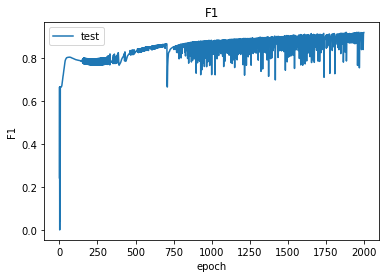

In [27]:
plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

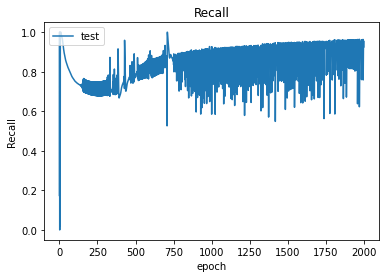

In [28]:
plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]



pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2]



rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[14:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [11]:
rf_random.cv_results_

{'mean_fit_time': array([ 8.04218826,  0.75835733,  0.59341545,  7.22207193,  7.93124666,
         1.67235703,  1.59960957,  1.66373138, 12.49556384,  0.5595717 ]),
 'std_fit_time': array([0.79434563, 0.09650117, 0.02407462, 0.33187474, 0.33237829,
        0.07549821, 0.04951999, 0.04881797, 0.10820537, 0.08099737]),
 'mean_score_time': array([0.37191792, 0.0843874 , 0.06764922, 0.37122622, 0.35335441,
        0.12351613, 0.12141728, 0.11782866, 0.09990692, 0.06779428]),
 'std_score_time': array([0.05150688, 0.01680988, 0.00546238, 0.08972038, 0.02570528,
        0.00247593, 0.00358639, 0.00750082, 0.0037567 , 0.00970381]),
 'param_classifier__n_estimators': masked_array(data=[250, 10, 10, 250, 250, 50, 50, 50, --, 10],
              mask=[False, False, False, False, False, False, False, False,
                     True, False],
        fill_value='?',
             dtype=object),
 'param_classifier__min_samples_split': masked_array(data=[130, 130, 130, 130, 130, 130, 130, 130, --, 130]

In [12]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])


{'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=109, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

In [13]:
pd.DataFrame(rf_random.cv_results_)['params']

0    {'classifier__n_estimators': 250, 'classifier_...
1    {'classifier__n_estimators': 10, 'classifier__...
2    {'classifier__n_estimators': 10, 'classifier__...
3    {'classifier__n_estimators': 250, 'classifier_...
4    {'classifier__n_estimators': 250, 'classifier_...
5    {'classifier__n_estimators': 50, 'classifier__...
6    {'classifier__n_estimators': 50, 'classifier__...
7    {'classifier__n_estimators': 50, 'classifier__...
8    {'classifier': XGBClassifier(base_score=0.5, b...
9    {'classifier__n_estimators': 10, 'classifier__...
Name: params, dtype: object

In [14]:
rf_pd=pd.DataFrame(rf_random.cv_results_)
rf_pd = rf_pd.set_index(rf_pd["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
list(rf_pd.params)

[{'classifier__n_estimators': 250,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 40,
  'classifier__criterion': 'gini',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 250,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 40,
  'classifier__criterion': 'gini',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'c

In [15]:
rf_pd[["params"]]

params
params                                                                                               
250_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...
10_130_40_80_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 10, 'classifier__...
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...
10_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 10, 'classifier__...

In [16]:
names=rf_pd.params

## Barplot for each model in every slit for recall

The score for the first split with each parameter


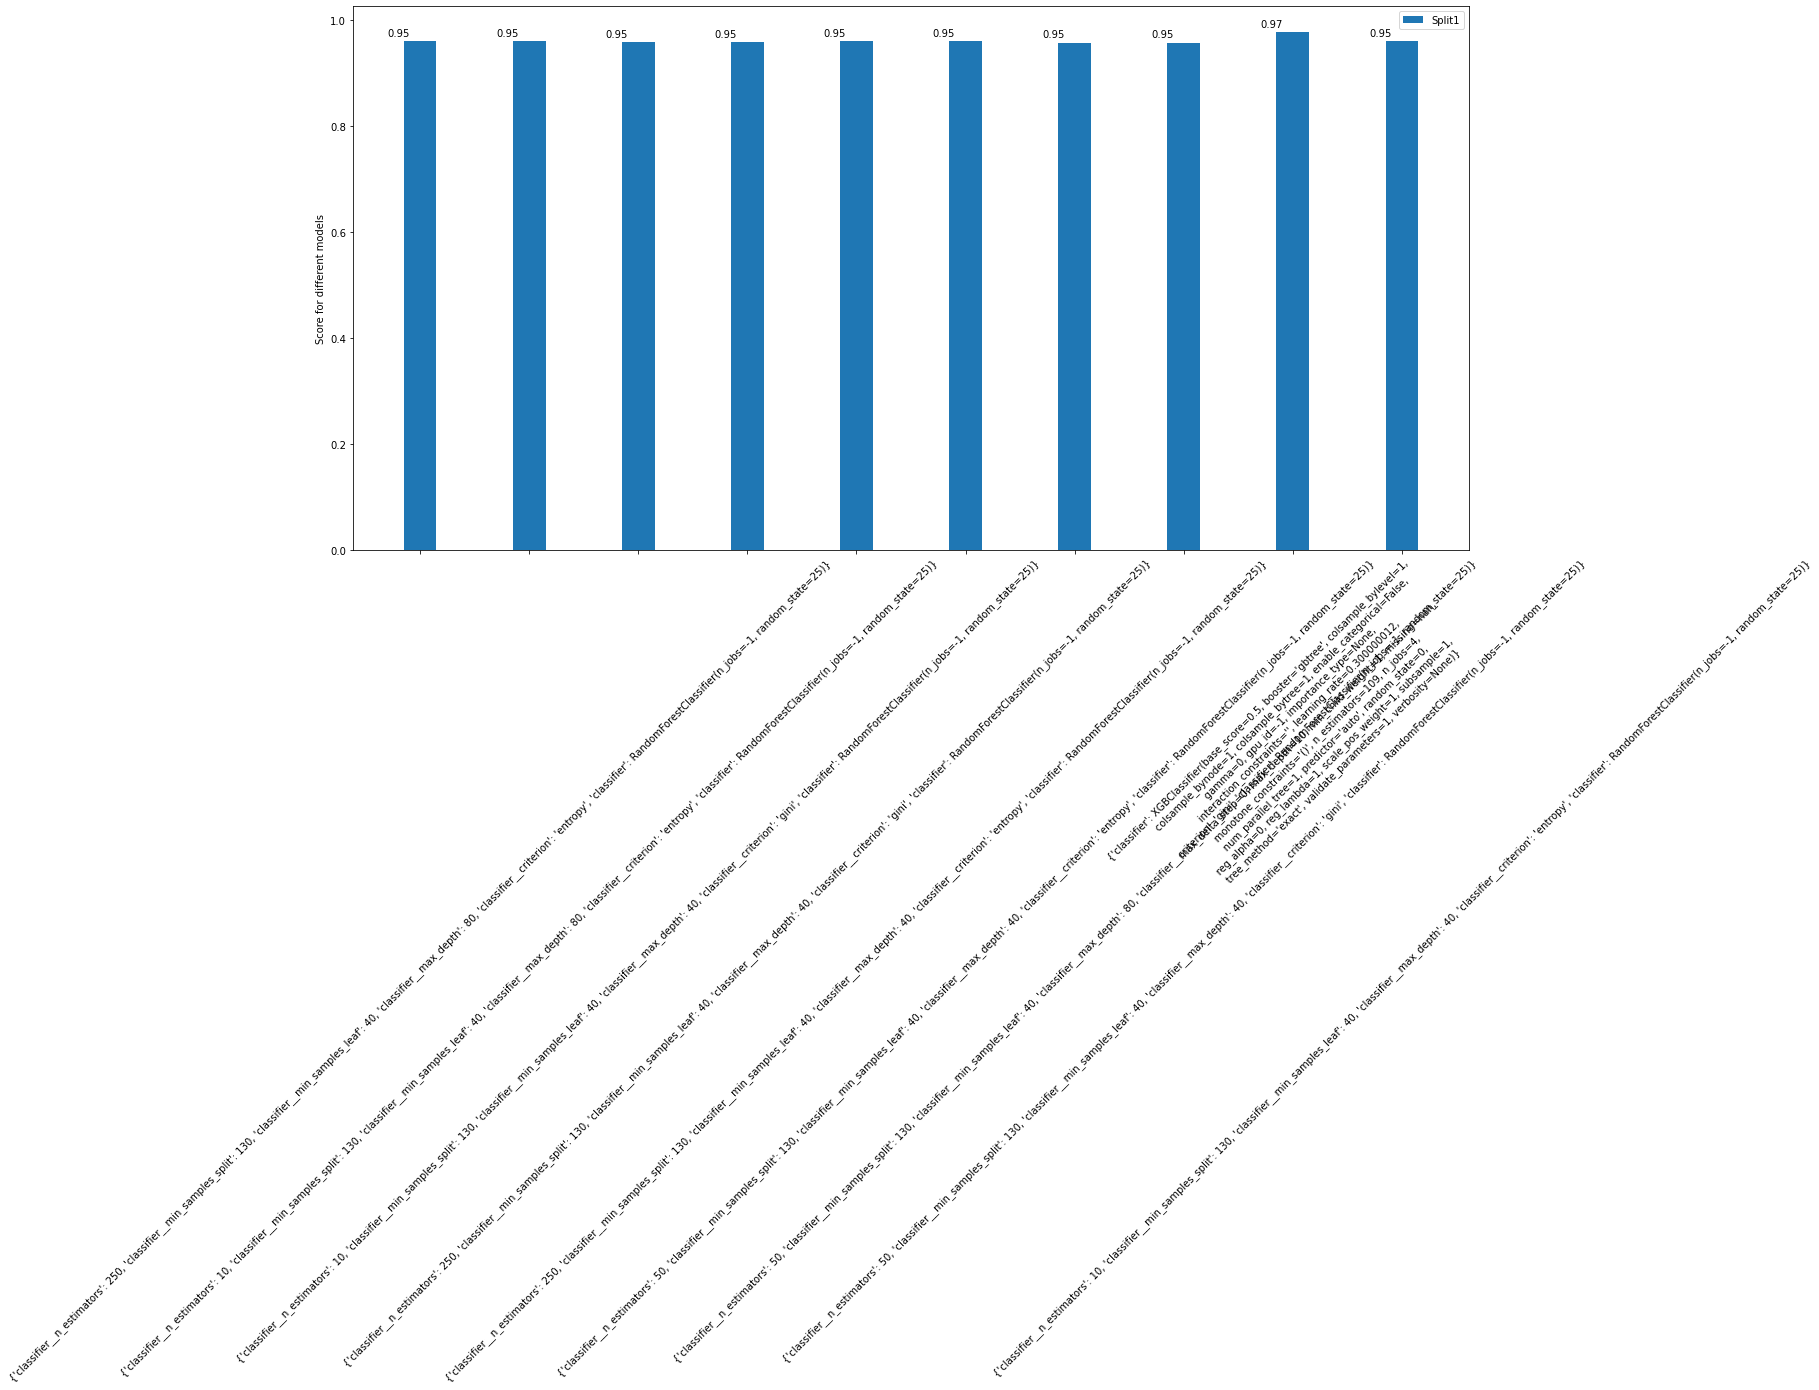

The score for the second split with each parameter


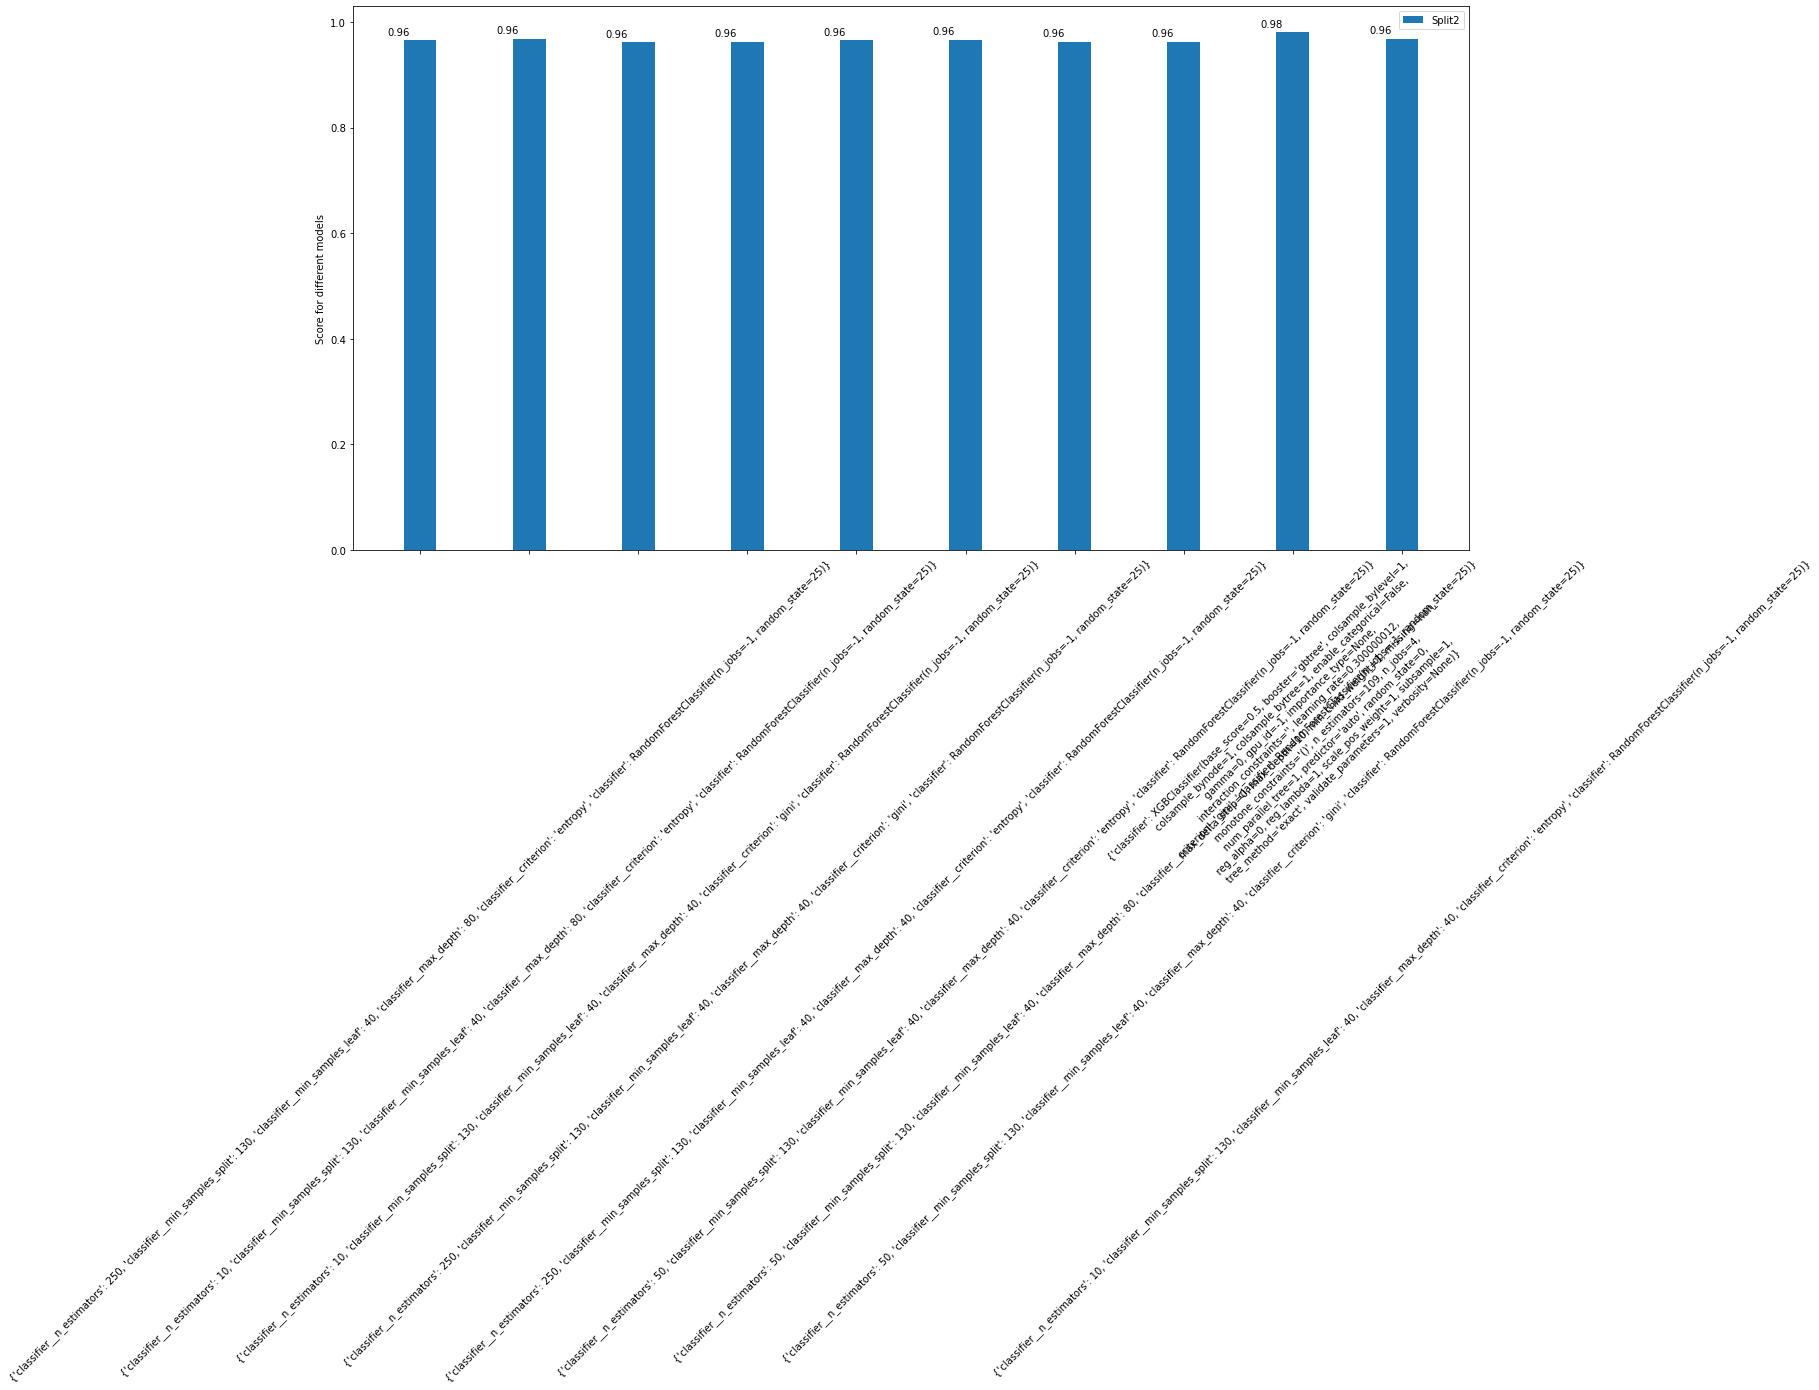

The score for the third split with each parameter


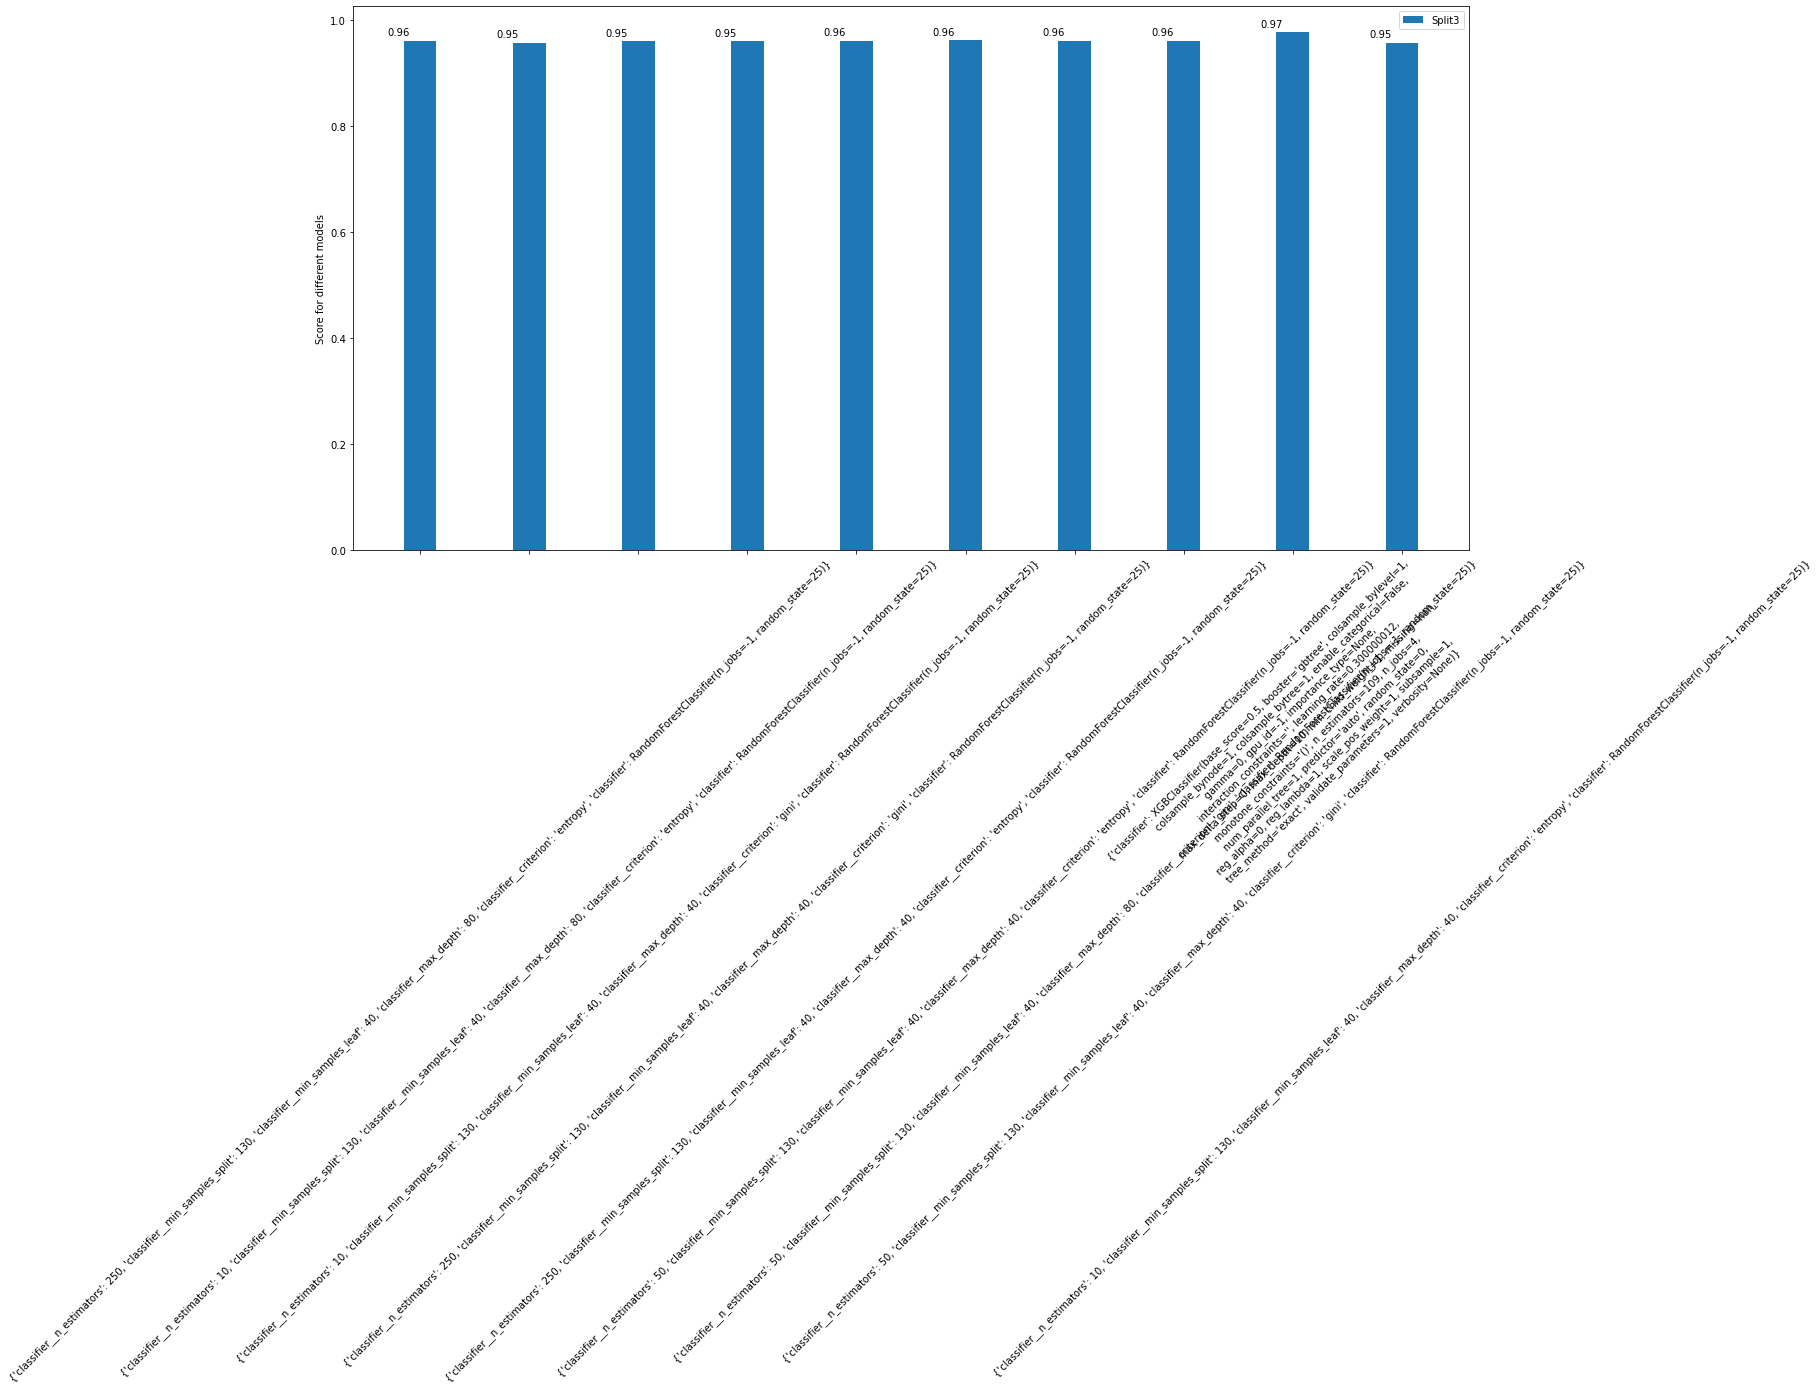

The score for the fouth split with each parameter


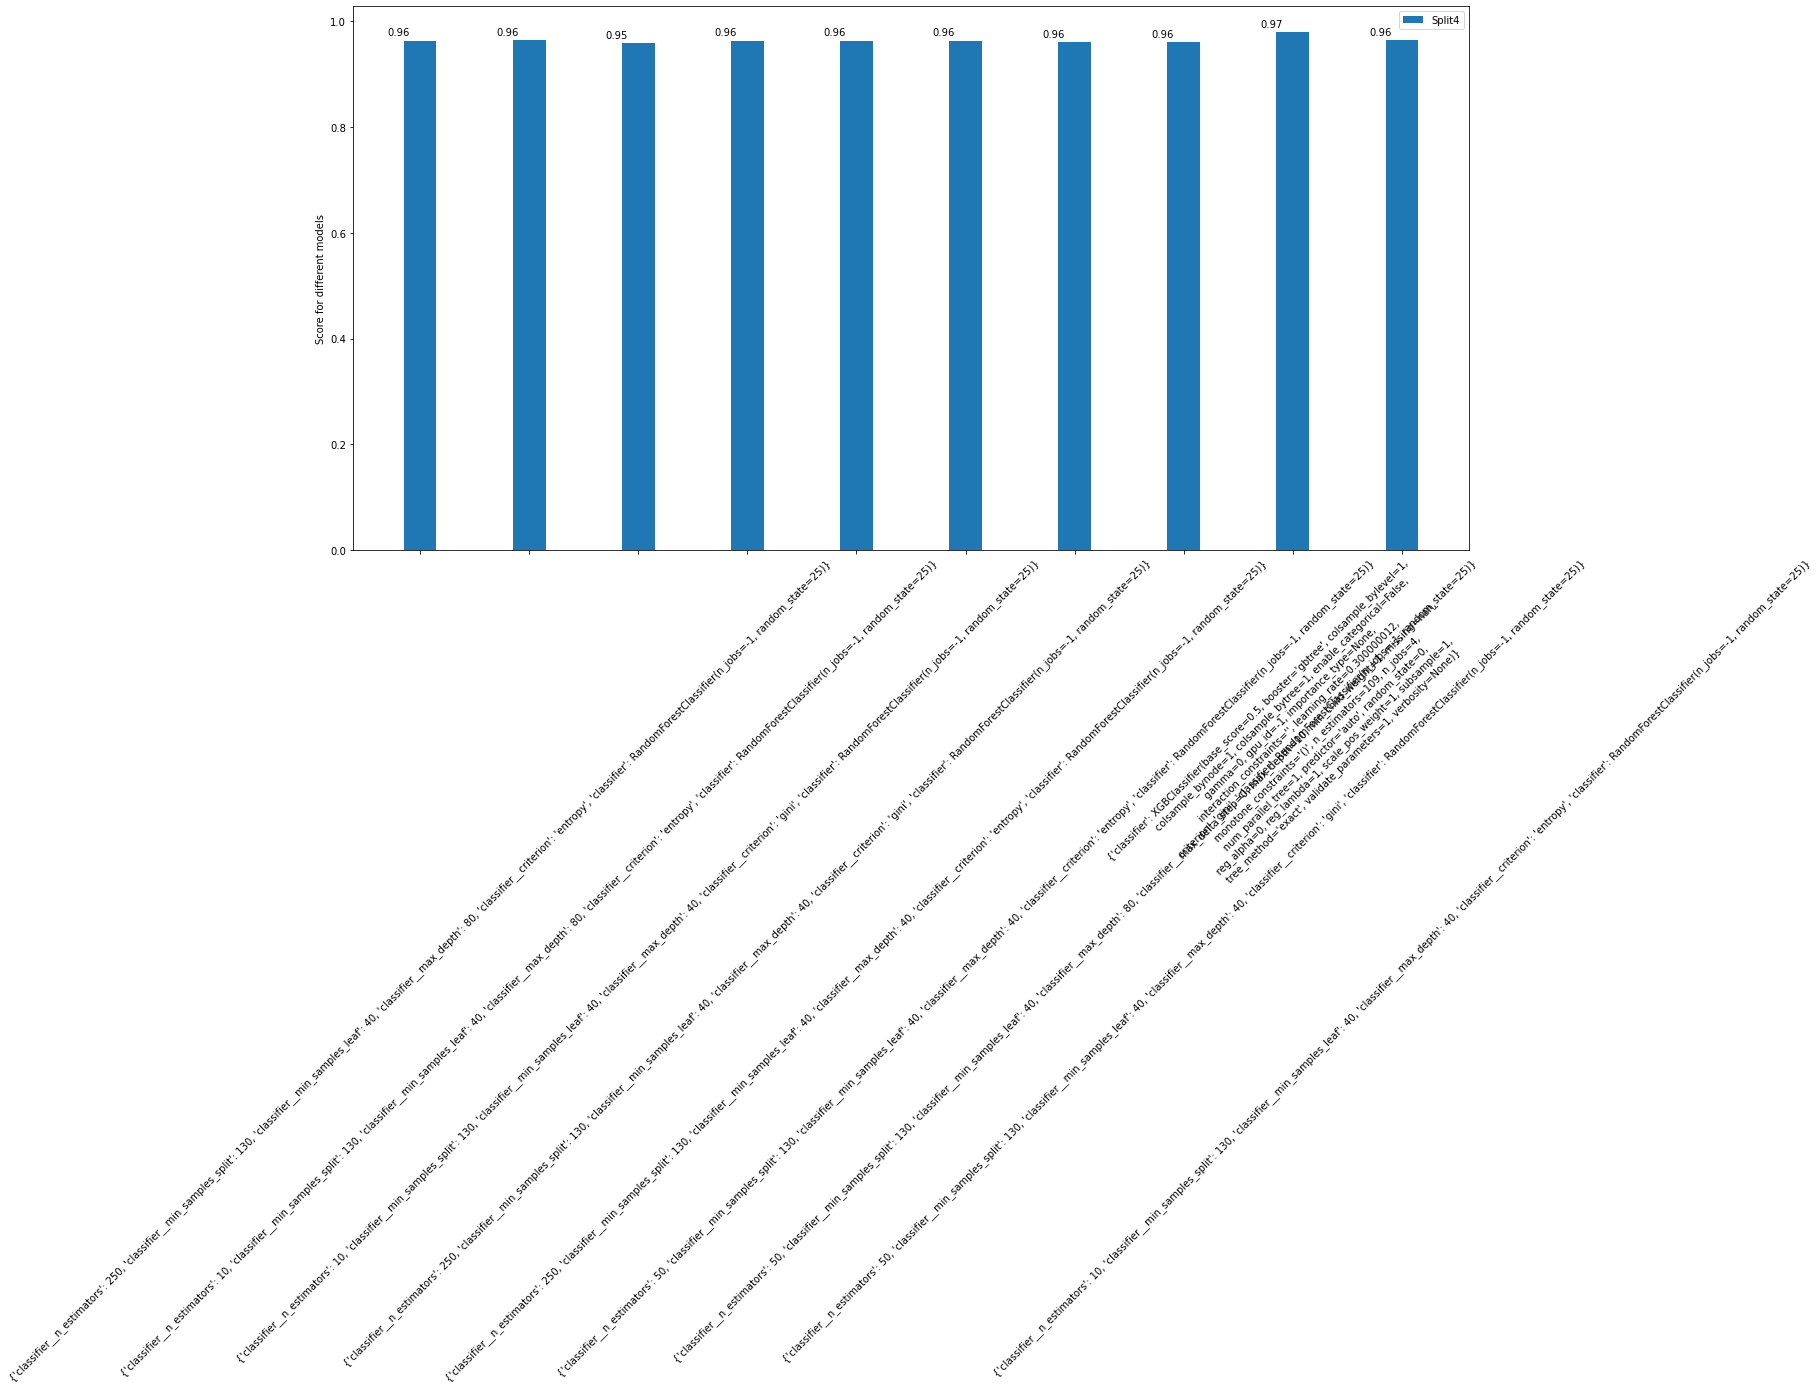

The score for the fifth split with each parameter


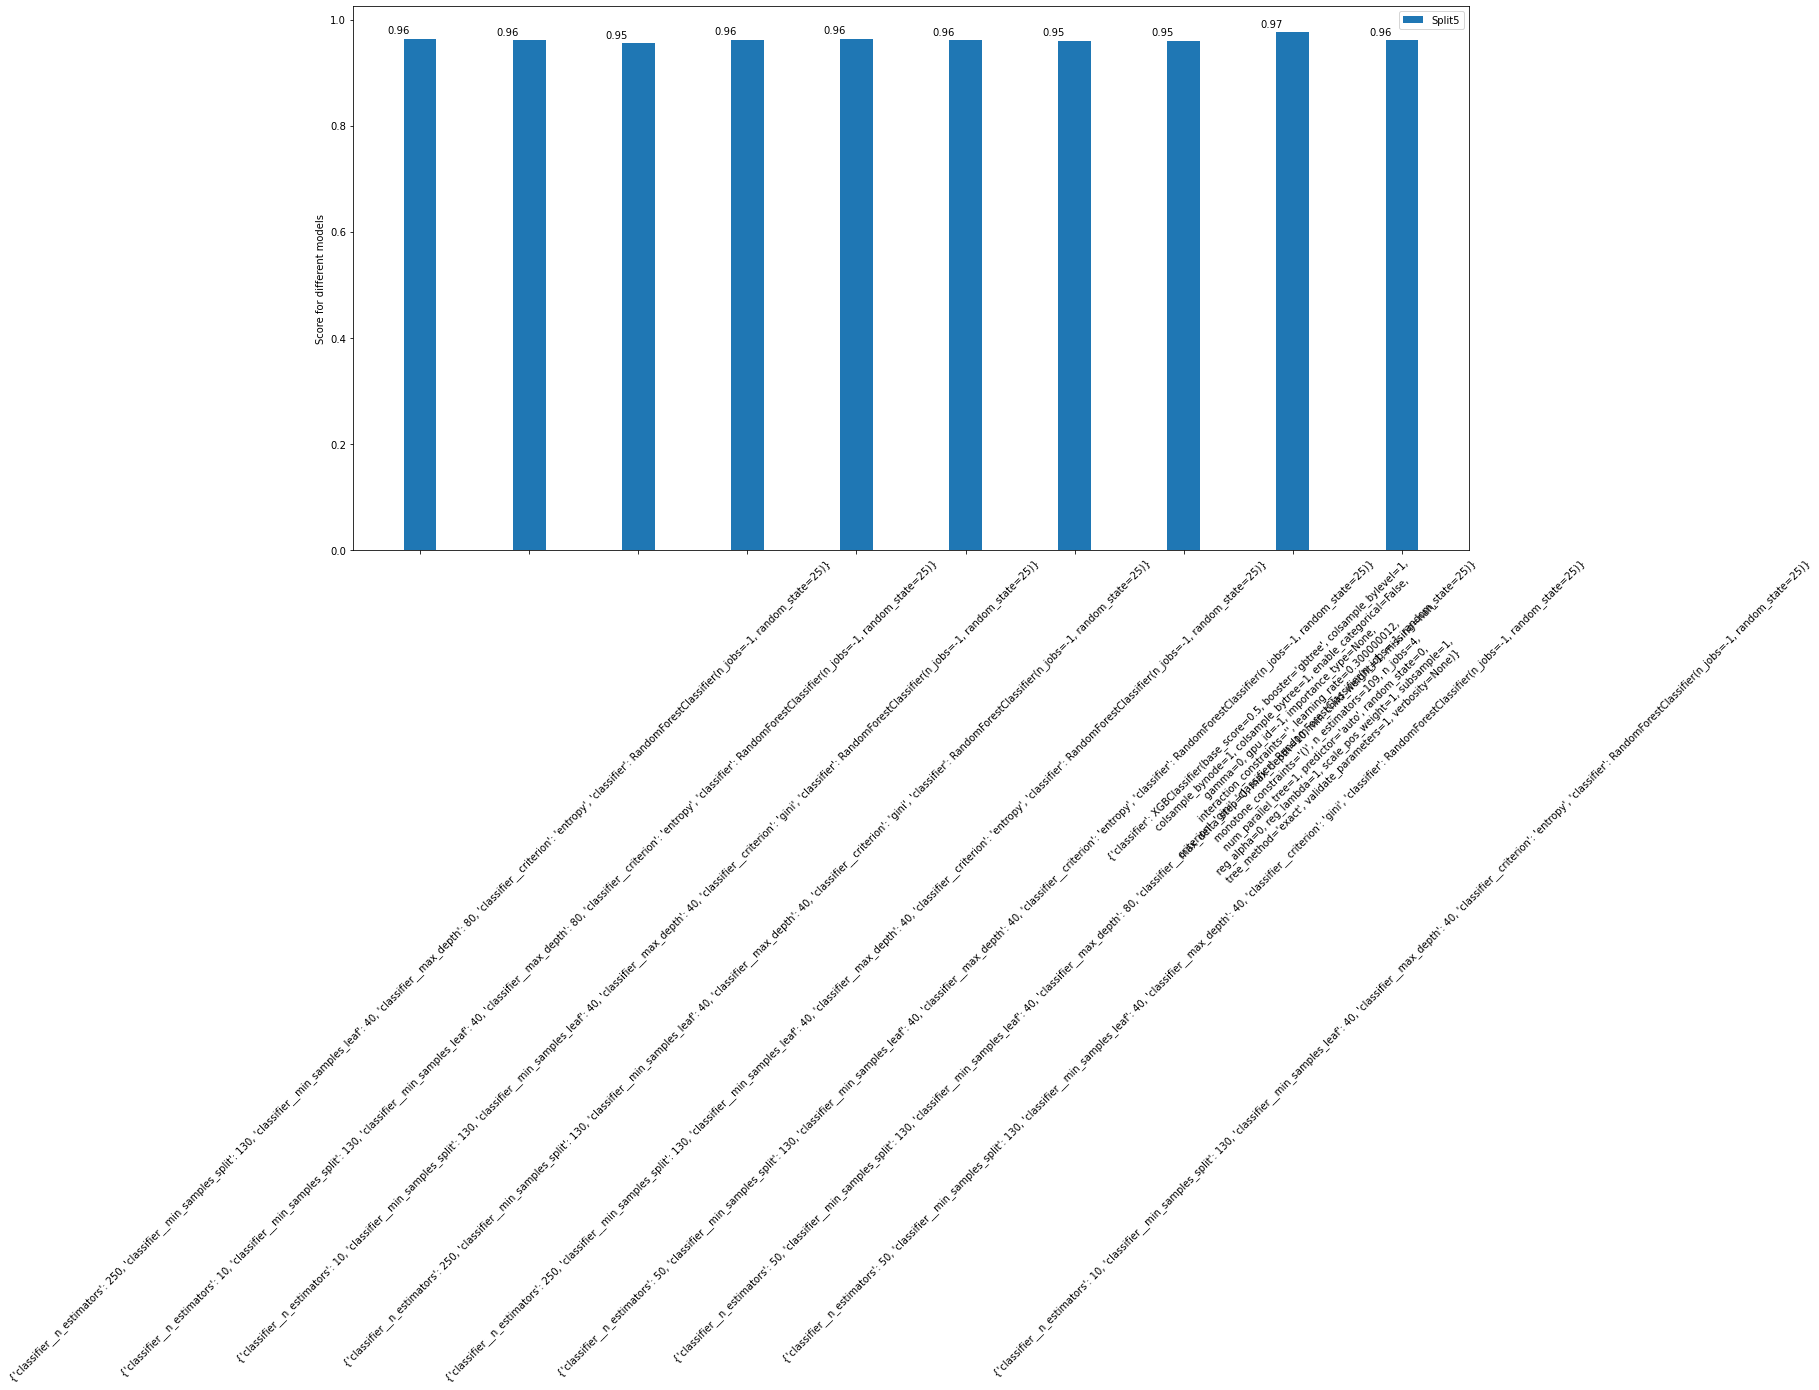

In [17]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_recall"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_recall"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_recall"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_recall"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_recall"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Barplot for each model in every slit for f1

The score for the first split with each parameter


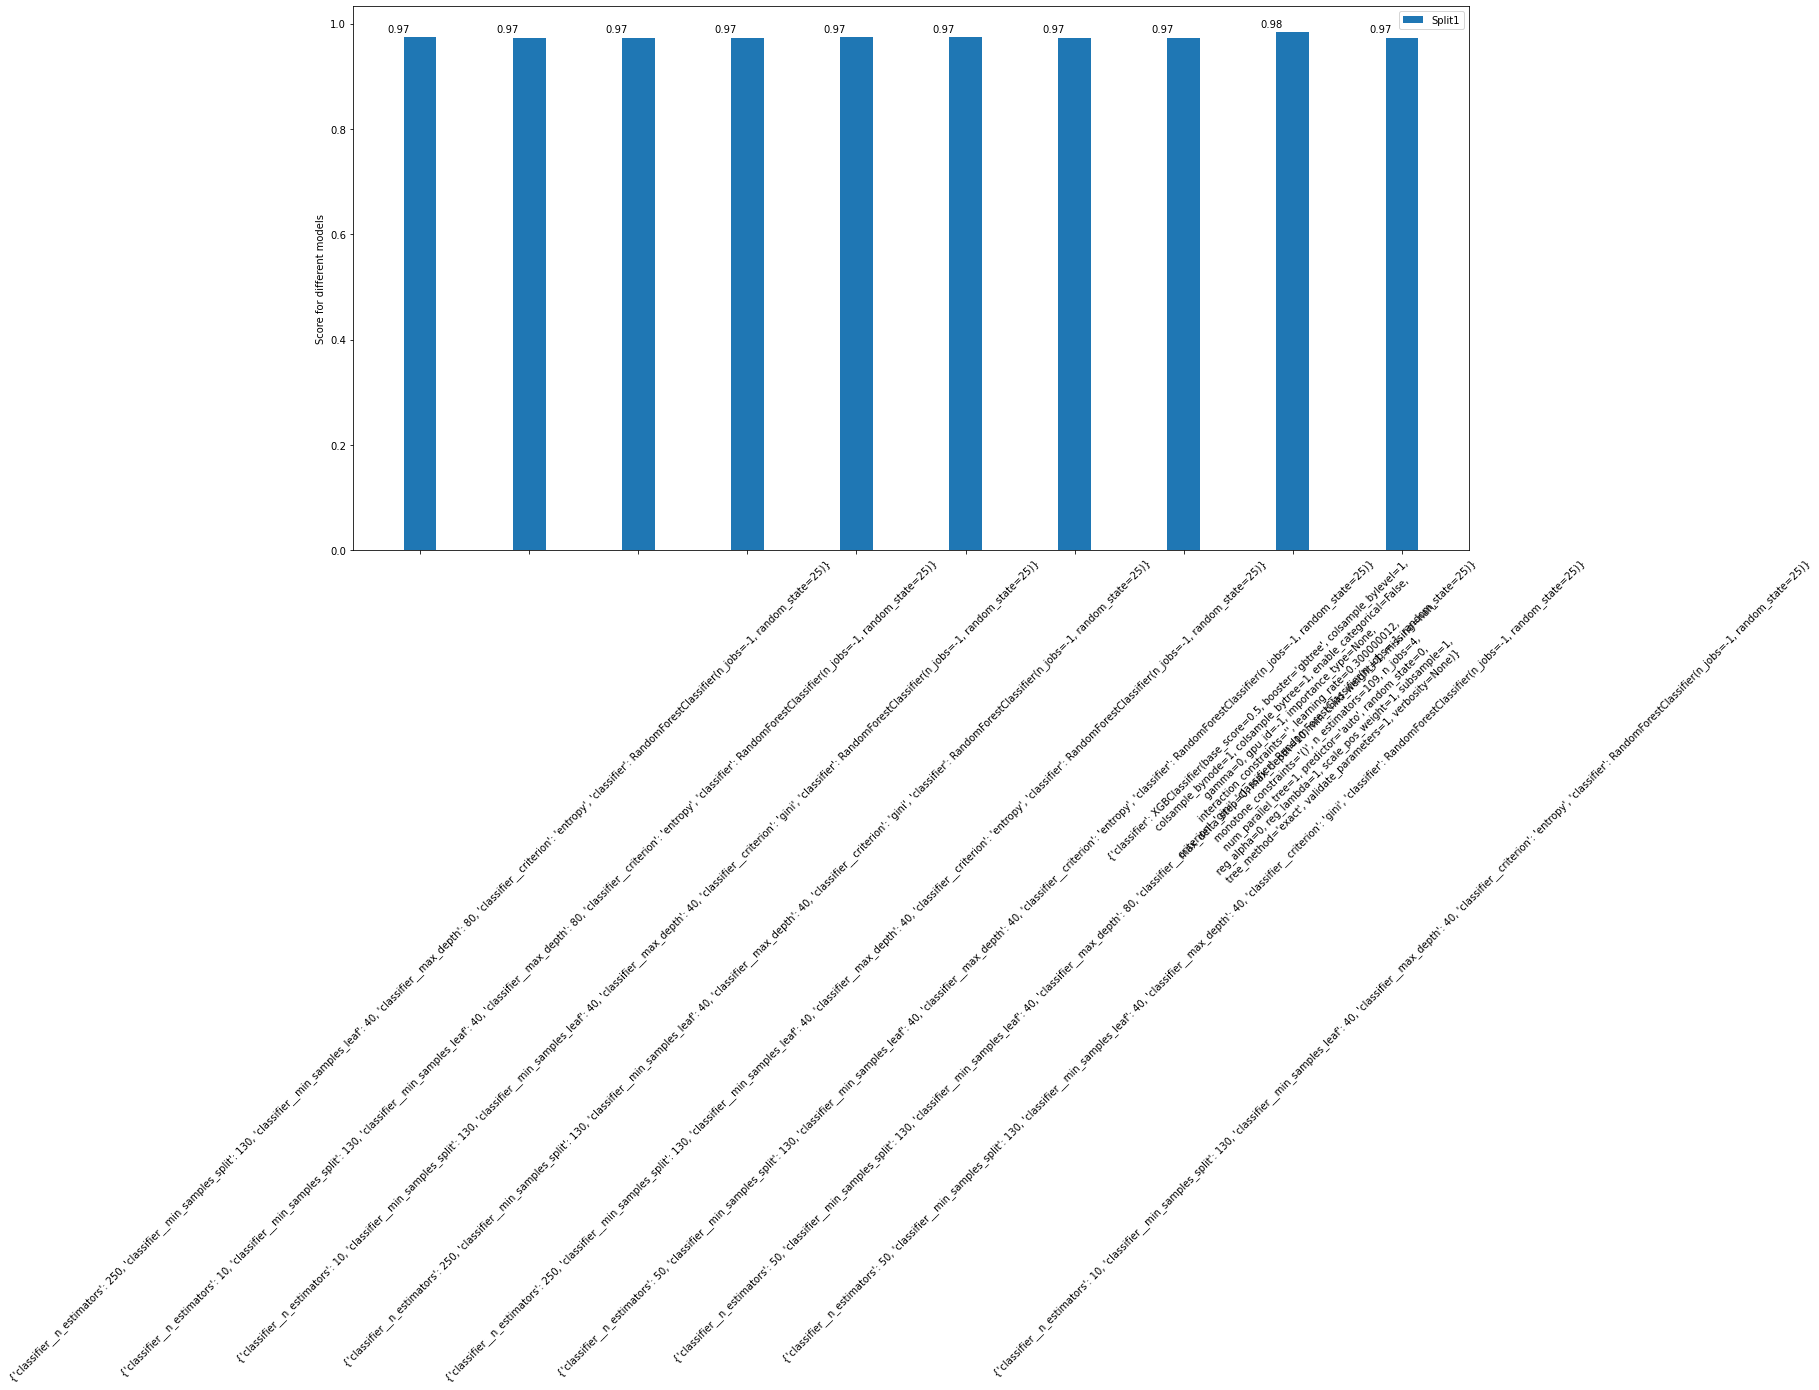

The score for the second split with each parameter


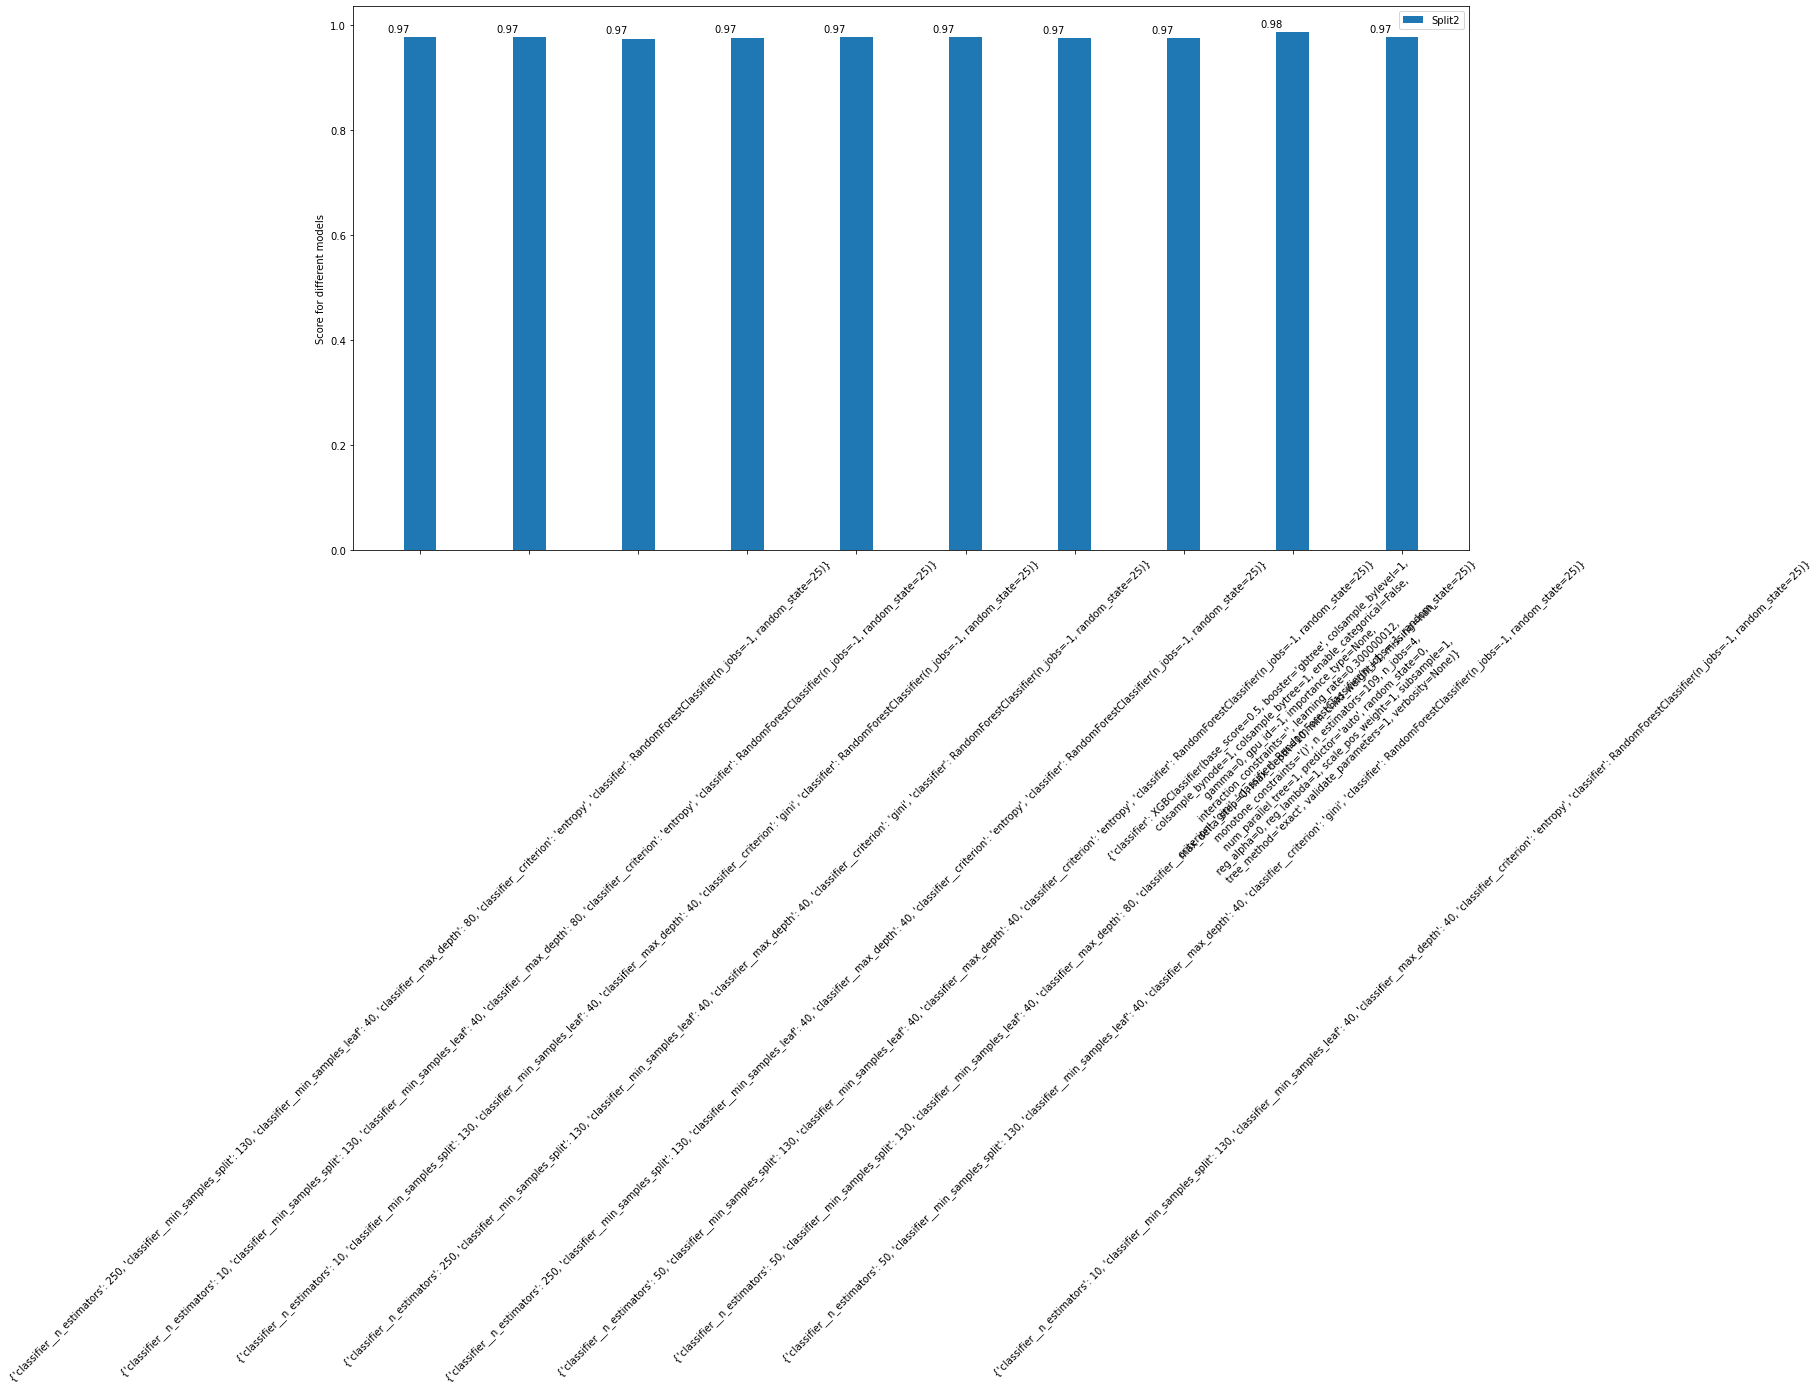

The score for the third split with each parameter


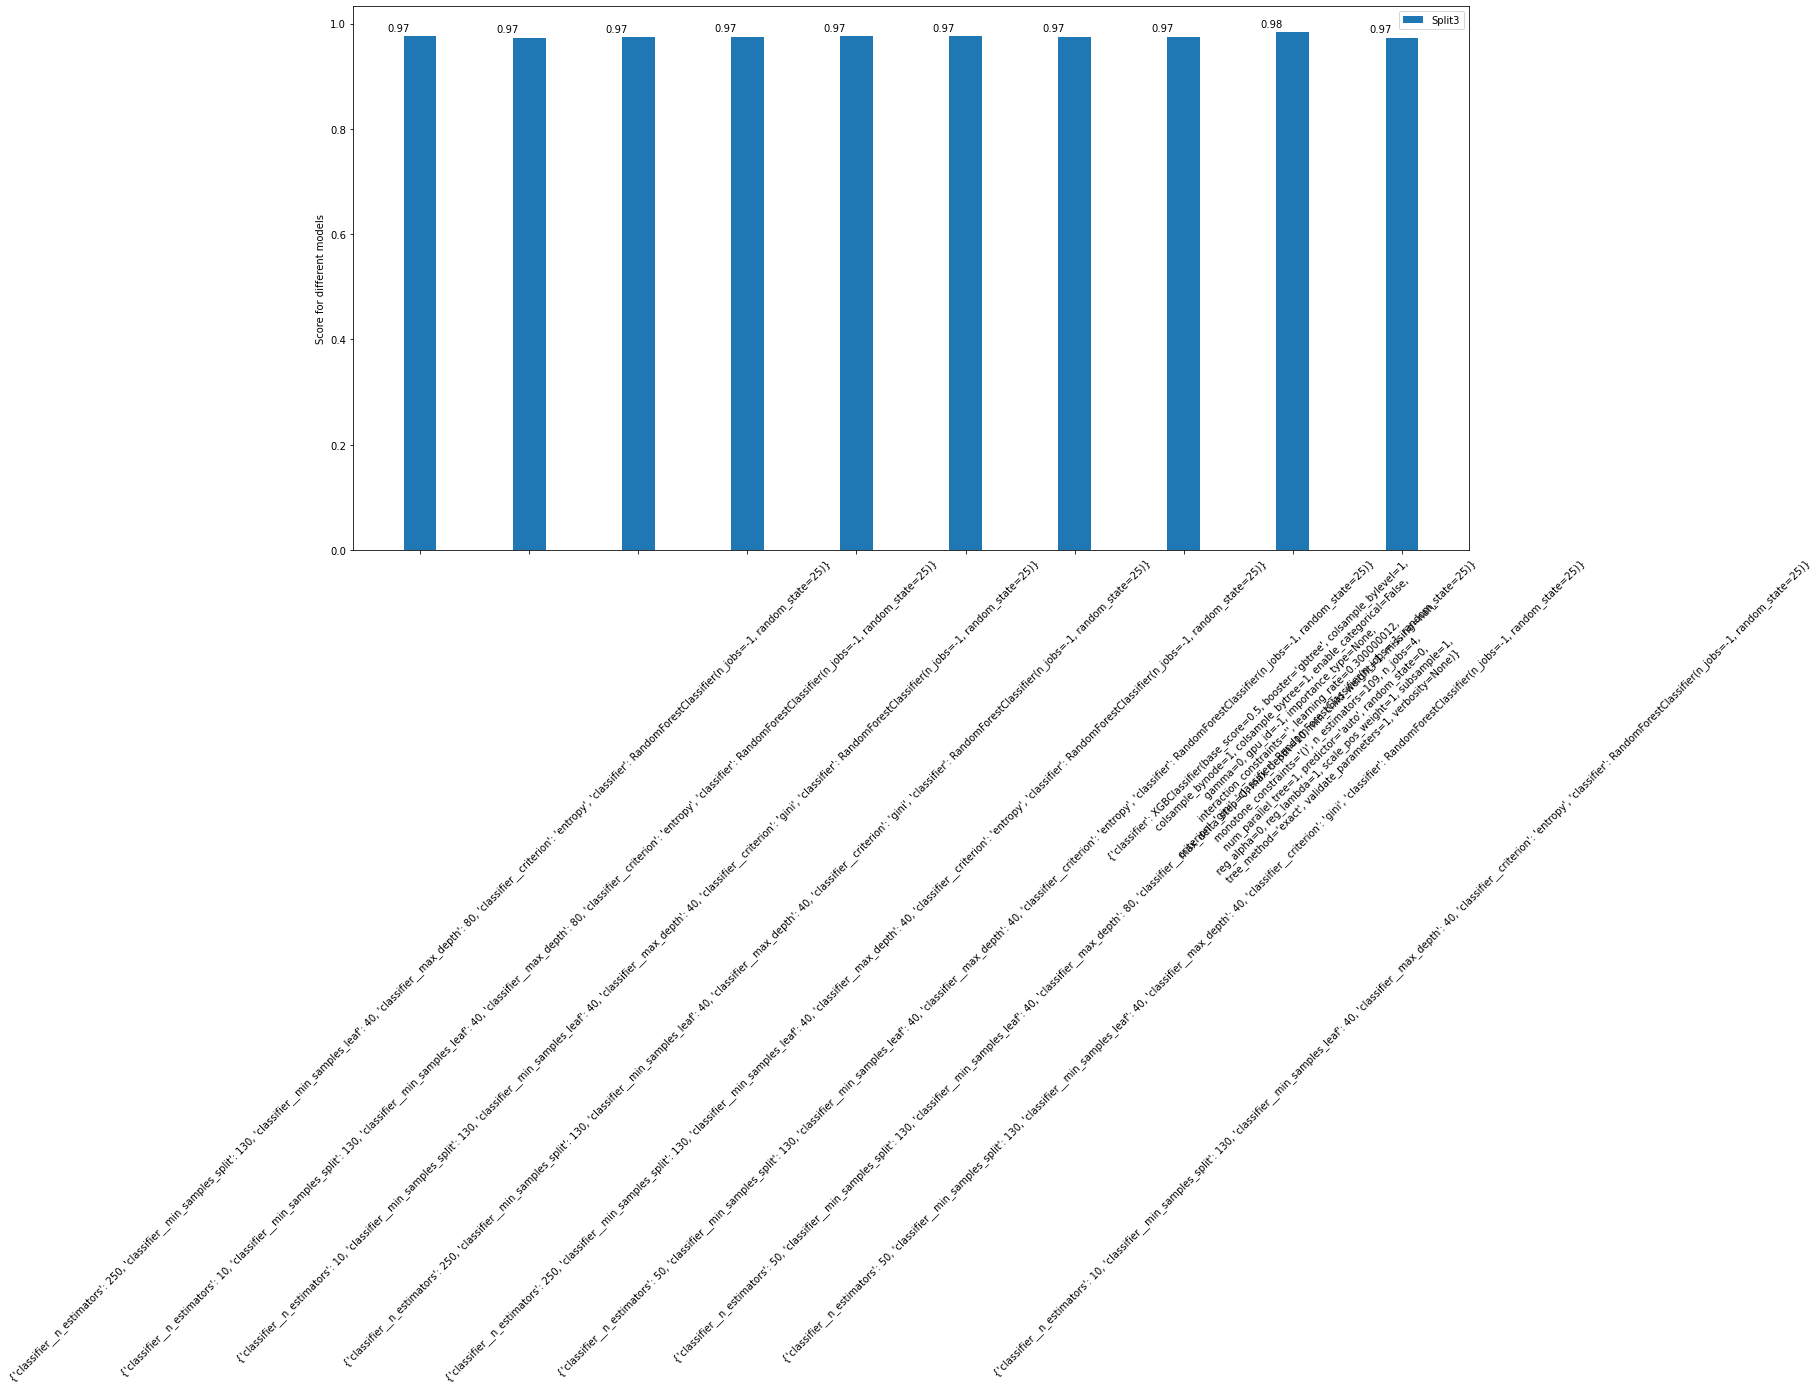

The score for the fouth split with each parameter


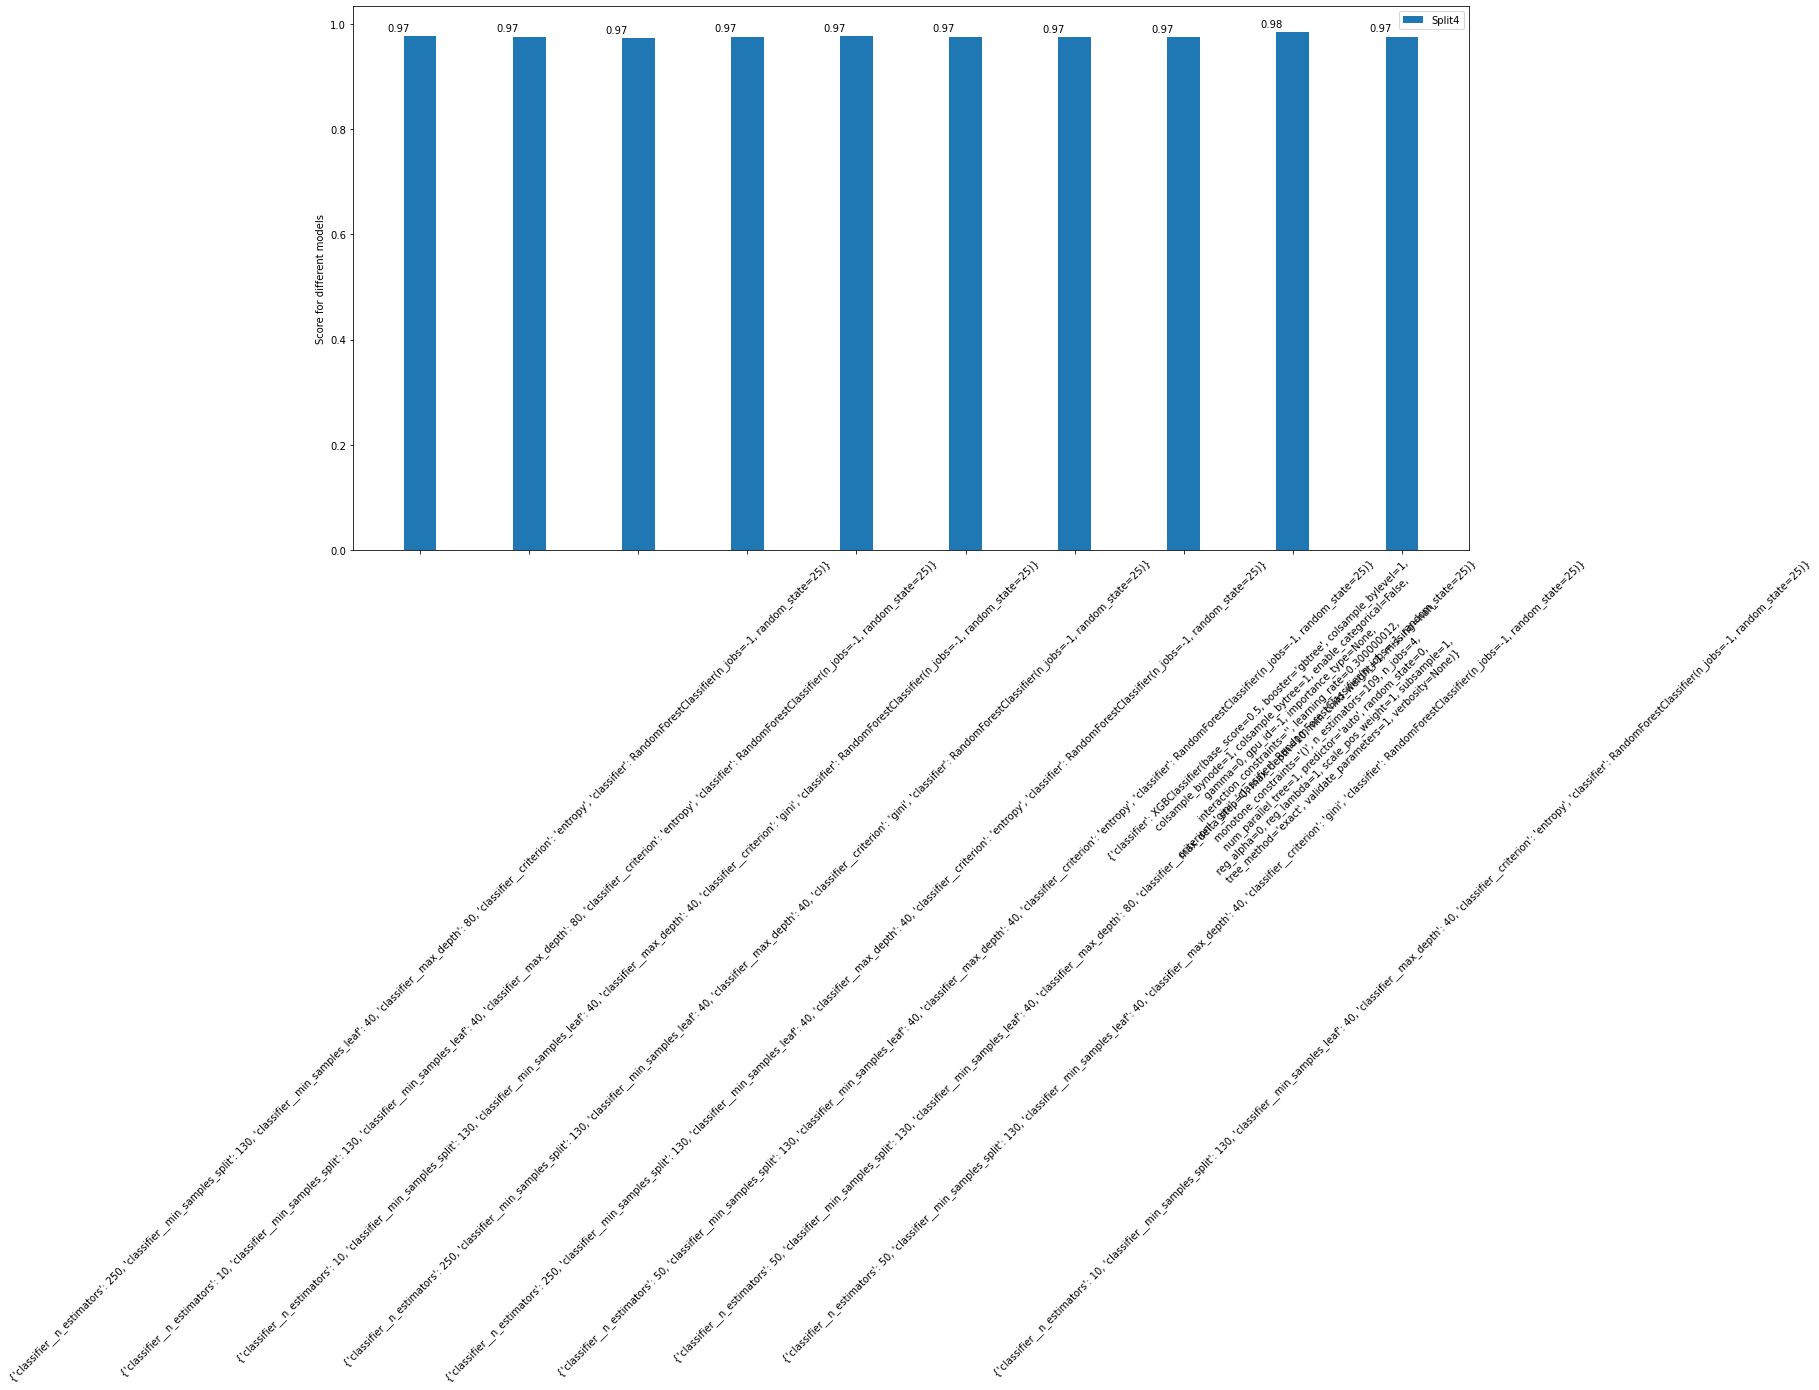

The score for the fifth split with each parameter


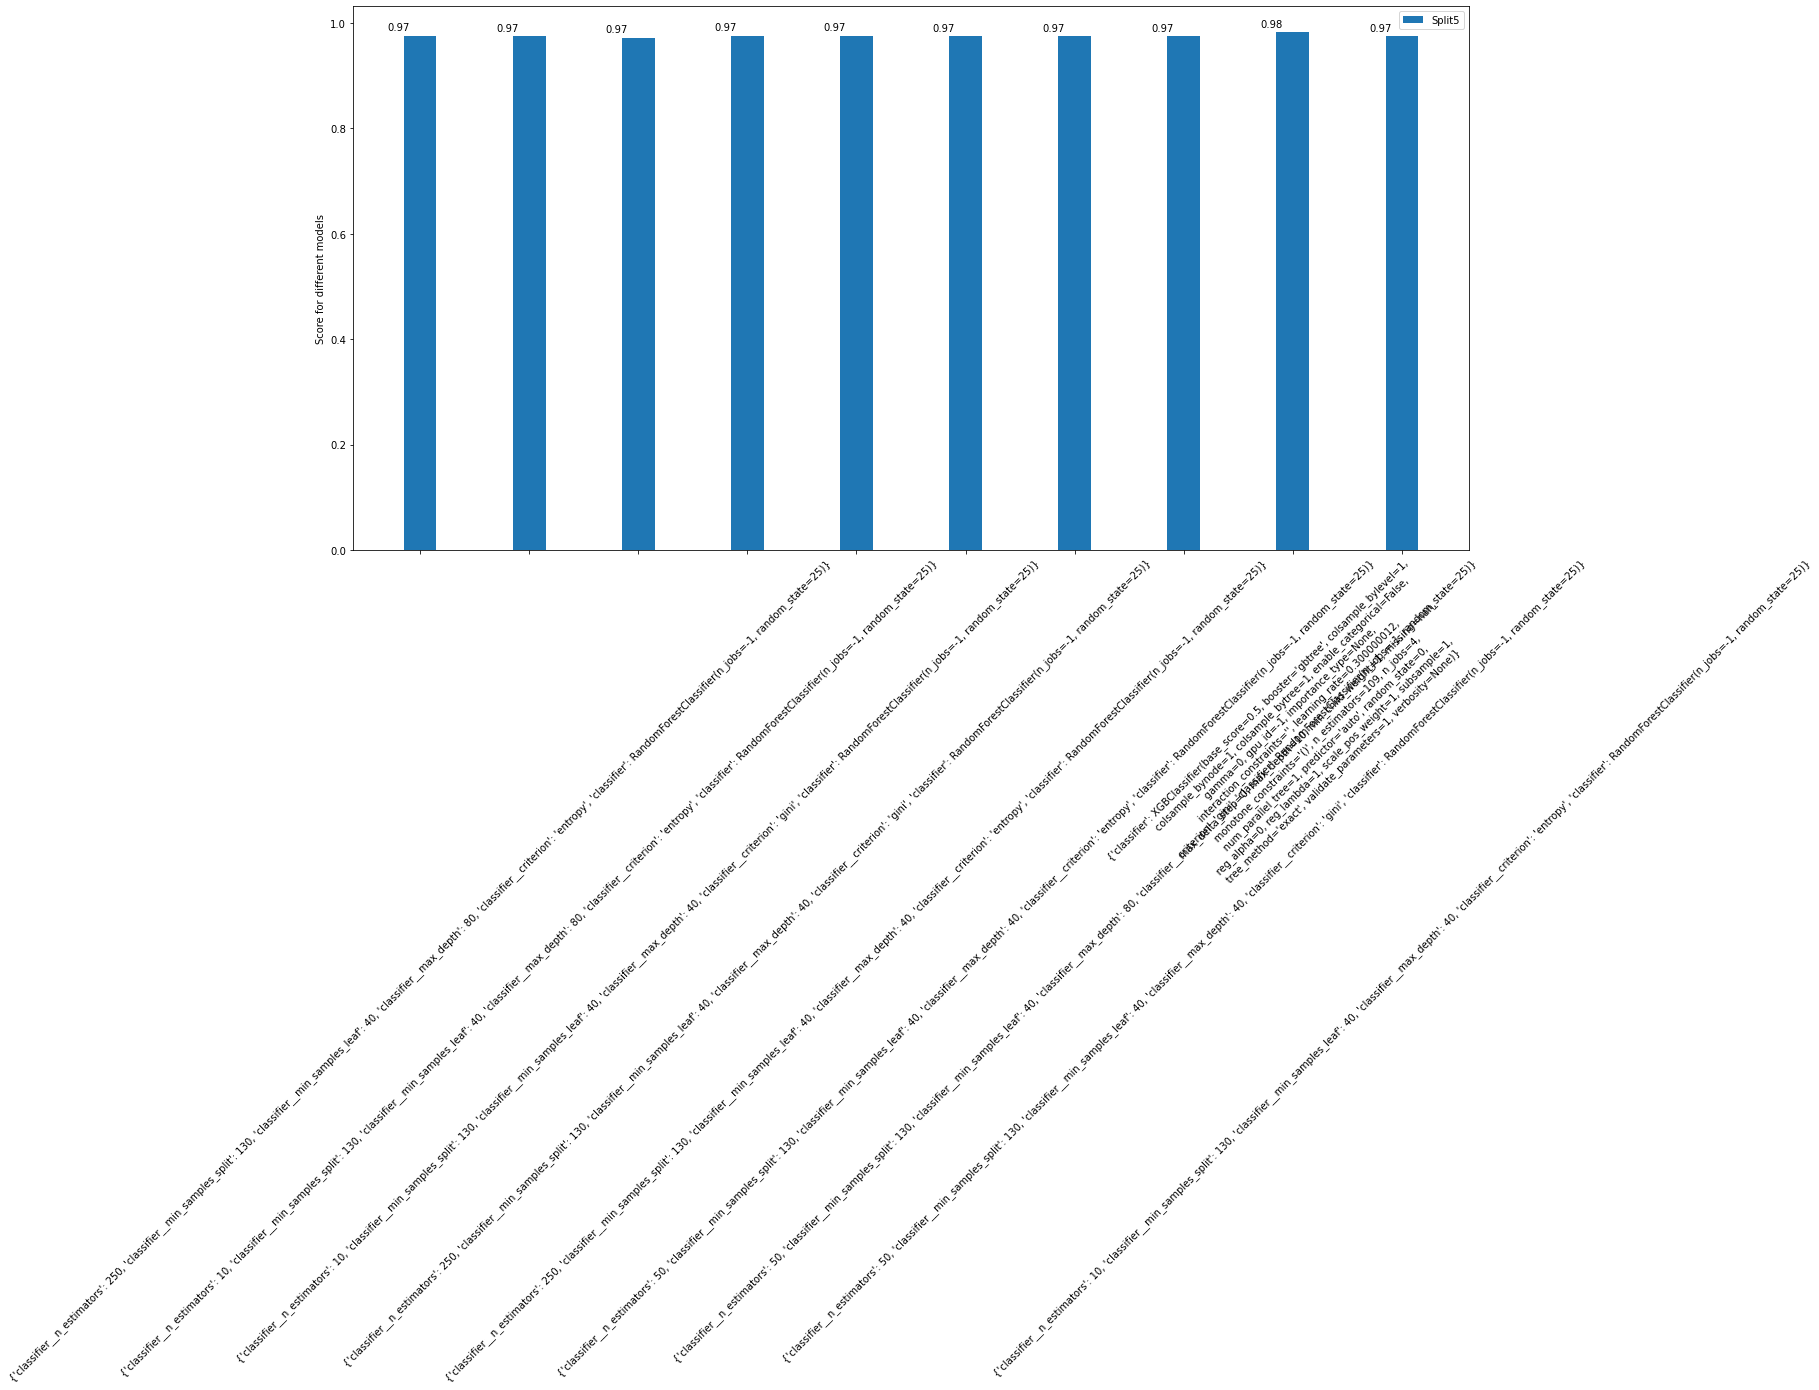

In [18]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_f1"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_f1"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_f1"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_f1"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_f1"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Rank and numeric results of each model

In [19]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
10_130_40_80_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 10, 'classifier__...   
10_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 10, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.973309   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.974406   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.974406   
10_130_40_80_entropy_RandomForestClassifier(n_j...      0.974670   
10_130_40_40_entropy_RandomForestClassifier(n_j...      0.974670   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.974989   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.975699   
250_130_40_80_entropy_RandomForestClassifier(n_...      0.975811   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.975811   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.983802   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996426   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.996910   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996910   
10_130_40_80_entropy_RandomForestClassifier(n_j...           0.996654   
10_130_40_40_entropy_RandomForestClassifier(n_j...           0.996654   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.996979   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.997001   
250_130_40_80_entropy_RandomForestClassifier(n_...           0.997081   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.997081   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998815   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.958714   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.960059   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.960059   
10_130_40_80_entropy_RandomForestClassifier(n_j...          0.961944   
10_130_40_40_entropy_RandomForestClassifier(n_j...          0.961944   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.961142   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.962566   
250_130_40_80_entropy_RandomForestClassifier(n_...          0.962687   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.962687   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.977813   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.988360   
50_130_40_80_gini_RandomForestClassifier(n_jobs...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.973392   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.972967   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.972967   
10_130_40_80_entropy_RandomForestClassifier(n_j...        0.973253   
10_130_40_40_entropy_RandomForestClassifier(n_j...        0.973253   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.973706   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.973994   
250_130_40_80_entropy_RandomForestClassifier(n_...        0.974490   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.974490   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.983535   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

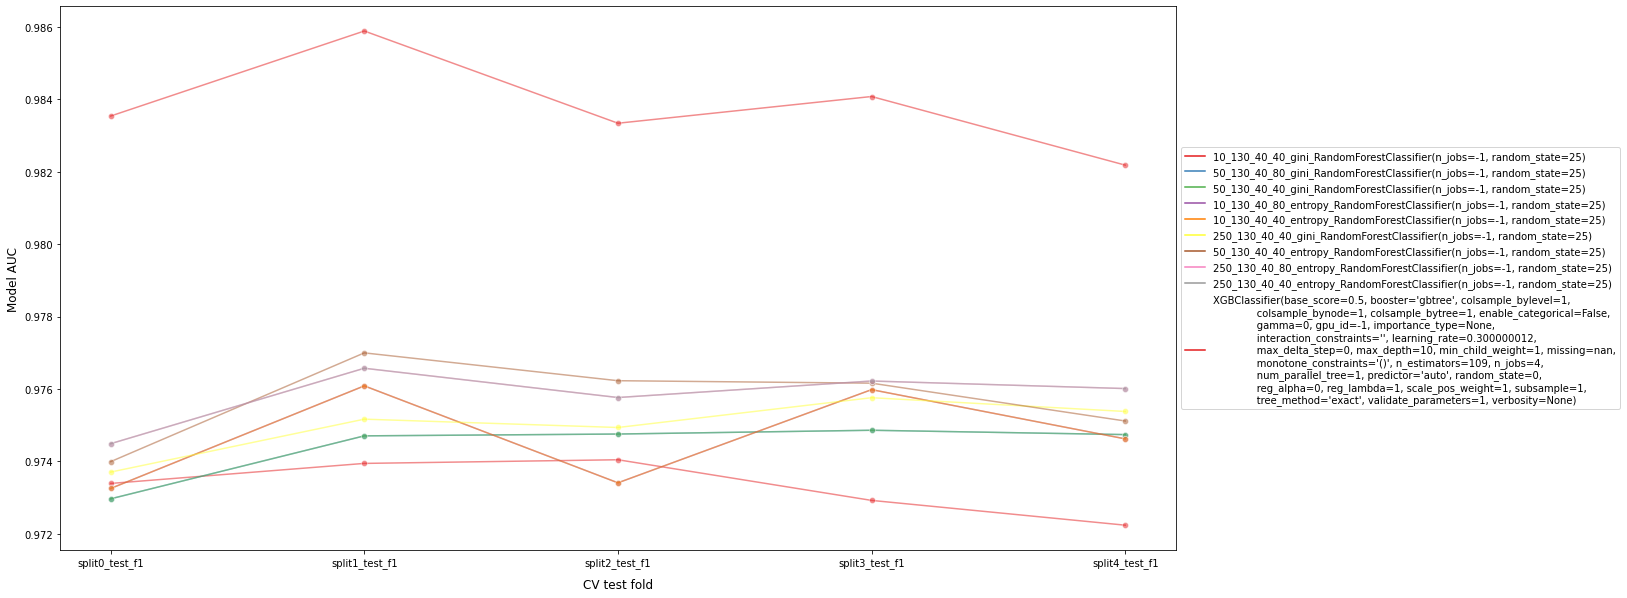

In [20]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])


{'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=109, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

# Xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[15:00:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:19] WARNING: C:/Users/Administrator/workspac

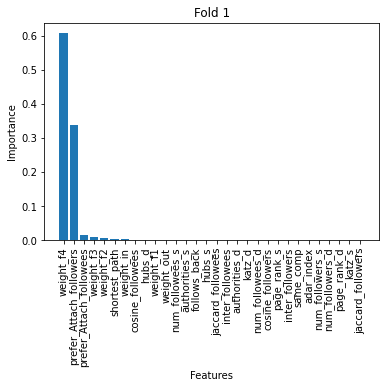

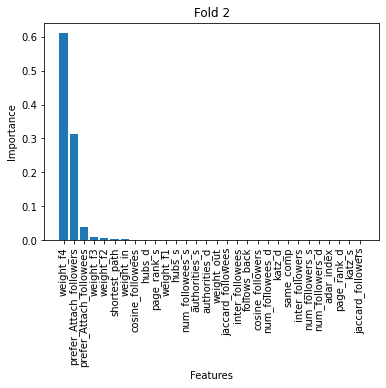

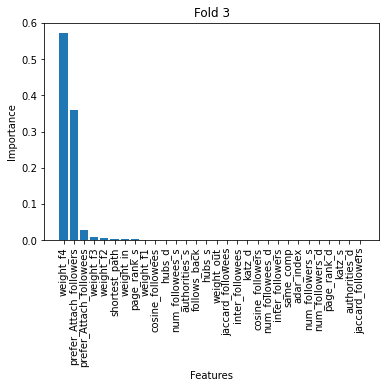

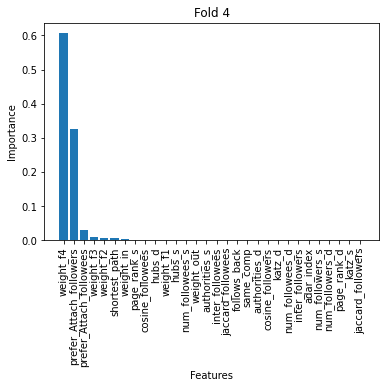

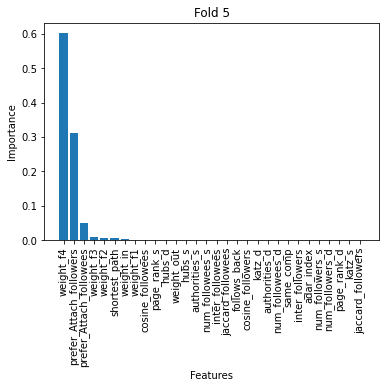

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
#rfc = rf_random.best_estimator_._final_estimator
rfc=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
print(rfc)
count = 1
# test data is not needed for fitting
for train, _ in kf.split(df_final_train, y_train):
    rfc.fit(df_final_train.iloc[train, :], y_train.iloc[train])
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_xgb.sav'
pickle.dump(rfc, open(filename, 'wb'))

## Random Forest

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


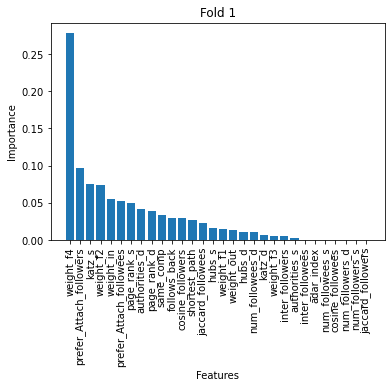

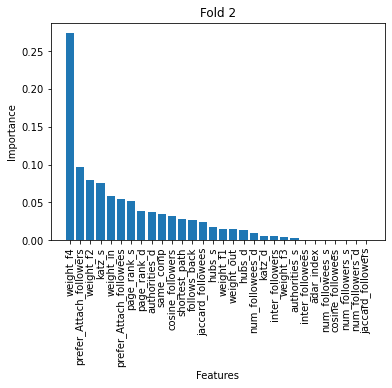

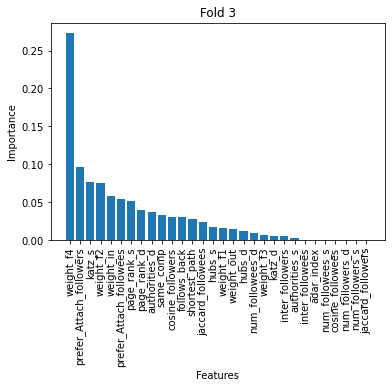

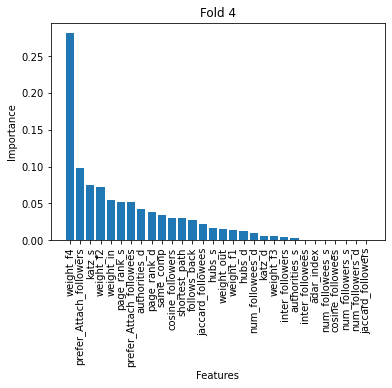

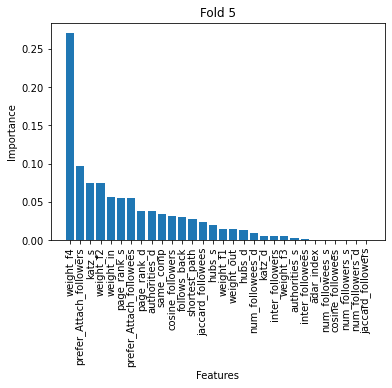

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
print(rfc)
count = 1
# test data is not needed for fitting
for train, _ in kf.split(df_final_train, y_train):
    rfc.fit(df_final_train.iloc[train, :], y_train.iloc[train])
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_rfc.sav'
pickle.dump(rfc, open(filename, 'wb'))

## Lightgbm

LightGBM Model accuracy score: 0.9851
LightGBM Model f1 score: 0.9850
LightGBM Model recall score: 0.9782


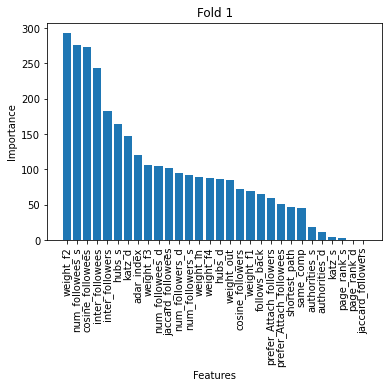

LightGBM Model accuracy score: 0.9829
LightGBM Model f1 score: 0.9825
LightGBM Model recall score: 0.9757


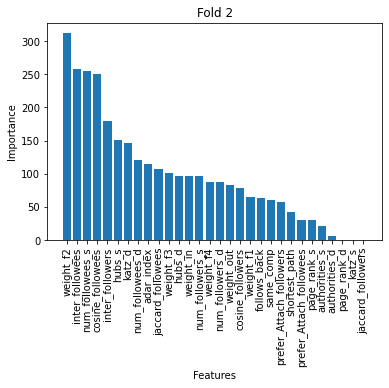

LightGBM Model accuracy score: 0.9838
LightGBM Model f1 score: 0.9838
LightGBM Model recall score: 0.9769


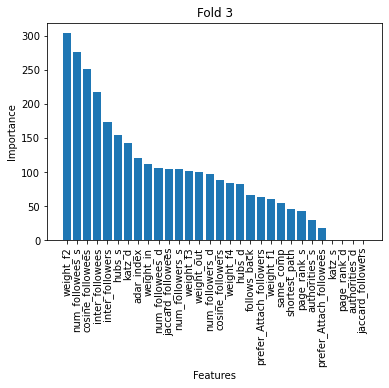

LightGBM Model accuracy score: 0.9830
LightGBM Model f1 score: 0.9827
LightGBM Model recall score: 0.9751


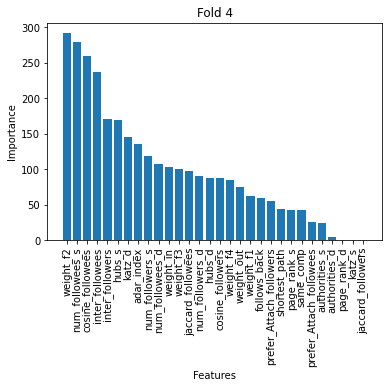

LightGBM Model accuracy score: 0.9843
LightGBM Model f1 score: 0.9843
LightGBM Model recall score: 0.9779


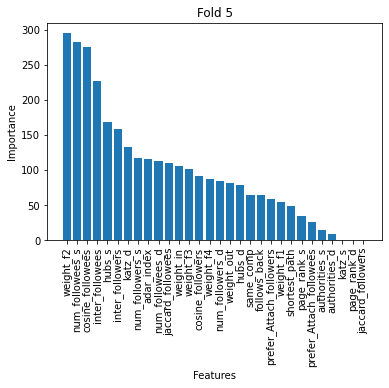

In [24]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


feature_names = list(df_final_train.columns)


cv = KFold(n_splits=5, random_state=25,shuffle=True)
# perform cross-validation procedure
count=1
for train_ix, test_ix in cv.split(df_final_train):
    # split data
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train_lgb)

    y_pred=clf.predict(X_test)
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, y_pred)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, y_pred)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, y_pred)))
    
    importances_index_desc = np.argsort(clf.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, clf.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count=count+1
    plt.show()
    
filename = 'finalized_model_lgb.sav'
pickle.dump(rfc, open(filename, 'wb'))

## Everything

In [6]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

# def buildModel():

#     model = Sequential()

#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(1, activation=output_layer_act))

#     sgd=optimizers.SGD(lr=learning_rate)
#     model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
#     return model


# clf4 = KerasRegressor(build_fn = buildModel)



param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

# param4={}
# param4['classifier__batch_size']= [0.8*len(df_final_train)]
# param4['classifier__epochs']= [10]
# param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]


print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[19:37:46] WARNING: C:/Users

In [7]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.973309   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.974406   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.974406   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.974989   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.975699   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.975790   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.975790   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.975811   
LGBMClassifier()                                        0.983391   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.983802   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996426   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996910   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.996910   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.996979   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.997001   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.997037   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.997037   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.997081   
LGBMClassifier()                                             0.998776   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998815   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.958714   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.960059   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.960059   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.961142   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.962566   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.962626   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.962626   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.962687   
LGBMClassifier()                                            0.976348   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.977813   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.988360   
50_130_40_40_gini_RandomForestClassifier(n_jobs...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.973392   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.972967   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.972967   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.973706   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.973994   
100_130_40_80_entropy_RandomForestClassifier(n_...        0.974745   
100_130_40_40_entropy_RandomForestClassifier(n_...        0.974745   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.974490   
LGBMClassifier()                                          0.983310   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.983535   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

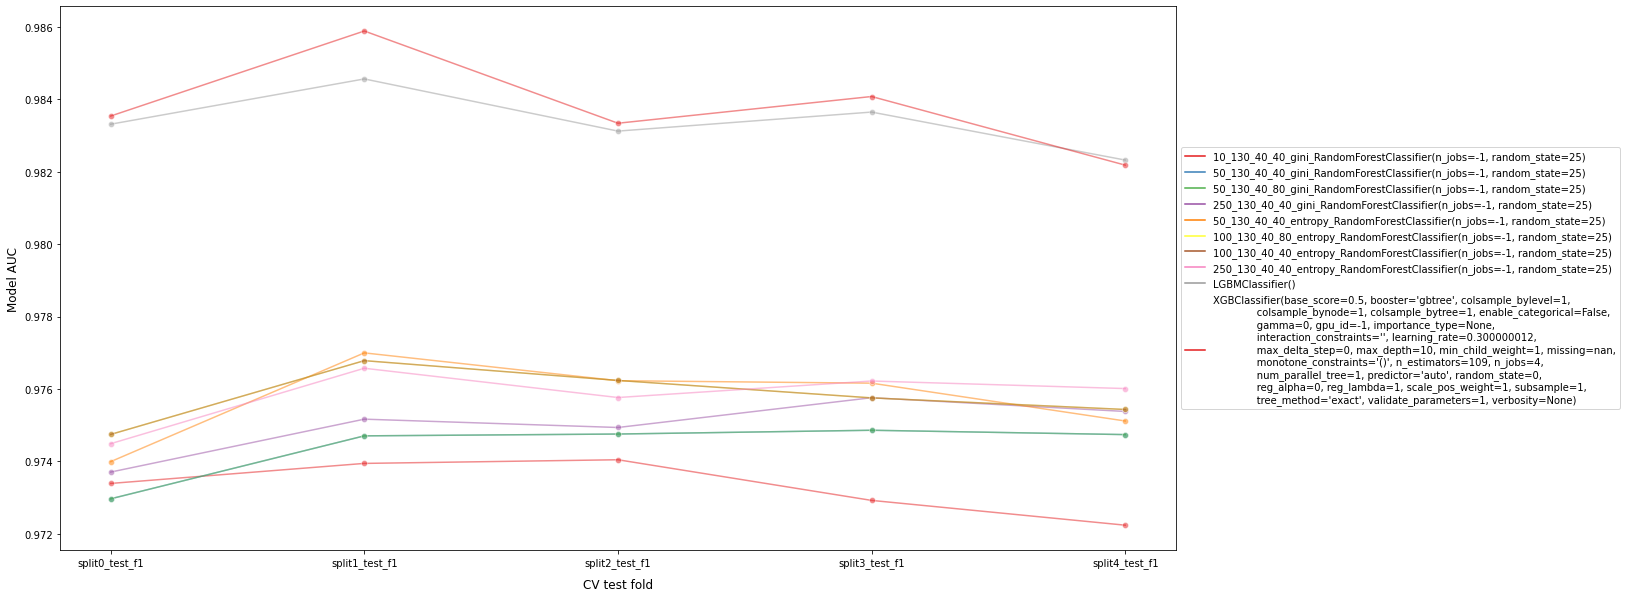

In [8]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()